In [ ]:
# hide this cell if not running on google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import seaborn as sns
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load train and test dataset

In [ ]:
data = None
path = '/content/drive/MyDrive/Colab Notebooks/data'

with open(path+'/classification_train_test_data.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data.keys())
#print(type(data['labels']))
train_data = tf.data.Dataset.from_tensor_slices((data['train']['features_rgb'],data['train']['labels']))
test_data = tf.data.Dataset.from_tensor_slices((data['test']['features_rgb'],data['test']['labels']))

dict_keys(['train', 'test', 'class_labels'])


# Create train and validation set

In [ ]:
# defining some hyperparameters
TRAIN_LENGTH = int(0.7 * len(train_data))
BUFFER_SIZE = 1000
BATCH_SIZE = 32
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Split the dataset into training and testing subsets
train_dataset = train_data.take(TRAIN_LENGTH)
val_dataset =  train_data.skip(TRAIN_LENGTH)


train_ds = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(80).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#train_dataset = train_datase
test_ds = test_data.shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(80).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define the soft attention layer

In [ ]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


# Load resnet50 with imagenet weights

In [ ]:
resnet = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet.layers[-3].output

102967424/102967424 [==============================] - 5s 0us/step


Soft Attention

# Attach soft attention layer  to resnet50

In [ ]:


attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


In [ ]:

output = GlobalAveragePooling2D()(conv)
output = Dense(8, activation='softmax')(output)
model_res50 = Model(inputs=resnet.input, outputs=output)

# Model summary

In [ ]:
model_res50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Model architecture

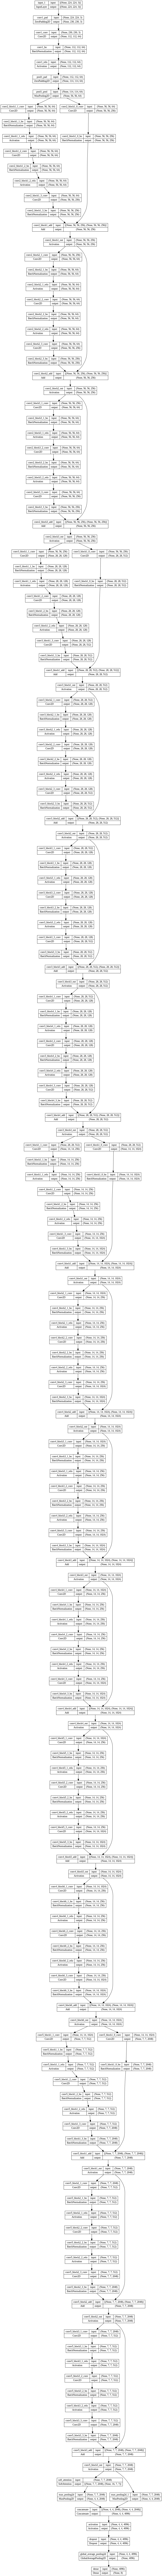

In [ ]:
tf.keras.utils.plot_model(model_res50, show_shapes=True,to_file='./resnet50.png')

# Compile Model

In [ ]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model_res50.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Compute class weights

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1,2,3,4,5,6,7],y=np.array(data['train']['labels']).argmax(axis=1))
class_weight_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

# Checkpoint callback for saving model

In [ ]:



checkpoint=  ModelCheckpoint(filepath = path+'/Resnet50SA.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [ ]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=2, min_delta=0.001)
csv_logger = CSVLogger(path+'/Resnet50_training_ISIC_2019.csv')
history = model_res50.fit(train_ds,
                    steps_per_epoch=(len(train_ds)/10),
                    epochs=50,
                    verbose=2,
                    validation_data=val_ds,validation_steps=len(test_ds)/BATCH_SIZE,callbacks=[checkpoint,Earlystop,csv_logger],class_weight=class_weight_dict)

Epoch 1/50
840/840 - 55s - loss: 2.8010e-05 - accuracy: 1.0000 - val_loss: 1.6746 - val_accuracy: 0.7401 - 55s/epoch - 65ms/step
Epoch 2/50
840/840 - 55s - loss: 2.1699e-05 - accuracy: 1.0000 - val_loss: 1.7434 - val_accuracy: 0.7336 - 55s/epoch - 65ms/step
Epoch 3/50
840/840 - 55s - loss: 1.3962e-05 - accuracy: 1.0000 - val_loss: 1.7609 - val_accuracy: 0.7368 - 55s/epoch - 65ms/step


# Load model weights

In [ ]:
from tensorflow.keras import models
model_res50.load_weights(path+'/Resnet50SA.hdf5')

# Model Evaluation

In [ ]:
df = pd.read_csv(path+'/Resnet50_training_ISIC_2019.csv')
df.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,1.0,0.000028,0.740132,1.674574
1,1,1.0,0.000022,0.733553,1.743355
2,2,1.0,0.000014,0.736842,1.760937


In [ ]:
df['accuracy'] = df['accuracy']*100
df['loss'] = df['loss']*100
df['val_accuracy'] = df['val_accuracy']*100
df['val_loss'] = df['val_loss']*100


# Accuracy

<Axes: >

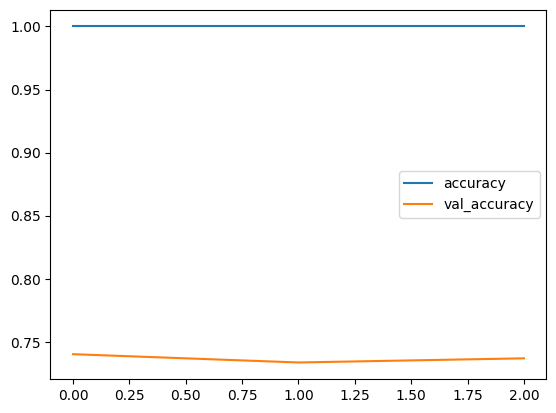

In [ ]:
df.loc[:,['accuracy','val_accuracy']].plot()

# Loss

<Axes: >

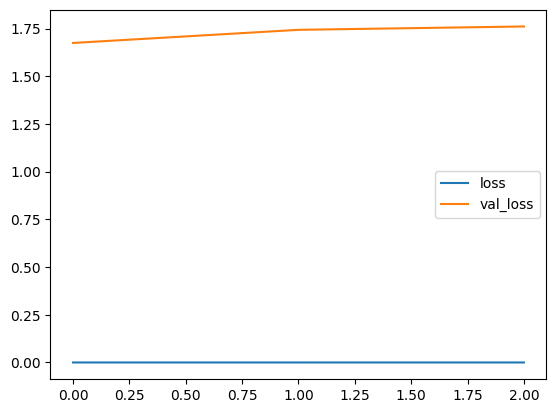

In [ ]:
df.loc[:,['loss','val_loss']].plot()

# Calculate ROC and AUC of each class

In [ ]:
from functools import reduce

res_true,res_pred,org_true,org_pred=[],[],[],[]
targetnames = data['class_labels']
for i,j in test_ds:
    predictions = model_res50.predict(tf.expand_dims(i, axis=0), steps=len(test_ds)/BATCH_SIZE, verbose=1)
    #geting predictions on test dataset
    y_pred = np.argmax(predictions, axis=1)


    y_true = np.argmax(j.numpy(),axis=0)#[k for i,k in test_data]
    #y_true = [np.argmax(k,axis=1) for k in y_true][0]
    print(predictions[0])
    #getting the predicted labels per image
    y_prob=predictions[0]
    #print(y_pred)

    res_pred.append(predictions[0])
    res_true.append(y_true)


 1/37 [..............................] - ETA: 46s

37/37 [==============================] - 1s 705us/step
[1.7045419e-05 3.8812081e-07 2.3676584e-08 7.4023217e-01 2.5974783e-01
 2.6034956e-08 6.9040653e-09 2.4588123e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[1.2099065e-08 1.1952980e-11 9.9948055e-01 1.9252468e-04 2.3752067e-08
 1.3425259e-04 8.7954227e-08 1.9253054e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[1.2464818e-12 1.0951920e-10 1.9753079e-09 1.0000000e+00 2.7091464e-11
 1.3571491e-10 1.4671354e-12 4.3634185e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 725us/step
[6.5478352e-13 1.0120048e-10 9.9920136e-01 1.4002665e-11 7.9865957e-04
 3.9435531e-11 2.3105005e-10 4.2976357e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[9.5981979e-01 1.4774963e-05 3.9192755e-02 9.8736042e-09 2.3211316e-05
 2.4660001e-06 5.1908313e-09 9.4694499e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[7.3975706e-08 4.2408761e-09 2.6028568e-11 1.3460244e-07 9.9999976e-01
 1.0853158e-11 4.4388671e-13 3.2835643e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[1.5198553e-01 5.0435513e-03 2.7917858e-07 3.8927332e-03 8.3906972e-01
 8.4379599e-07 5.4879074e-10 7.4342865e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[9.2872277e-08 5.1318733e-10 2.6900243e-04 3.8041499e-08 9.2666886e-07
 5.3189817e-09 9.9972993e-01 1.7064875e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[1.14942886e-04 4.59344210e-06 4.70241939e-05 3.07853490e-01
 2.72242958e-03 2.42649179e-07 6.75773570e-09 6.89257324e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[2.5639160e-09 8.0370222e-07 9.9922466e-01 1.6013174e-06 1.4256673e-07
 4.7539513e-07 3.9064343e-09 7.7227160e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[6.1462872e-04 9.9789077e-01 1.6412136e-07 1.3908751e-03 1.0327888e-04
 1.2960595e-08 1.4751545e-07 4.3276831e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 615us/step
[8.9991426e-13 9.3017472e-14 1.0000000e+00 7.5344120e-13 3.6402393e-15
 7.5647518e-13 1.4128033e-10 1.9100270e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 642us/step
[2.5709559e-07 2.2796648e-06 2.1272700e-04 3.0515676e-03 5.0937232e-10
 3.9165116e-06 8.8555630e-08 9.9672914e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 616us/step
[1.6631434e-06 1.1983104e-04 3.4403935e-02 1.8829529e-03 9.6224540e-01
 1.2972547e-03 2.3360070e-07 4.8705424e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 630us/step
[9.4757132e-07 1.3891697e-07 4.9139839e-03 9.9140185e-01 3.6652426e-03
 1.7022388e-06 3.9723400e-08 1.6061365e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 632us/step
[1.9766450e-02 9.8023349e-01 7.9182714e-09 1.1001830e-10 5.6618074e-08
 6.9269722e-11 8.2695001e-10 2.7704375e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 641us/step
[9.96600807e-01 9.42137202e-11 8.90926822e-06 5.38198839e-14
 3.39033967e-03 1.00070654e-13 8.36246870e-12 3.74113185e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 621us/step
[3.2990583e-06 3.9085517e-06 9.9898363e-03 2.4783790e-07 1.7832370e-08
 2.7062645e-08 9.9000275e-01 3.9341685e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 624us/step
[1.9310878e-10 2.7602776e-11 7.3705220e-10 9.9999988e-01 6.3584004e-08
 5.0460157e-11 4.5746939e-12 3.5853397e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[5.4291098e-07 2.2040194e-04 1.1760567e-04 1.5176771e-05 3.9780475e-06
 9.9359244e-01 6.0495650e-03 2.5768344e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 638us/step
[6.0017115e-08 8.8148688e-09 9.6443612e-03 5.6040739e-03 1.0339308e-05
 6.4299780e-07 5.1825032e-07 9.8473996e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[9.7303301e-01 1.7825443e-03 2.5043065e-02 1.6651575e-10 1.3404401e-04
 4.4599574e-07 2.2972293e-08 6.8321538e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 692us/step
[4.0737099e-08 6.9784269e-11 3.9421834e-11 1.4282403e-08 1.0000000e+00
 7.9494944e-12 2.0914368e-09 1.9221014e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[9.1874455e-05 9.9971229e-01 1.4273040e-08 1.9148737e-04 1.9537829e-06
 1.1095546e-07 8.4412353e-09 2.2288762e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 626us/step
[1.0000000e+00 2.5905608e-10 5.8610956e-09 6.8808919e-09 2.5459824e-08
 5.7881091e-12 8.0196856e-12 1.7839948e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 638us/step
[7.5145984e-01 1.5594102e-04 9.2117377e-03 2.8422193e-03 1.1311467e-02
 3.6420586e-04 4.7058438e-05 2.2460751e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 613us/step
[3.9355865e-07 1.4604323e-11 3.5432719e-11 7.1146367e-11 9.9999964e-01
 6.6933292e-11 1.2335023e-15 2.8170989e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 617us/step
[2.6861926e-15 1.6886803e-14 1.0000000e+00 3.3575590e-11 3.4523012e-10
 2.3706980e-14 1.2375645e-13 9.6190124e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 636us/step
[9.8286623e-01 2.2798339e-03 7.9249229e-09 2.4344632e-03 1.2418990e-02
 7.5243541e-11 2.0132653e-09 4.2006261e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[1.8518367e-20 3.0309146e-14 3.0482859e-20 2.6230465e-15 3.0936568e-20
 1.0000000e+00 3.0072182e-18 1.2677543e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[9.9947935e-01 5.2070763e-04 5.3310674e-15 4.6028415e-12 1.6597772e-11
 1.6066804e-12 5.0415537e-14 2.4717674e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[3.9238148e-07 9.9992812e-01 6.0248563e-05 1.9281883e-07 7.7418031e-07
 1.9824184e-07 8.2907370e-09 1.0159521e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[9.9424249e-01 5.7744442e-06 3.3683948e-05 2.0535840e-08 1.2294824e-05
 5.9008981e-10 2.9765466e-09 5.7057529e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[1.5912805e-06 9.9997675e-01 1.9061948e-11 2.1444092e-05 2.6483806e-07
 1.6129748e-08 4.2010497e-12 2.4679687e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[9.9865109e-01 4.3364670e-07 4.5955638e-08 2.4445728e-05 1.3081200e-03
 5.0867186e-08 2.1014607e-07 1.5604881e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 640us/step
[1.3517791e-07 3.3605420e-07 8.2831877e-01 1.5396085e-01 1.8198767e-05
 7.8294361e-03 3.4168686e-06 9.8688705e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[9.0846680e-10 1.5221125e-09 6.7988705e-11 1.7268611e-04 9.9982721e-01
 1.5681557e-08 1.2016373e-13 6.7928795e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[9.9198711e-01 2.2599665e-05 8.9251229e-10 7.3939287e-07 7.9896003e-03
 1.0922621e-08 4.7687939e-12 2.0839320e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 611us/step
[6.0999582e-08 3.4349734e-09 1.5107762e-03 9.9793577e-01 6.6088335e-09
 7.9717291e-09 1.8170923e-08 5.5324589e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[2.7244498e-05 9.9997258e-01 8.0822105e-08 5.2092098e-11 7.6829730e-11
 2.8813103e-09 5.8652705e-10 3.8381711e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[8.1895333e-04 4.3407049e-08 2.9573457e-07 2.8102980e-09 9.9918050e-01
 2.9581815e-10 2.2619894e-11 2.2148373e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 633us/step
[5.6664725e-05 9.9994063e-01 4.7724717e-07 5.3339568e-07 2.5702154e-09
 4.4540339e-08 1.1803697e-09 1.7258450e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[5.3708987e-07 2.0883887e-08 1.0628628e-03 1.2364931e-06 9.9892300e-01
 6.5513954e-09 1.0658449e-09 1.2300415e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[1.1140224e-12 1.0166062e-13 9.9999690e-01 1.3212775e-12 1.1709037e-09
 2.4589911e-10 3.0830017e-06 2.1781544e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[2.00625383e-09 3.74777348e-10 7.18618433e-15 1.05420645e-14
 1.00000000e+00 8.75007857e-13 4.08311555e-15 9.36773554e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[3.9728237e-03 9.1882457e-06 2.4124124e-04 2.9014449e-05 4.7226954e-01
 2.2800182e-06 5.0325082e-07 5.2347535e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 624us/step
[1.6837814e-07 9.9999988e-01 2.5777774e-12 6.6682560e-14 2.6984517e-10
 2.0772566e-12 9.7232498e-13 1.7652102e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 646us/step
[1.30542404e-07 2.04662001e-06 9.04950502e-05 1.12040084e-07
 8.61717343e-01 1.37725279e-01 4.38400166e-04 2.62036065e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[1.4044907e-03 9.9859554e-01 5.4932030e-13 1.4881720e-12 2.9138982e-09
 2.7501994e-11 3.4047012e-11 2.5149669e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 771us/step
[3.0621160e-07 9.9999964e-01 2.9060316e-09 5.3139764e-09 3.0271945e-09
 9.4707388e-11 1.0192802e-10 2.6317068e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 724us/step
[5.2207294e-11 1.0939044e-08 3.6336033e-07 9.9999952e-01 1.3667463e-07
 2.7123819e-11 1.6025839e-13 1.8710824e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[5.2968156e-01 4.6224484e-01 6.0994588e-03 4.9351804e-08 1.0156597e-03
 5.1153634e-06 3.8152362e-07 9.5294864e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 633us/step
[1.26815650e-11 1.29355213e-13 1.00000000e+00 4.18513965e-14
 1.41023095e-08 2.98535475e-13 2.89546490e-13 8.74438230e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 643us/step
[2.1785391e-09 7.8630661e-12 9.9999928e-01 5.9852010e-07 1.3514131e-07
 2.8421770e-11 2.7539090e-10 5.2748607e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[6.4077534e-02 9.3591678e-01 3.7699563e-10 3.4240186e-06 1.8781336e-06
 1.8109297e-10 5.7084275e-11 4.0801160e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[1.1371720e-03 7.7497600e-07 2.7446478e-04 4.2977899e-08 9.9858749e-01
 7.6385398e-08 1.7315426e-08 8.8888158e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 719us/step
[9.07930911e-01 8.62019137e-02 9.45179157e-10 3.09083089e-06
 3.99230776e-05 1.00813195e-05 6.20879419e-08 5.81388874e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[9.8797875e-07 8.2449980e-05 9.4816124e-01 6.0431664e-03 4.5640934e-02
 8.7555861e-07 4.9945953e-05 2.0531565e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[7.4350057e-12 8.0234681e-09 1.3113326e-07 6.3716398e-06 6.4769146e-09
 4.0418809e-06 4.8521829e-11 9.9998939e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[1.1865143e-06 9.8263527e-06 9.5755357e-01 3.5262369e-06 4.9473613e-04
 4.1917801e-02 1.1971991e-07 1.9284273e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[1.7063384e-08 4.2519184e-13 7.0257333e-06 5.9050341e-11 1.2526913e-12
 2.3437158e-13 1.6808600e-10 9.9999297e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[3.7159187e-15 1.0065572e-09 6.0465433e-10 1.0000000e+00 4.5625914e-08
 9.5656879e-15 1.9853729e-14 1.5450168e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 789us/step
[1.6761376e-02 9.8323834e-01 1.6923057e-07 2.9931140e-08 7.1645927e-12
 2.0655637e-09 2.6849255e-11 3.5080691e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[3.14767179e-12 4.00153976e-06 1.15559855e-08 3.51467952e-11
 1.63915773e-11 9.99995947e-01 5.90195004e-09 1.40605083e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[9.0844601e-01 1.9028988e-07 8.0968365e-02 8.9305637e-08 1.0583364e-02
 1.9356359e-07 8.3982508e-07 9.3240106e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[3.8751477e-06 2.7418272e-07 9.9998498e-01 1.0844375e-06 9.6492495e-06
 2.0672881e-09 1.4400953e-09 9.7720253e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[2.6494252e-05 5.4010883e-08 9.9997234e-01 9.3061988e-07 5.5552924e-08
 1.3883256e-09 8.8540965e-08 6.1935204e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[1.7949450e-09 5.3767429e-10 9.9535394e-01 2.0437636e-03 1.8580909e-03
 4.9517792e-05 3.4110053e-07 6.9442345e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[1.0907549e-11 6.2987823e-08 1.8215012e-05 9.9998069e-01 1.7270370e-08
 3.2089004e-10 1.7206458e-11 9.3232347e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[1.1868521e-09 9.9811437e-08 1.9404648e-05 6.2893615e-03 4.7480339e-07
 4.2093961e-06 1.3259221e-07 9.9368626e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 746us/step
[6.94231395e-10 1.06633546e-04 5.12584153e-09 8.09081306e-04
 3.74326964e-06 3.42943821e-07 2.73041731e-08 9.99080181e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[2.6453183e-08 4.3994090e-11 2.8726393e-11 4.9893933e-09 1.0000000e+00
 6.0708513e-12 7.8518312e-12 4.4413712e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[9.8943257e-01 1.0536694e-02 2.9950577e-05 1.4001905e-09 1.3126563e-08
 2.4940622e-10 1.1862990e-10 8.0886451e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[1.68925463e-09 1.00000000e+00 2.13690177e-12 1.05535077e-11
 1.21497298e-10 1.18754303e-11 1.11890816e-13 1.16841981e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[9.1974135e-07 2.7966092e-09 9.9984968e-01 3.3292689e-09 3.0088815e-06
 2.3107239e-08 1.4562369e-04 7.1229118e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[6.1787035e-02 8.3449774e-04 8.8898392e-05 1.8171107e-03 8.5784483e-01
 6.3648120e-02 4.3382504e-05 1.3936132e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 743us/step
[6.80386358e-10 2.75714065e-12 2.01079997e-14 2.79026108e-10
 1.00000000e+00 7.80252361e-15 1.09308086e-16 1.52561338e-17]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[2.3267258e-10 2.9994035e-11 9.9999988e-01 1.2102311e-07 5.6586842e-13
 2.4228371e-11 5.4655769e-10 8.1604939e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.3279975e-05 9.9998617e-01 8.4135610e-10 2.3389042e-09 1.2660979e-09
 2.4138305e-07 6.6006811e-10 4.1153197e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[1.9310030e-14 1.0000000e+00 6.5863370e-17 1.2132529e-13 6.2644704e-19
 6.3598210e-19 2.6461807e-16 1.1120701e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 754us/step
[9.9988925e-01 8.9372399e-05 1.5681056e-09 2.4898857e-06 1.8845358e-05
 4.4182977e-10 6.1167443e-10 3.7946240e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 741us/step
[1.2120864e-07 9.9999928e-01 8.3469220e-10 3.2339017e-07 2.1060597e-08
 2.3719077e-11 4.8920068e-10 2.0194247e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 809us/step
[1.5969219e-03 4.3644591e-06 9.9777454e-01 8.0873237e-05 1.7272598e-04
 4.7598130e-09 1.1019010e-10 3.7043364e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 826us/step
[1.27552189e-02 3.28878680e-09 9.70748663e-01 1.98820089e-06
 8.90879484e-04 1.27538300e-07 5.75187009e-08 1.56030385e-02]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 863us/step
[9.7697033e-12 5.2667933e-06 1.7907166e-04 9.1194350e-01 8.7866962e-02
 4.8536675e-10 1.2886482e-09 5.3208428e-06]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 1ms/step
[9.9999988e-01 2.3815844e-10 1.6424197e-10 3.1128938e-12 5.5888275e-08
 5.3014003e-14 4.4518358e-15 4.9562430e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 721us/step
[2.3610316e-09 1.2022805e-04 9.8843675e-04 7.6175225e-01 2.3711637e-01
 2.1368727e-07 9.3237922e-08 2.2406795e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[9.9990273e-01 2.3237201e-09 6.3991564e-07 3.2456651e-06 9.3224997e-05
 1.0698148e-08 1.7465737e-10 4.9218897e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 750us/step
[7.73684382e-01 1.24356985e-01 5.49363380e-04 2.83005022e-07
 1.01290330e-01 4.60007832e-05 7.15599672e-05 1.12302871e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[2.4511104e-08 9.7635632e-12 9.1093051e-01 4.4690276e-12 2.8443029e-12
 1.5886133e-08 1.3633782e-10 8.9069441e-02]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 662us/step
[9.6544133e-09 2.8651749e-11 4.9150239e-11 1.4746354e-07 9.9999988e-01
 1.9952470e-10 3.7879197e-16 2.0350701e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 628us/step
[8.2821966e-10 7.2258516e-08 3.0583117e-04 9.0980455e-03 1.1488039e-05
 1.0601970e-08 4.4818926e-09 9.9058455e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[1.9191428e-07 9.9999905e-01 1.9532467e-09 7.6197921e-08 1.0932776e-09
 8.0939635e-08 1.5545781e-09 4.8798188e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[9.69393881e-08 6.82978725e-06 3.17324270e-06 9.68347669e-01
 1.40664405e-08 1.82188717e-06 1.04866980e-03 3.05917840e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 640us/step
[1.24562948e-05 9.99983788e-01 2.57590373e-11 2.07473760e-11
 3.79719154e-06 4.05419170e-10 1.01747506e-10 1.18866310e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[1.04349404e-07 2.89854594e-08 3.14396690e-04 3.29219461e-06
 8.63477123e-10 1.47498085e-07 2.32663044e-09 9.99682069e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[4.1901227e-03 4.9445488e-02 3.7995353e-01 1.6843547e-05 5.5991435e-01
 3.0611332e-05 6.4457674e-03 3.1728355e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[2.9867191e-08 1.4556051e-06 5.8273667e-07 3.3181545e-06 1.2867621e-11
 3.7920792e-08 1.0331904e-09 9.9999464e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[6.2628479e-12 1.2847276e-10 9.9999869e-01 1.2566870e-06 3.1392278e-11
 1.1158103e-09 3.9660347e-10 1.2259109e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[5.6360528e-05 7.5508746e-09 2.1026795e-05 2.0668443e-08 3.6101689e-08
 4.5537774e-08 2.3074332e-05 9.9989939e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.6014695e-13 3.6742195e-10 1.0000000e+00 1.4342542e-08 1.3281170e-11
 6.3426847e-10 5.7589128e-13 3.0281222e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 711us/step
[2.1342806e-14 5.8574516e-13 5.7664284e-10 1.0000000e+00 2.0965580e-12
 1.1984652e-15 1.0561703e-15 4.8943433e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[3.2160049e-08 9.9999976e-01 1.5352112e-09 2.9370213e-08 1.3622119e-07
 2.9169706e-10 2.2838049e-09 5.0526296e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[2.0874045e-06 9.9998832e-01 9.5871555e-06 3.8581843e-15 1.2703781e-08
 2.6975599e-11 1.4159689e-08 5.9864907e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[7.1702343e-05 1.9793685e-08 9.9992824e-01 1.3693213e-10 3.8152454e-08
 7.6123850e-11 1.1603853e-09 1.5903792e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[1.3945556e-04 4.1977382e-09 5.5216688e-06 5.4817326e-07 2.2645749e-07
 1.4906821e-08 4.1421039e-13 9.9985421e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[3.1957643e-03 3.0459344e-06 3.4620734e-05 5.8111171e-05 9.9670118e-01
 1.4482572e-07 2.0681183e-09 7.1794916e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 658us/step
[9.9999917e-01 7.1699833e-07 3.5642372e-10 1.5669322e-13 1.0091475e-09
 1.0385167e-11 5.1231534e-13 1.1443137e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 736us/step
[3.4820435e-03 3.9604288e-07 5.1097879e-07 8.9477072e-04 3.6155379e-06
 7.2309089e-11 8.5318023e-11 9.9561864e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 726us/step
[1.0000000e+00 1.0416018e-08 6.8414248e-16 1.7593397e-13 2.2558855e-09
 4.3040081e-12 2.9819072e-16 1.8709609e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[4.1283539e-12 2.5686207e-11 1.0000000e+00 1.1687998e-11 2.6184103e-13
 2.3094736e-10 1.3419705e-09 6.1047083e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[9.6199477e-01 1.2745111e-06 4.1469761e-07 2.8639346e-07 3.8003206e-02
 7.3196371e-10 6.9048400e-10 9.2894270e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[5.9475212e-07 9.9995327e-01 2.4414516e-05 1.1966091e-06 1.8601166e-05
 1.8357728e-06 2.1157601e-10 3.3604376e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[1.9310598e-01 3.1960528e-02 2.6877834e-03 5.9640151e-04 3.0020875e-01
 3.1917132e-06 1.3864482e-06 4.7143602e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 829us/step
[6.7291709e-05 9.9993265e-01 1.9190966e-12 7.1092368e-11 3.9621405e-08
 1.5083129e-10 1.8621253e-12 1.9730604e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[1.0866285e-06 9.9999869e-01 4.5387658e-09 3.4584360e-08 1.6683181e-07
 2.3109138e-08 6.3615437e-09 5.1451387e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 640us/step
[6.2287960e-08 3.8237161e-07 3.2418950e-05 6.8533788e-03 2.2295671e-05
 1.9692417e-05 1.1483999e-05 9.9306023e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 639us/step
[2.32212744e-14 3.64388589e-11 1.45128284e-11 5.51496904e-11
 5.81214384e-13 2.02197157e-07 9.99999762e-01 1.09054476e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[1.4408710e-05 1.1908020e-03 2.5301592e-08 7.1485357e-07 9.9879408e-01
 2.1600102e-09 1.1155258e-08 5.7052774e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[9.8602563e-01 1.1033331e-03 1.4881599e-06 1.8146459e-04 1.2688099e-02
 2.5248312e-10 2.5645172e-11 3.5834304e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[1.6018687e-04 9.9980992e-01 1.5500978e-09 4.6294368e-11 2.1126745e-10
 2.8862649e-05 9.0351931e-10 1.0645863e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[1.49689883e-03 3.69358238e-10 4.00072604e-04 1.67712496e-05
 9.98086333e-01 1.51654367e-09 2.22841301e-08 1.09029496e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[6.9420317e-08 4.0431623e-06 2.4411258e-07 9.7943158e-08 9.9999547e-01
 1.2786164e-07 6.5372103e-09 3.9093454e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[1.1403740e-07 5.6671124e-04 7.0804425e-09 9.8803931e-01 1.1393507e-02
 6.5872129e-08 2.6025379e-10 3.2907434e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 749us/step
[3.0538242e-06 6.1216033e-03 7.8375989e-01 1.7666358e-01 2.7973443e-02
 2.9526479e-03 2.4600707e-03 6.5717439e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[3.32053527e-02 3.72090483e-08 1.02994155e-10 1.67413473e-13
 9.66794610e-01 9.32970975e-12 3.83277785e-12 2.67715894e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[9.5729220e-01 1.5084036e-03 5.9951800e-11 2.2458607e-02 1.8733060e-02
 1.3693174e-09 8.8209506e-10 7.7558743e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[8.4699838e-09 5.4331077e-09 9.9999952e-01 6.3109353e-09 2.8861677e-07
 4.2645624e-08 7.9265682e-08 1.1717849e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 735us/step
[2.31525529e-14 1.06951237e-09 2.35747000e-09 2.82419403e-08
 2.33729303e-11 1.00000000e+00 1.43912375e-08 5.10586240e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 631us/step
[9.9998236e-01 4.8893772e-10 1.9015672e-12 7.9792528e-15 1.7670340e-05
 1.0263791e-14 2.4292748e-13 2.1183219e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 637us/step
[9.9989188e-01 5.6680628e-06 1.8591147e-06 8.6272817e-10 9.4955751e-05
 3.8146531e-13 2.6640709e-11 5.5078181e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[1.5182286e-08 3.9261280e-08 8.7995201e-11 8.5695860e-11 8.7736618e-07
 3.1387404e-10 9.9999917e-01 4.0474507e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 658us/step
[9.9991107e-01 1.6292753e-07 1.4800332e-10 4.3672969e-12 8.8853980e-05
 7.8819853e-11 7.6171014e-12 3.3876554e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[5.2105406e-06 5.8069318e-08 5.9679450e-10 5.2118341e-13 6.6981713e-08
 1.4634442e-12 9.9999464e-01 1.0069111e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[3.2948074e-01 8.1518323e-05 4.9216199e-14 8.5414287e-10 6.7043775e-01
 3.9637758e-11 3.3601922e-14 8.5397542e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[2.6531372e-10 3.2273371e-11 1.6477222e-10 9.9999976e-01 2.7125873e-07
 1.6672379e-13 1.3147563e-14 8.6939815e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[9.0518087e-01 6.7459157e-04 1.5717692e-08 2.3832156e-07 9.4142273e-02
 1.3527718e-06 4.6079733e-12 6.5594747e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 701us/step
[9.9999619e-01 3.0848876e-06 2.8792208e-08 5.0488353e-08 3.9136921e-07
 2.0030383e-07 1.2000586e-09 4.0560174e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 775us/step
[5.0825661e-01 1.6878936e-02 9.2483443e-10 3.2903502e-09 4.7486135e-01
 1.1574949e-07 4.4334469e-09 2.9235425e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[2.52806731e-09 1.00000000e+00 6.43487624e-11 3.08897324e-10
 2.25594876e-10 1.74799430e-09 1.35118704e-11 7.45094930e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 753us/step
[2.2548031e-07 1.5781113e-08 1.2095156e-05 4.1822227e-06 1.1338641e-05
 2.3971248e-08 1.0834640e-10 9.9997211e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 830us/step
[1.2519284e-08 5.5949540e-06 2.5726127e-04 9.9973649e-01 1.4531000e-07
 4.1378743e-07 6.2703130e-08 9.8530366e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 701us/step
[1.0000000e+00 2.3932054e-10 6.1707241e-12 1.2539575e-12 1.8024302e-08
 1.3578590e-13 2.2376840e-14 2.1071578e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[1.2641683e-12 1.3262961e-08 1.4394607e-07 1.1496316e-09 5.6629089e-12
 9.9999988e-01 2.4038658e-09 3.0769627e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 696us/step
[1.2806451e-07 9.9999964e-01 6.8522960e-10 1.7630301e-10 2.6361997e-07
 3.4421482e-10 6.4915590e-10 6.7606583e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[9.8494357e-01 1.2767967e-04 8.5172996e-06 3.7183750e-06 5.3514461e-03
 4.4057646e-08 9.4256178e-03 1.3947512e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[8.1520682e-07 9.9999917e-01 3.4224776e-08 6.8383313e-11 1.4206316e-12
 2.6845495e-09 4.7322380e-12 7.5772014e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[2.2580547e-08 6.2641320e-06 1.4676066e-06 3.9605066e-09 9.9997270e-01
 1.3298071e-05 1.8468029e-06 4.3030132e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[2.59084209e-06 1.90223510e-12 5.04138879e-03 1.09448735e-11
 1.70056053e-11 4.97903802e-13 6.18113005e-10 9.94956076e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[1.1376585e-13 6.5287309e-16 1.0000000e+00 3.8857641e-21 5.2129870e-16
 8.1614106e-18 6.8048983e-11 9.4318453e-21]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[1.3919224e-04 9.9819285e-01 3.3898553e-04 2.6457397e-05 6.1434854e-05
 1.4853183e-06 1.2654256e-07 1.2394385e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 704us/step
[2.5547180e-01 7.3040813e-01 2.0223256e-08 4.9094223e-07 1.4115357e-02
 1.2221963e-07 1.3485398e-08 4.0766599e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[1.7011553e-04 1.4873738e-04 9.3479759e-01 1.3835340e-02 5.0805479e-02
 1.1084026e-04 1.0974238e-04 2.2242933e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 658us/step
[7.1617399e-07 8.2975655e-04 4.9575248e-01 4.4829318e-01 3.8165773e-08
 2.1166277e-04 1.8468493e-06 5.4910392e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 712us/step
[4.4697026e-05 9.9993932e-01 1.5931273e-05 2.0242837e-11 1.9560600e-09
 1.8273097e-11 1.7749207e-11 1.7893697e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 729us/step
[1.6830616e-01 3.6393064e-01 4.6709636e-01 2.2347943e-07 1.3657489e-06
 2.5298723e-07 4.1670898e-09 6.6505547e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 643us/step
[3.7459625e-04 1.0423998e-08 1.8787369e-10 1.5459824e-07 9.9962521e-01
 1.5941477e-09 5.8369056e-12 3.2075287e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 710us/step
[8.8713691e-03 7.1240582e-02 6.1650958e-06 1.6297885e-05 9.1984195e-01
 1.2532506e-05 4.9369560e-06 6.1936180e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[6.5966153e-01 9.3221615e-06 7.1162768e-02 3.3332375e-07 2.6557413e-01
 2.8845407e-06 3.5875123e-03 1.4751180e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[1.3343908e-05 3.1747986e-06 4.6139705e-09 6.6483537e-12 9.9998331e-01
 1.6210651e-09 6.7842940e-08 3.8122491e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[8.0885393e-06 5.2907674e-09 9.8108655e-01 1.8838216e-02 1.6229274e-08
 3.6371059e-09 5.0784048e-09 6.7101224e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 710us/step
[1.1598344e-01 8.8077068e-01 3.3121253e-07 4.0640784e-06 3.2391453e-03
 2.9809172e-07 3.8633424e-08 1.9426607e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 717us/step
[1.4557746e-07 3.3271852e-05 9.9890280e-01 1.0089887e-03 8.9979631e-06
 9.5770411e-06 1.7453598e-06 3.4471177e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.0940970e-08 1.0000000e+00 4.5542850e-13 3.5238668e-09 1.3777226e-09
 5.2883488e-12 2.3015899e-13 8.2615633e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[3.9161321e-08 3.6737536e-12 6.8938016e-10 8.3001455e-13 1.0000000e+00
 4.0030171e-12 2.4185653e-12 2.0885426e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[4.2221905e-07 1.3702177e-11 5.8536143e-14 2.9784870e-14 9.9999952e-01
 7.3247052e-14 1.3628447e-14 4.2323267e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[9.9999988e-01 1.1672842e-12 5.7364167e-13 2.3445177e-18 7.7494533e-08
 9.0052452e-15 4.4444734e-14 8.8698809e-18]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[6.9931243e-04 1.2700691e-07 3.8407953e-03 2.2161107e-01 7.7376831e-01
 7.9611855e-05 6.4925857e-08 6.9525834e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 751us/step
[6.8176484e-01 7.0728935e-02 3.1306069e-12 2.4750496e-01 3.0678567e-07
 2.8203209e-09 3.4522583e-11 9.0559001e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[2.9272197e-02 5.1438862e-01 2.6271896e-02 1.0974910e-04 4.2988965e-01
 5.5490927e-05 1.6033509e-06 1.0762415e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[1.1089193e-06 6.6869688e-10 3.2546995e-05 4.9511640e-04 3.2070723e-06
 5.5708592e-06 1.1346963e-09 9.9946243e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[9.9997413e-01 2.5826612e-05 2.3998457e-09 6.1944706e-11 5.7895105e-10
 1.1594285e-11 3.2313245e-12 1.9451798e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 645us/step
[7.6641574e-13 3.1426684e-11 9.9997437e-01 2.8532764e-07 2.5425534e-05
 1.5499885e-10 8.4204932e-10 8.1754017e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[2.6052030e-10 2.1787483e-09 2.4301419e-10 5.2609409e-13 2.7349230e-08
 1.0000000e+00 5.5130513e-09 1.7567807e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 713us/step
[7.3169819e-03 4.2179797e-09 6.9077100e-10 2.0267330e-09 9.9268299e-01
 4.3157753e-09 1.4305103e-12 3.7867716e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[1.94038297e-12 1.62131628e-11 8.01875995e-14 1.06233633e-15
 1.49928663e-11 1.02205116e-13 1.00000000e+00 1.61050245e-17]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[2.45543669e-10 1.77096796e-10 2.16483069e-03 9.85864401e-01
 5.22959211e-11 2.54265720e-09 1.73275366e-10 1.19707845e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 742us/step
[1.1138569e-05 9.9998879e-01 2.7911918e-11 2.9902056e-09 8.3909063e-10
 7.4020470e-08 5.7857399e-11 1.6149798e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[1.2162356e-08 6.7479416e-10 2.0391278e-12 6.5033340e-14 1.0000000e+00
 3.0264724e-10 3.9907223e-11 3.2943561e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 682us/step
[1.9027284e-14 6.8450857e-12 9.9998927e-01 1.0779376e-05 1.0666314e-11
 4.2642681e-11 8.2869146e-12 7.1534646e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 687us/step
[7.1057869e-04 9.9928856e-01 3.6486184e-13 7.5913604e-09 7.8360807e-07
 7.7261218e-11 7.3587846e-12 1.9713133e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 745us/step
[9.9994874e-01 5.1279552e-05 2.2352586e-09 5.9541018e-12 3.6829245e-08
 9.4956565e-10 7.5490326e-12 8.7592777e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[1.4514079e-04 8.6141364e-13 1.0051956e-18 1.2376120e-15 9.9985445e-01
 2.9709849e-11 2.7035733e-16 3.5061217e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[2.9279339e-09 4.8202719e-07 1.4228737e-03 9.9565578e-01 1.8430463e-05
 2.9136251e-07 2.2058501e-07 2.9019397e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[5.1834235e-07 9.9999869e-01 9.6904804e-14 7.6761531e-12 2.3360855e-12
 6.7127070e-14 1.0457923e-09 8.8352965e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[1.8453208e-07 1.7228332e-06 5.4359534e-10 3.9232180e-11 1.2424607e-07
 4.5482075e-06 9.9999344e-01 2.5302383e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[8.6433124e-07 9.9999785e-01 1.6108734e-10 3.2184027e-09 2.2673591e-13
 9.7851704e-08 1.9875919e-11 1.2621435e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[9.9957007e-01 3.2513816e-04 1.9579544e-05 1.1656976e-07 7.7307544e-05
 5.2697519e-10 2.4164180e-09 7.7781988e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 738us/step
[2.2118248e-02 2.9553059e-05 9.6810794e-01 3.9735343e-07 9.5699383e-03
 2.5435498e-05 4.8728084e-06 1.4360267e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 778us/step
[3.2626690e-09 1.2434712e-07 9.9999774e-01 1.5460106e-08 4.3750865e-07
 1.2786400e-09 1.9479498e-09 1.6825552e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[2.1243085e-12 1.0665928e-10 1.4366236e-05 2.2450266e-03 7.8941978e-11
 1.3639144e-10 4.7006721e-10 9.9774063e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[3.5261800e-07 2.0669138e-05 9.2781186e-01 2.5727600e-02 4.6422616e-02
 1.6874470e-05 8.6683025e-09 1.1981565e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[9.0604126e-02 7.3042077e-01 9.0112574e-02 5.6252904e-02 3.2241035e-02
 3.3258920e-04 3.5872818e-05 1.8564447e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 951us/step
[2.4606272e-13 1.1074961e-12 6.7927148e-09 9.9999988e-01 6.5070799e-14
 1.0878760e-10 3.3160914e-13 1.1014656e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 725us/step
[9.5377551e-08 5.0374840e-08 8.5936277e-13 8.4260856e-15 4.2153000e-11
 2.1346501e-11 9.9999988e-01 1.2186886e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[4.1560508e-13 1.0950942e-09 7.0729853e-09 9.9999988e-01 1.6771057e-10
 1.3082480e-10 1.6826157e-11 1.7250169e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 653us/step
[2.1866089e-11 4.7802307e-11 3.3841518e-09 6.7032164e-07 8.1094792e-12
 8.1119382e-12 4.4709523e-12 9.9999928e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 642us/step
[9.9748707e-01 3.4676467e-12 4.5527493e-08 1.2354034e-10 2.5128159e-03
 3.7438368e-13 1.9561372e-13 7.1908005e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.9253426e-07 9.9997902e-01 4.6628007e-10 8.0943772e-07 1.9915109e-05
 5.4721307e-09 2.6730490e-10 7.3304860e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 634us/step
[3.8420694e-07 1.7544238e-07 9.9995685e-01 1.6243435e-05 1.1112679e-08
 2.6230291e-05 5.3457022e-08 1.0862877e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[7.7490032e-02 1.8765496e-02 7.7334545e-05 4.4632405e-05 9.0362060e-01
 2.9554252e-07 1.5570797e-06 3.9240099e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 700us/step
[9.9987841e-01 8.0569298e-05 2.3142138e-11 1.6446417e-12 4.0948646e-05
 1.8193317e-15 6.0511093e-12 1.3318009e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[1.2874391e-07 3.6594980e-07 9.7139919e-01 2.1050264e-04 6.9024935e-07
 4.0833779e-06 7.9194859e-07 2.8384274e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[2.7330882e-06 6.4989257e-07 1.1711572e-06 9.9917185e-01 6.0844928e-04
 1.1973587e-07 5.5813540e-09 2.1505452e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[1.0000000e+00 5.4736051e-12 9.3973447e-11 1.8783732e-10 1.7151311e-08
 1.2422453e-12 1.8802215e-15 9.0782221e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[7.4712938e-05 9.9976784e-01 3.6072802e-07 1.5867818e-05 1.5833169e-09
 3.7615885e-07 8.4500885e-11 1.4088246e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[2.4270216e-08 5.1888424e-08 1.0307555e-08 4.3361504e-12 7.7883878e-06
 4.4090346e-11 9.9999213e-01 5.0518557e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 711us/step
[1.9805937e-06 1.9786521e-05 1.0552489e-05 9.8842746e-01 3.0014147e-05
 1.2187850e-06 9.4090353e-09 1.1508943e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[3.4388378e-01 6.5611625e-01 1.7628542e-08 6.5273988e-12 1.4826300e-08
 2.4675964e-10 2.7282185e-11 1.9830097e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[9.8255968e-01 1.7440328e-02 4.9553786e-13 4.1669762e-10 1.0237868e-09
 2.9089165e-11 5.7858635e-12 2.6860208e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[5.8108384e-08 7.6025171e-05 5.0773963e-09 4.4563636e-05 9.9987936e-01
 2.2735309e-08 7.5649834e-12 1.6212336e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 895us/step
[1.2124975e-11 3.5746819e-11 8.0175141e-08 1.3270983e-08 1.5139830e-10
 9.0354280e-10 1.1294155e-11 9.9999988e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[6.9455517e-04 7.1284799e-03 7.2995491e-08 8.5494304e-01 1.3651901e-01
 5.8864334e-06 2.5113504e-08 7.0884119e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 746us/step
[1.0190132e-02 2.4121246e-07 9.6895744e-04 2.7291162e-04 9.8468345e-01
 1.0316558e-06 3.8776575e-06 3.8794316e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[1.1058051e-02 9.8894191e-01 1.5042966e-15 2.5547568e-17 9.6692999e-14
 6.5907689e-11 5.4023788e-13 8.2758778e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 708us/step
[6.9338983e-01 3.0661017e-01 2.8194705e-11 7.4637883e-12 1.3925124e-09
 6.4699591e-13 3.1329792e-13 5.7741069e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[2.5687568e-06 2.6964341e-05 1.1538754e-08 8.1929921e-09 9.9996650e-01
 5.1348648e-12 7.4069734e-10 3.9603069e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 748us/step
[9.2600300e-07 9.9999905e-01 2.1238598e-09 5.6064736e-11 1.8009103e-11
 9.1153002e-11 6.3164929e-10 2.6581143e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[3.2784516e-07 4.4011119e-09 8.6369371e-01 2.2943952e-05 1.3624862e-01
 3.2528613e-05 6.1281966e-09 1.8798747e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[9.9928892e-01 6.9881626e-04 4.2076923e-08 1.9081121e-08 1.1905292e-05
 1.0705635e-09 2.0820106e-07 6.4515639e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[2.8095462e-03 4.5916685e-03 1.6697826e-02 1.8918571e-01 3.9702505e-03
 8.0901582e-04 1.1474398e-06 7.8193486e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[1.7244096e-08 3.6264085e-09 6.5819966e-04 9.9909568e-01 2.4392868e-04
 2.5443328e-10 8.7488344e-10 2.2595650e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 627us/step
[9.4541855e-04 1.1044891e-03 3.7372798e-01 5.2663618e-01 5.4580057e-03
 1.8364877e-03 3.5125187e-05 9.0256326e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 755us/step
[9.4406950e-01 1.9245347e-02 9.0413370e-05 8.9518107e-06 3.6579393e-02
 3.4893296e-06 3.8451705e-07 2.5607142e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[2.7130256e-05 9.9997246e-01 5.0631799e-12 2.5049780e-09 3.0169591e-07
 4.7664578e-10 2.1710689e-12 8.6729332e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[1.1101307e-01 8.8888371e-01 1.4121541e-09 1.2371663e-07 8.6706874e-05
 3.4796634e-09 7.9355491e-09 1.6384776e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[3.4150633e-03 9.9345315e-01 5.0295165e-07 2.2292064e-04 2.9041176e-03
 3.8988474e-06 2.8838843e-07 1.0856520e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[3.0035371e-13 1.4061201e-12 2.2293165e-09 1.3240484e-04 1.3578728e-10
 1.7702784e-07 7.8550821e-10 9.9986744e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[4.7749323e-03 4.3864697e-05 4.2117119e-02 9.9309636e-07 9.5281553e-01
 2.1008950e-07 2.4715331e-04 1.3374799e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[3.6856350e-01 9.7420177e-04 9.3661567e-09 2.0669548e-09 6.3045704e-01
 3.7170875e-10 2.1551418e-10 5.1811458e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[1.5262061e-07 3.7541617e-10 3.7626621e-11 1.5190868e-12 4.9499341e-12
 2.5662770e-13 9.9999988e-01 5.4647346e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[1.4305998e-04 1.8485275e-07 3.2730249e-11 1.5738713e-08 9.9985671e-01
 3.2608776e-09 6.4938750e-14 1.2572064e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[1.7475051e-05 9.1608046e-05 1.8282049e-06 1.2410313e-01 1.2506392e-06
 4.9401641e-01 3.2812512e-08 3.8176832e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[3.6758519e-13 5.5728022e-09 3.5212541e-11 8.7927321e-10 1.9713700e-09
 9.9999940e-01 5.6109263e-07 1.0222164e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 713us/step
[9.6291333e-01 1.1104868e-06 6.0912403e-13 1.6148265e-11 3.7085522e-02
 3.7233498e-14 5.7943800e-10 3.1492800e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[3.2132238e-02 1.6913061e-01 7.8345275e-01 1.8782825e-07 1.5280535e-02
 7.1024090e-07 2.5837902e-08 2.9981040e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 712us/step
[2.2468110e-12 1.8426767e-10 6.5372856e-03 9.9345183e-01 1.0901296e-05
 3.7549450e-11 3.6552858e-11 1.8849647e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 636us/step
[9.4653664e-21 3.5382562e-22 1.4763662e-22 1.7801304e-23 1.0000000e+00
 1.7124105e-24 3.2665813e-27 1.2200450e-21]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[1.0741240e-05 1.2119464e-06 5.6366061e-05 5.8699091e-04 9.9933785e-01
 5.4340799e-06 2.9565516e-08 1.2975963e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[3.4199141e-09 1.0000000e+00 3.7259453e-12 4.6925558e-10 7.3458362e-10
 1.6829987e-10 1.2342237e-10 1.5625548e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[2.6858751e-07 9.9995208e-01 1.2491266e-05 2.5415954e-12 3.5136549e-05
 1.3253724e-09 1.9786361e-10 1.2943992e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[2.15165073e-06 7.80481514e-06 1.05797869e-06 1.08687000e-05
 7.45292485e-01 2.54494935e-01 7.39296447e-05 1.16865136e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[9.9998045e-01 1.4826175e-05 4.8185512e-07 3.4650281e-08 4.1265148e-06
 8.2930759e-11 1.4907732e-12 1.7177682e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[4.4297582e-01 3.4136345e-08 5.5600679e-01 1.2012887e-09 2.9481444e-06
 1.4137589e-07 3.8018762e-04 6.3406833e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[4.9676859e-05 5.2439043e-13 6.6169083e-02 1.6041274e-09 3.6315797e-08
 3.9038364e-16 2.3903183e-11 9.3378127e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[3.0066906e-03 1.0638498e-07 2.6908545e-08 2.2781192e-06 2.5956160e-05
 1.6384418e-07 1.0917429e-10 9.9696475e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[1.12539285e-08 2.05336141e-06 9.90639687e-01 9.30653512e-03
 5.09609381e-05 6.79351064e-09 1.30406946e-07 5.94871096e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[8.1982250e-08 1.6551958e-04 1.3329051e-06 4.3533825e-07 9.9983203e-01
 3.7407260e-09 1.6983432e-08 6.3849211e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[4.3700218e-01 1.0676639e-01 3.4775655e-03 3.0905831e-01 1.3449347e-04
 1.2298628e-01 8.5078391e-08 2.0574654e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[2.3571578e-08 6.6309451e-07 9.9777538e-01 1.5810550e-03 3.0127001e-07
 5.6480050e-05 5.8352808e-04 2.6358643e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 749us/step
[1.4447370e-08 1.0000000e+00 9.6305417e-09 4.3894933e-11 5.9197984e-09
 5.0823536e-11 3.6122121e-12 7.9732365e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[6.8698198e-09 3.3623230e-08 4.3812152e-03 9.9560308e-01 1.0318709e-05
 3.0494427e-08 2.4281690e-08 5.2980936e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[3.1834158e-10 1.1741467e-09 1.2271084e-09 2.6502505e-11 2.1366616e-06
 9.9999702e-01 5.5368349e-07 2.2604360e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[1.6882643e-04 9.9925011e-01 2.8629168e-08 1.5766089e-07 1.5759457e-09
 6.7439078e-07 9.4438062e-11 5.8014476e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[1.2147633e-03 3.5635939e-09 7.5102758e-01 5.1126297e-04 1.3448183e-06
 5.9974963e-09 1.0724091e-07 2.4724491e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 710us/step
[8.6652958e-01 1.3347036e-01 1.5544765e-12 2.3011358e-11 2.4285296e-10
 7.3278569e-13 1.0838254e-13 4.2406345e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[9.0553427e-13 1.0000000e+00 3.3820884e-17 8.8547374e-14 8.1741991e-15
 1.1990584e-17 1.3503214e-15 2.8201081e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[7.8152935e-04 9.8328120e-01 6.1555838e-06 6.2305917e-06 1.5923064e-02
 1.4476913e-06 2.2166410e-07 1.7927826e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[7.0124198e-11 3.7545626e-13 9.9999559e-01 7.4083900e-10 5.7309127e-13
 3.3916980e-10 8.5168343e-09 4.4464355e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 743us/step
[1.2301069e-09 1.0000000e+00 5.2712236e-14 4.8747759e-11 6.1349946e-14
 6.8330893e-13 1.9440012e-13 6.6057533e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[8.7235567e-15 1.0000000e+00 7.4294941e-17 1.3703787e-10 1.2935730e-15
 1.2509730e-17 1.0105886e-14 1.0637887e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[8.6168329e-06 5.4899085e-04 3.6871315e-05 7.5696105e-01 1.7844800e-04
 1.4636556e-06 1.7513312e-07 2.4226439e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 634us/step
[4.75539146e-08 9.01859323e-07 5.26997701e-06 9.99993086e-01
 4.32249095e-07 2.41658114e-07 1.33015305e-08 1.60211027e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[6.7090853e-09 5.2221859e-11 1.0000000e+00 8.3112777e-14 7.4167387e-13
 3.1900960e-12 5.8125282e-11 1.0424779e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[3.04339865e-05 9.16845693e-06 1.15711782e-06 2.18419149e-09
 9.99939322e-01 1.15134064e-07 3.82640155e-06 1.59747997e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 645us/step
[1.01942336e-04 3.22512954e-01 1.86257433e-11 1.21716084e-03
 6.76167965e-01 9.91534077e-10 1.19296422e-11 5.08673148e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 658us/step
[1.0416207e-03 1.6453985e-09 1.4458057e-08 4.3640380e-11 9.9438667e-01
 6.1514801e-13 1.6388890e-10 4.5717079e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 734us/step
[4.6771856e-08 6.6181536e-05 4.7007651e-04 1.3178436e-04 8.2758076e-09
 3.4670109e-07 9.9820966e-08 9.9933147e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[7.0094843e-14 4.1277691e-13 2.6989088e-11 4.1582146e-10 1.9392784e-14
 1.0063171e-13 1.0000000e+00 3.6704858e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 653us/step
[1.6541597e-04 9.5880187e-06 2.1121802e-04 2.3109046e-01 4.9552904e-07
 3.1682946e-06 3.0579606e-06 7.6851660e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 636us/step
[1.1938847e-02 1.6710575e-01 6.1210245e-01 2.5268109e-05 9.1849811e-02
 1.5125859e-04 1.1665096e-01 1.7561101e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[5.0467545e-01 4.6621913e-01 5.4210545e-08 9.7676124e-11 2.9105226e-02
 5.8714172e-11 8.2880888e-08 7.3450181e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[1.4993574e-08 1.8958977e-11 9.0892619e-01 8.9633927e-09 2.4204326e-06
 1.3377341e-12 4.3971275e-11 9.1071405e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 640us/step
[6.3452035e-11 6.4476868e-10 6.3792938e-10 7.0194361e-09 1.4987191e-07
 9.9985015e-01 1.0276466e-09 1.4970556e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 631us/step
[9.9999976e-01 2.7884292e-07 4.0325116e-16 1.3229829e-09 2.6412528e-09
 8.4534671e-11 3.8890840e-14 5.7184596e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[3.7523959e-04 9.9962461e-01 1.7747294e-09 2.4352303e-08 2.9491901e-10
 2.1543960e-10 1.7796301e-10 1.5869766e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 645us/step
[3.13774705e-01 5.69974661e-01 1.77219390e-05 4.29089821e-04
 9.69595476e-07 1.88212667e-04 1.32770985e-08 1.15614600e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 634us/step
[2.4988054e-05 1.0944220e-05 3.7235334e-10 4.4193587e-04 9.9951935e-01
 1.9776716e-09 4.1315534e-11 2.7712442e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 637us/step
[3.0000019e-10 1.9478099e-09 1.5863291e-07 9.9427950e-01 3.0036973e-12
 4.8607592e-07 3.4608039e-08 5.7197982e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[6.0903282e-14 2.9017725e-13 9.9999976e-01 1.9501194e-07 6.7140143e-12
 2.2098607e-13 5.2841705e-13 2.5679697e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 628us/step
[2.0166084e-08 8.7326701e-04 2.7757682e-10 9.9912435e-01 1.0754076e-06
 4.7561497e-07 9.7667729e-10 7.7739764e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[5.2409786e-07 9.9999952e-01 3.6326549e-12 8.9278300e-09 2.5191914e-08
 5.3530974e-10 8.9173044e-11 1.4476090e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 640us/step
[1.0000000e+00 5.6010202e-10 1.5696712e-16 2.0458486e-15 4.2822617e-11
 4.7424247e-16 5.8347510e-16 2.5839504e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[2.8170628e-06 1.7884997e-05 4.0631709e-01 4.6425614e-01 1.0086745e-06
 5.1927214e-05 1.7375602e-05 1.2933575e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[8.6107934e-01 1.3541642e-01 2.6676035e-03 7.3887219e-10 8.0195378e-04
 5.5596006e-06 1.0531911e-07 2.9096685e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[2.7177898e-02 1.9804466e-07 2.1879764e-06 2.4683625e-04 6.4617407e-01
 3.6256772e-08 4.0170992e-10 3.2639879e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[1.0291792e-09 1.4939031e-10 8.0713436e-10 4.9422374e-07 6.4106448e-10
 1.2703121e-12 1.2224562e-08 9.9999952e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[2.6859929e-08 1.0700402e-07 8.8237936e-04 9.9832135e-01 2.6532462e-07
 1.5816289e-06 7.9881755e-09 7.9433870e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[2.24209948e-08 6.34190442e-08 2.30142305e-09 7.95842138e-14
 9.99999881e-01 1.38475524e-11 1.55693611e-12 7.81486681e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[1.2504653e-06 3.9704150e-07 6.6934323e-01 2.7243985e-04 1.6532002e-07
 1.6312275e-07 9.5403768e-05 3.3028695e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[1.6521828e-04 2.1803403e-06 2.2264504e-01 5.8835721e-01 1.8822378e-01
 1.3641315e-05 1.3165882e-04 4.6120872e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[9.2215228e-01 7.3504746e-02 2.3888636e-03 3.0917021e-05 1.9072300e-03
 1.5830237e-05 5.3226149e-08 1.2461312e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 627us/step
[1.5811594e-09 1.2174454e-08 1.2071208e-05 9.9981564e-01 7.1123919e-11
 3.1837446e-09 1.4129424e-09 1.7231099e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[4.6007503e-12 4.0014051e-08 5.7674598e-10 9.9999571e-01 4.1023868e-06
 1.3019942e-10 7.5710559e-13 2.4774178e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[5.1639118e-04 9.9947661e-01 2.2261637e-09 1.4135123e-08 6.9285694e-10
 7.0593042e-06 5.7945271e-10 1.4770738e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[2.4572022e-12 9.9999678e-01 6.4942713e-12 3.2726118e-06 5.4059451e-10
 8.5090940e-10 1.6361759e-11 3.3239270e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 633us/step
[6.8918645e-01 3.3331480e-07 3.4414402e-11 4.7749765e-08 3.1081048e-01
 2.5187601e-09 3.6671360e-10 2.6826194e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[2.4985643e-06 7.7581702e-13 4.7688906e-12 1.5943035e-09 9.9999750e-01
 3.8537979e-12 4.9771684e-12 1.6967242e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[5.5220764e-02 8.4806584e-07 7.5114239e-04 8.0768729e-07 9.4371873e-01
 5.8442113e-09 1.0788457e-09 3.0765438e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[9.2484564e-02 7.3500878e-01 5.8784414e-02 1.4804860e-07 1.0682161e-08
 4.6220988e-02 6.2009846e-09 6.7501187e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[1.2940610e-10 2.0814329e-10 1.8553046e-05 9.8209101e-01 2.8179388e-06
 3.3297277e-07 4.3854178e-09 1.7887278e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 644us/step
[4.5819928e-07 3.2371206e-06 7.5707841e-04 9.9841905e-01 7.6186989e-05
 7.6474123e-08 5.2217475e-09 7.4390299e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[1.1720314e-06 8.3426555e-09 2.4397364e-03 4.8822381e-02 9.7874185e-08
 9.3403196e-07 1.3422913e-07 9.4873559e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 696us/step
[9.73155499e-01 1.34290254e-03 2.55525350e-07 3.55990869e-06
 2.54976582e-02 2.95607059e-08 9.94132998e-10 1.19162145e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[2.6602688e-01 4.7689512e-01 1.8835422e-02 3.3562563e-05 2.3820823e-01
 2.9405516e-07 4.1034540e-09 5.2422598e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[5.7228757e-12 1.2147297e-05 3.2660354e-13 2.5225528e-11 7.0589407e-12
 9.9998784e-01 8.2830134e-09 3.8252817e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[1.3341410e-12 4.4570441e-11 9.9033109e-08 9.9999988e-01 3.5845378e-09
 3.5051706e-09 6.1908942e-12 1.0193068e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[1.6153304e-12 1.0000000e+00 3.3947073e-15 1.4433328e-11 1.2059063e-18
 1.0669128e-12 1.6904657e-14 4.3850644e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[9.9999917e-01 1.6123087e-09 4.2225192e-09 1.3761483e-13 6.8888278e-10
 2.8962152e-12 3.1391708e-14 7.8271955e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[8.1492923e-05 5.3768690e-05 2.0355169e-07 3.6604303e-11 9.9986446e-01
 2.7091350e-08 1.7192059e-11 1.2424414e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[5.1683369e-10 7.1818271e-09 9.9998939e-01 6.8739399e-07 5.6384142e-09
 3.1254752e-11 1.2211959e-10 9.8684286e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 646us/step
[9.9999499e-01 4.9723985e-06 8.0871221e-09 3.9119933e-11 1.4575259e-11
 3.5002359e-13 2.2099630e-14 1.6251543e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[4.5970813e-07 1.1651466e-05 3.9418033e-08 5.3588948e-08 9.9998784e-01
 6.2478756e-09 4.2049287e-08 1.0767415e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[5.6265068e-01 4.3733031e-01 9.1424701e-11 1.3544813e-12 1.8923156e-05
 3.2156382e-11 9.6915889e-09 6.2641220e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[8.43547404e-01 1.56452283e-01 1.52706534e-07 2.64763922e-09
 9.56699520e-09 1.02123435e-10 5.67336507e-08 5.98794969e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[9.99985933e-01 4.52339606e-08 4.13698054e-09 3.54285676e-12
 1.40665115e-05 3.33443928e-12 8.51367588e-14 1.28252857e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 641us/step
[2.9732499e-09 3.9745109e-07 4.5601137e-10 5.1790330e-08 4.9139356e-07
 9.9999189e-01 4.3879806e-09 7.1089835e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[1.7759402e-10 2.2551365e-13 9.9591321e-01 2.7220517e-07 3.5812590e-12
 3.0983417e-11 8.4453416e-12 4.0864828e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[1.8165131e-10 3.7370535e-13 4.0228287e-18 7.5605910e-11 1.0000000e+00
 2.6444149e-16 2.7854522e-15 2.3601274e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[2.5555311e-08 7.4938578e-10 9.9999928e-01 6.1072508e-10 2.9330718e-07
 9.7491216e-11 5.6109020e-08 3.6508067e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[1.4901859e-08 4.4741299e-08 8.2974452e-08 8.5526222e-01 3.7261422e-04
 3.1619646e-08 1.6036132e-08 1.4436489e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[9.99995470e-01 2.15280311e-11 1.20178355e-11 3.13346638e-09
 4.48684250e-06 2.00134202e-12 5.83824845e-14 3.77906526e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 646us/step
[7.6608174e-04 1.9561751e-06 5.7087116e-11 5.2014957e-13 9.9923193e-01
 1.6417617e-11 1.4208495e-09 7.8312162e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[5.0373122e-02 2.0958816e-04 1.7875984e-02 1.5071557e-06 4.0357954e-05
 9.3149859e-01 4.4494368e-07 3.9174020e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 716us/step
[2.6261512e-08 9.6446527e-08 8.0439280e-04 6.3955069e-02 2.2291842e-07
 1.3552418e-05 1.6730575e-06 9.3522489e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[1.2585416e-04 9.9987411e-01 1.4896784e-10 4.8657324e-13 7.6594945e-15
 9.9123635e-12 2.4573949e-14 5.0081477e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 765us/step
[9.1097627e-09 6.9947971e-04 1.2929521e-04 9.8623741e-01 4.1383119e-09
 1.2959029e-07 2.2117321e-08 1.2933585e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[7.4429348e-02 4.2894103e-06 2.4656899e-08 1.0041528e-09 6.3239787e-07
 9.1564401e-10 9.2556554e-01 7.5675295e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 711us/step
[9.9993742e-01 6.2345032e-05 2.2296997e-15 8.6058099e-15 2.3861179e-07
 1.9913296e-16 4.9518647e-15 1.8427365e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[9.9984872e-01 6.8257622e-10 1.2199684e-08 1.7947302e-07 1.5008991e-04
 1.2173988e-10 3.2785079e-12 9.2865031e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[9.8398292e-01 1.6015807e-02 2.0302595e-14 6.0386687e-09 2.9567390e-10
 7.0877256e-13 7.2657359e-13 1.2735104e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[5.4197319e-08 5.1189404e-09 2.0819325e-04 4.9234694e-03 1.6946778e-06
 6.3511277e-07 4.0930850e-06 9.9486178e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[1.46443667e-02 3.37556354e-03 1.21738411e-01 3.10660340e-02
 8.29160035e-01 2.82514679e-06 1.09017677e-07 1.26804125e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[3.0637137e-05 2.4491590e-06 2.0830920e-01 7.9037249e-01 9.7602111e-04
 5.0866095e-07 2.4970902e-06 3.0618036e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[9.9996102e-01 3.2146530e-05 3.9853836e-09 1.9229876e-08 1.4419348e-06
 3.7265875e-09 5.6761843e-12 5.3414083e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[7.5726362e-05 2.9506641e-13 6.0128326e-07 2.4891852e-14 9.9992371e-01
 1.0494923e-13 8.0045488e-14 6.3196708e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[7.8858209e-09 1.2786165e-08 2.4843271e-07 9.9999976e-01 2.5974088e-13
 2.2625897e-13 8.9001063e-12 8.6406626e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[3.8906066e-08 1.4719356e-08 2.6498851e-03 9.9698621e-01 8.3884930e-07
 5.3665133e-08 4.4921628e-10 3.6303859e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.06013906e-10 3.06973448e-07 5.89946580e-09 9.99969721e-01
 3.97800068e-06 1.86242355e-10 1.87352078e-11 2.59145800e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[5.1870948e-01 4.7979510e-01 2.6045000e-06 1.1182352e-05 1.4665398e-03
 1.5535081e-09 2.0589923e-07 1.4873894e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[1.2483966e-03 3.1815270e-10 6.2783734e-08 9.9837685e-01 3.7464991e-04
 5.4211184e-12 5.7999866e-10 1.3807758e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[5.2535528e-04 4.3173766e-01 2.5269311e-09 3.5222931e-07 5.5369562e-01
 1.3985342e-02 4.4895300e-05 1.0728504e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[1.07750475e-05 9.81820108e-07 7.69337362e-07 2.72392621e-03
 9.97263551e-01 6.94933666e-09 1.25719856e-12 3.29244934e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[5.86473869e-10 2.15153850e-09 9.99992490e-01 7.24049460e-06
 1.40796015e-08 1.62994021e-10 1.09773426e-08 1.55606614e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[2.0818030e-05 5.0780261e-07 9.9997866e-01 2.8455940e-12 1.1796208e-08
 8.4137869e-10 9.0061622e-13 5.6207627e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[9.9998844e-01 2.0591565e-06 4.2551646e-11 1.8085037e-09 9.5496889e-06
 7.5478429e-10 1.1616116e-12 7.3849495e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[4.9744675e-10 1.9184219e-05 6.7216371e-11 6.1456493e-13 9.9867503e-11
 1.0957083e-04 9.9987125e-01 4.5808582e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[5.1537689e-05 1.1196791e-04 1.8595047e-01 6.8389809e-01 1.5239392e-07
 2.7438265e-03 1.1363563e-06 1.2724276e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[9.9995100e-01 2.6548177e-08 2.0557497e-06 2.3247424e-08 1.1470601e-05
 9.6978048e-10 3.8282710e-08 3.5447400e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[8.8239585e-07 1.3959627e-07 9.9442816e-01 5.0480100e-09 5.5704480e-03
 1.9766728e-07 8.2911837e-09 1.9272866e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 761us/step
[1.69757264e-10 2.10903975e-10 9.98967767e-01 2.26038313e-10
 1.03226060e-03 1.90148656e-12 1.03516515e-10 1.35805728e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 700us/step
[2.1414013e-05 8.6467558e-08 2.7736723e-07 2.3919391e-04 9.9973851e-01
 1.4620436e-07 2.3165318e-10 3.9514691e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[9.8392647e-04 8.3764240e-07 9.9883085e-01 4.4391140e-06 6.9691751e-08
 2.0166190e-05 2.8365414e-06 1.5701335e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 748us/step
[3.11834519e-05 3.31478550e-05 6.19811146e-03 3.52324096e-05
 9.92682397e-01 2.82139517e-05 1.00472666e-04 8.91276344e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 716us/step
[1.8253601e-04 2.2159848e-05 5.2203521e-02 8.6378729e-01 1.2217008e-06
 4.1938223e-05 5.3903254e-06 8.3755910e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 704us/step
[2.2216176e-08 9.4079869e-11 1.0127411e-06 3.5611617e-08 9.9999893e-01
 4.8739368e-10 6.8859117e-13 9.0968122e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 708us/step
[6.3804566e-07 9.9999940e-01 1.9105184e-11 1.0543669e-10 7.5295775e-10
 9.6216268e-10 3.4260345e-10 3.7742559e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 751us/step
[1.5898487e-01 1.8964335e-04 7.5801974e-05 6.2646853e-07 8.3991861e-01
 4.5095239e-06 4.5767596e-05 7.8018382e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 701us/step
[1.8132128e-11 7.0967182e-08 1.0987210e-07 2.0250428e-04 5.1137118e-07
 9.9977857e-01 1.8158835e-05 1.2308672e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 742us/step
[5.3638619e-06 9.7818543e-07 3.8119067e-06 1.1313266e-02 9.8867655e-01
 4.5224624e-08 3.8679955e-11 3.2527786e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 779us/step
[3.7590080e-04 9.9962366e-01 9.1225134e-09 1.0934698e-09 9.9430295e-09
 5.4602136e-08 4.0036066e-10 4.3037574e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 739us/step
[9.99669790e-01 1.58947514e-05 4.50282278e-05 3.60982213e-08
 3.96598671e-06 1.80588657e-04 1.11845455e-11 8.48256459e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 786us/step
[1.1846262e-06 9.9874628e-01 1.4217346e-04 1.9472089e-05 9.8142831e-04
 9.1349875e-06 9.1661025e-07 9.9375335e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 748us/step
[4.58366470e-03 3.01460403e-07 2.60382704e-03 9.04083354e-05
 9.82510149e-01 1.36064220e-04 2.80072214e-07 1.00751845e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 729us/step
[7.1798640e-06 4.0680072e-05 4.0972614e-06 1.9069912e-05 3.4818499e-06
 9.9992037e-01 3.2720307e-06 1.8729454e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[0.00128102 0.00772793 0.00062408 0.04018388 0.5211507  0.42736495
 0.00083102 0.00083643]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[8.7768328e-08 3.5634250e-07 5.6934530e-01 2.4744006e-05 2.6657494e-06
 4.3829417e-04 4.2130860e-06 4.3018427e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 776us/step
[1.1639555e-05 3.8784620e-08 9.9850649e-01 7.8831448e-07 8.3686481e-04
 1.7400946e-04 3.5069223e-07 4.6977538e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 733us/step
[2.3162158e-04 1.3167894e-04 4.9161771e-04 9.3309915e-01 2.5143675e-06
 4.5693454e-07 1.3300814e-03 6.4712837e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 751us/step
[1.5017745e-10 1.1612967e-09 3.7811263e-13 1.6907348e-12 8.9651523e-13
 3.3549696e-13 1.0000000e+00 7.0814152e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 766us/step
[4.0735190e-14 8.8401070e-10 7.3606748e-10 9.9999809e-01 1.7041847e-11
 2.2284780e-08 1.4880979e-12 1.9214897e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[3.3832516e-16 2.7281508e-15 3.3138688e-15 5.5011361e-14 3.0489453e-15
 1.8475461e-13 1.9173834e-14 1.0000000e+00]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 750us/step
[1.0810728e-14 1.0000000e+00 3.2646888e-19 6.5343649e-15 1.6846633e-20
 4.5399260e-19 1.6310243e-15 4.5806862e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 778us/step
[5.5089728e-09 3.4168954e-09 7.8918124e-03 9.9210632e-01 3.0456098e-07
 5.3664340e-09 2.7881504e-09 1.5511982e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 793us/step
[7.6415598e-01 2.3584205e-01 1.2948426e-11 4.4523386e-08 1.8742498e-06
 8.8869413e-08 1.4105552e-11 5.9645387e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 738us/step
[1.2902661e-10 8.2873592e-09 9.8445571e-06 9.9975330e-01 2.3534320e-05
 3.8933003e-09 6.9022215e-09 2.1326948e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 793us/step
[6.0562455e-10 3.8810333e-11 9.9999928e-01 1.5139949e-12 7.6261222e-07
 6.3869353e-12 3.0740096e-12 6.9134754e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 759us/step
[9.8764312e-01 5.9725260e-03 5.8684169e-11 1.0119945e-11 6.3842116e-03
 3.1360479e-08 8.0062080e-08 6.3354100e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 762us/step
[2.18153650e-06 9.99996543e-01 1.43081820e-07 1.01568967e-08
 1.01850560e-06 5.86334492e-09 7.37212846e-10 1.11670744e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[9.1505408e-06 4.9557566e-04 8.1368798e-01 2.3477081e-04 9.5837750e-02
 7.8817390e-02 1.0193598e-04 1.0815495e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 645us/step
[1.0788763e-15 1.0000000e+00 1.1358152e-21 4.7833406e-16 3.6014552e-22
 1.1133332e-20 1.1696870e-19 3.1658210e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[1.6060007e-07 1.2353201e-05 9.1499627e-01 8.4609322e-02 9.2901128e-06
 7.4642035e-06 1.2664658e-04 2.3851955e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 772us/step
[9.9974197e-01 1.6356649e-06 2.1115543e-06 7.6457018e-06 2.3388452e-04
 1.1233063e-09 1.5906056e-11 1.2676300e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[3.6742083e-09 3.2782337e-09 2.3253889e-04 1.6609589e-11 3.0301928e-10
 9.0831516e-11 9.9976748e-01 1.3212940e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[1.7373251e-08 9.9198382e-07 9.9287087e-01 5.0720104e-07 5.9492073e-08
 3.0671362e-08 7.1261763e-03 1.3252934e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 698us/step
[5.0653041e-14 1.7485485e-12 6.1929244e-09 1.0000000e+00 1.9307611e-13
 4.7421383e-11 1.2715314e-13 5.7044197e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[1.0012955e-05 1.3647343e-04 2.8030849e-08 1.2093619e-08 5.1842687e-08
 9.9983513e-01 1.3589017e-06 1.6969198e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 719us/step
[1.0510395e-06 9.9999809e-01 2.5926148e-08 6.6175927e-09 2.1829967e-08
 6.5385676e-11 1.0005450e-09 8.3663542e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 766us/step
[1.4737664e-11 2.3376556e-10 1.2248463e-05 1.1251902e-06 2.4419321e-12
 2.0999031e-09 2.2544994e-10 9.9998665e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 795us/step
[1.9588555e-09 3.6723026e-08 9.9999976e-01 2.1456079e-07 6.5126055e-10
 5.0509914e-08 1.5665054e-10 1.9937640e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[1.7156228e-07 6.4608652e-10 9.9998283e-01 2.4834512e-07 7.5341227e-06
 3.3458284e-07 3.1110847e-08 8.8687348e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 732us/step
[1.9288919e-04 9.9980515e-01 1.5221624e-10 2.0785108e-06 5.4119213e-11
 1.5324231e-09 9.6692077e-13 9.4468470e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[4.5616718e-05 6.9558670e-10 1.6755023e-12 4.0998069e-12 9.9995434e-01
 1.5651402e-11 2.6803704e-14 6.0024166e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 790us/step
[1.2329739e-03 1.2770245e-06 6.9273353e-01 7.9909893e-05 1.3793859e-01
 2.6073941e-04 1.3723677e-07 1.6775283e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 767us/step
[9.9974173e-01 6.8170307e-06 3.3729968e-09 2.7096897e-07 1.7089003e-07
 5.4693378e-10 9.0017105e-13 2.5109638e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 726us/step
[3.3679726e-06 1.3815212e-08 9.9996233e-01 6.0386296e-06 2.9129779e-08
 3.2462191e-07 1.9792822e-05 8.1561429e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 787us/step
[9.0623915e-01 8.5094929e-02 2.8771319e-09 2.7809449e-07 8.6655021e-03
 2.7712366e-09 2.6133973e-11 7.1604298e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 754us/step
[1.2559441e-10 1.0454769e-06 9.9764025e-01 2.2315967e-03 3.6916715e-06
 1.4416118e-05 1.0591638e-09 1.0907869e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 760us/step
[3.6800596e-15 1.0000000e+00 6.5702565e-23 4.8792470e-16 1.7753960e-24
 8.2646935e-21 4.3914418e-20 3.1759405e-18]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[1.1538662e-03 5.2401567e-01 2.8819221e-01 1.7490487e-01 6.1169760e-03
 1.6359067e-05 7.6658966e-05 5.5234190e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 728us/step
[6.0982748e-05 4.4976616e-07 9.2545956e-01 8.0998269e-08 2.5648065e-08
 1.4204709e-06 9.9889967e-06 7.4467435e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[2.2361010e-06 1.9095181e-10 5.9741441e-02 2.3290936e-02 1.6652898e-09
 2.1016783e-08 5.3429648e-08 9.1696543e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.7011478e-09 2.3523586e-10 1.8614399e-01 8.1385571e-01 2.5819779e-07
 2.0414892e-10 9.7740693e-10 6.1554587e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[2.1888015e-08 6.3313790e-05 4.4018909e-02 8.9773623e-12 4.3927024e-08
 2.5043545e-10 7.5071577e-10 9.5591772e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[9.9999142e-01 2.0907022e-08 4.2622796e-06 1.0010912e-14 3.7617174e-06
 1.8914277e-15 3.7783962e-10 5.7738168e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 793us/step
[5.4277553e-08 1.5984424e-08 1.7428828e-02 2.3687001e-04 2.5426377e-08
 4.4482813e-06 2.6657099e-07 9.8232955e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[5.4294103e-01 2.4123317e-01 1.7545615e-04 1.3775900e-02 2.0079301e-01
 3.5760227e-08 1.2297081e-08 1.0813257e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[3.8588759e-03 2.0260966e-08 8.2963873e-03 3.5174996e-02 1.6408419e-05
 1.1142656e-08 7.6588741e-08 9.5265311e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[1.4736203e-05 2.0945247e-07 9.9423921e-01 2.8536801e-04 1.3432105e-08
 1.0445514e-04 5.0381982e-07 5.3555062e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 687us/step
[4.9285730e-04 2.6615211e-03 9.9017406e-01 3.6456110e-03 2.2653809e-03
 1.8056084e-05 1.0840270e-07 7.4247189e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[6.4444469e-14 1.8431333e-12 1.0000000e+00 1.8450451e-10 8.2363623e-11
 1.1065700e-11 3.6799619e-11 2.4079869e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 708us/step
[1.0000000e+00 2.7335462e-08 2.8652833e-12 3.8771958e-11 6.2154433e-09
 3.7985292e-11 5.9809623e-12 9.8336360e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 724us/step
[1.2092093e-08 1.7041771e-10 9.9978703e-01 1.3787703e-12 9.7316588e-10
 3.1738452e-08 4.2918890e-07 2.1250476e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[1.2487277e-09 1.2724911e-07 3.5969290e-08 2.2814846e-09 1.9355764e-09
 7.6170236e-06 9.9999225e-01 3.1184713e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[1.8966642e-01 5.0530484e-04 2.0089491e-04 2.3741255e-05 8.0855983e-01
 3.2957960e-06 1.1513705e-06 1.0393312e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[1.1500455e-14 1.7615417e-14 6.7837329e-12 1.0000000e+00 1.8841591e-12
 4.5214100e-14 9.6764832e-16 7.0408801e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[3.3784202e-01 4.6957981e-02 4.4159888e-06 1.7490471e-04 6.1413962e-01
 1.1790061e-05 1.2788327e-07 8.6908316e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 711us/step
[3.7579064e-06 1.6223665e-03 7.8117746e-01 2.0994371e-01 1.0010743e-06
 2.1743442e-07 2.3748151e-04 7.0139249e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[4.8756615e-10 4.3577913e-08 5.6896676e-10 1.0403161e-10 5.1679981e-06
 9.9999416e-01 1.5873052e-08 7.3074796e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[4.7228858e-07 9.9355030e-01 2.1531633e-08 7.4517358e-11 6.8323317e-08
 6.4490763e-03 1.9616884e-09 3.4456757e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[6.0692400e-08 9.9999952e-01 4.5148983e-08 1.1411280e-10 2.9856244e-07
 2.3495301e-11 6.4233223e-11 2.3689750e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 658us/step
[2.1857041e-09 3.2063676e-07 3.2390052e-04 2.0553678e-05 2.3645619e-10
 9.9957305e-01 1.2932769e-08 8.2195817e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 708us/step
[1.0000000e+00 3.7262901e-10 1.8594287e-16 5.4579589e-15 6.8877251e-15
 1.6924866e-16 4.8865066e-18 3.2284390e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[7.6222372e-05 9.9975568e-01 2.7149021e-08 5.8131598e-05 9.9437841e-07
 9.6668235e-05 1.1635918e-08 1.2224084e-05]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 721us/step
[6.5705377e-01 6.2496184e-08 8.3102874e-04 4.0720834e-06 3.4210309e-01
 4.3800092e-06 3.2672336e-08 3.5120763e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 736us/step
[1.5756785e-05 4.4253663e-09 2.9926943e-05 3.3530267e-07 9.9985075e-01
 2.4307265e-05 2.4412756e-07 7.8679412e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[4.1733745e-07 9.9999940e-01 1.7712404e-10 1.6953398e-07 1.1089051e-09
 3.9834842e-09 1.4455541e-09 3.9048221e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 712us/step
[6.4357189e-03 3.1032895e-11 7.2739384e-11 2.6596373e-07 9.9356353e-01
 1.0071837e-10 2.1870663e-12 4.1909976e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 717us/step
[7.0377502e-07 1.3004309e-05 4.2396110e-02 8.3464259e-01 1.1796405e-06
 3.0387662e-05 1.5392231e-03 1.2137672e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 743us/step
[8.1759573e-08 9.9999988e-01 6.9460514e-11 2.6591334e-08 3.7128423e-08
 3.3231942e-10 2.1133308e-09 4.2810872e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 852us/step
[8.1475413e-01 9.7758742e-03 2.6451542e-07 9.7908703e-10 1.7546763e-01
 1.3510777e-06 7.0991695e-07 9.0152064e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[9.9600527e-07 1.0579876e-06 1.6358759e-05 1.9959373e-07 5.0766316e-06
 2.2371820e-07 9.9997616e-01 1.6428993e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[3.3837804e-08 3.2023124e-08 3.1165627e-04 9.9923134e-01 1.3383572e-05
 4.9316845e-06 1.8416578e-07 4.3845185e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[1.4987199e-02 9.8475778e-01 1.0432594e-06 4.4850909e-05 2.0891265e-04
 1.4407495e-07 2.9096457e-08 4.6618908e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[1.6199704e-10 2.6333575e-07 1.0610685e-05 8.9270246e-01 1.0915406e-07
 3.9123831e-04 1.0439668e-07 1.0689523e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 742us/step
[1.0041158e-03 1.3599388e-03 7.6099974e-11 1.2897289e-07 9.9763572e-01
 3.1361302e-12 1.1327033e-11 1.3057881e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[4.8934726e-05 1.2597343e-05 9.8340964e-01 3.0351141e-10 9.4692607e-04
 4.0291511e-07 1.5581449e-02 3.3038090e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 627us/step
[4.0281189e-10 1.3322465e-08 3.6252054e-10 9.9999976e-01 1.0383669e-07
 4.2493635e-08 4.2014770e-11 5.4077404e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 636us/step
[3.3774362e-03 9.9652714e-01 5.4405002e-05 2.0012143e-08 1.6756129e-06
 9.2661132e-08 9.8405753e-06 2.9334327e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 634us/step
[6.5093786e-07 5.8654043e-14 9.9999750e-01 2.8157718e-10 1.2329231e-08
 1.0023316e-10 5.6801740e-11 1.8994087e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[3.0380079e-08 1.0000000e+00 3.1369429e-09 5.3699861e-13 6.2739725e-09
 6.2515872e-09 2.3657547e-08 9.0643028e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[3.9641086e-06 9.0502297e-08 1.4343024e-08 3.6982397e-07 9.9999535e-01
 3.5259259e-10 4.5270541e-12 2.2343806e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 638us/step
[1.2950284e-02 3.5191640e-02 9.4485670e-01 5.4976670e-05 4.1272179e-03
 7.5942939e-05 8.4192823e-07 2.7423766e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 627us/step
[1.99847836e-02 9.76013064e-01 1.10894485e-04 1.59942894e-04
 2.82641291e-03 1.50949461e-04 1.53742167e-05 7.38507020e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[1.0650032e-04 9.9989140e-01 1.4225855e-08 1.7527560e-12 8.0527961e-08
 6.8558843e-09 2.0540947e-06 7.9507390e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 862us/step
[4.7199126e-08 6.0436145e-07 9.8767149e-01 7.3053995e-03 7.9801621e-06
 3.9167498e-06 3.1166519e-07 5.0101965e-03]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 801us/step
[1.3767220e-02 9.8616469e-01 3.0102505e-08 1.3693229e-07 6.7872665e-05
 1.9481732e-08 1.4130789e-08 2.6264434e-08]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 1ms/step
[9.4548520e-15 9.9997652e-01 7.5744458e-14 1.0034077e-08 8.0676818e-17
 3.8476446e-15 6.4345009e-12 2.3485109e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[2.9999288e-07 9.2753428e-01 9.6205224e-07 7.2304711e-02 8.7655513e-05
 6.5200449e-09 6.3638322e-10 7.2051291e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[9.9709165e-01 8.1445309e-05 5.7055950e-06 4.3804986e-09 2.8207046e-03
 2.7116165e-08 3.7959333e-07 1.2780077e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 717us/step
[1.1273045e-05 4.9564632e-04 3.2433485e-07 1.2391719e-07 6.0014325e-01
 3.0600330e-01 3.5547050e-06 9.3342550e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[4.4619391e-08 7.5129347e-10 2.8411686e-11 2.7245103e-06 9.9999726e-01
 3.5367820e-11 7.6530660e-14 1.0505053e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[1.9210261e-01 7.0809096e-01 1.3670446e-03 8.0742460e-04 8.3742090e-02
 6.3407221e-03 7.0894402e-03 4.5970822e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[5.6976521e-01 2.6526828e-05 3.8868141e-01 6.7660735e-06 3.9945755e-02
 7.8581224e-06 9.5717826e-07 1.5655145e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[2.2534380e-17 4.8371142e-12 1.1722182e-14 1.0000000e+00 6.4528759e-13
 2.4848448e-10 1.4497407e-13 3.2789681e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 739us/step
[1.2643082e-07 2.7854665e-07 7.3144263e-05 1.9732442e-02 1.4771960e-07
 3.3770939e-05 6.8879800e-08 9.8016000e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 658us/step
[9.05751706e-16 1.57126417e-12 2.32692208e-12 9.99974608e-01
 7.73568536e-12 1.12434255e-11 3.34303808e-15 2.54054230e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[9.1262025e-01 8.7378114e-02 1.2532839e-09 4.2228870e-10 3.2109506e-09
 1.6437035e-06 5.7409623e-14 5.9740307e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[8.9123636e-01 1.0876072e-01 4.4040632e-08 4.0186123e-08 2.5396150e-06
 8.7943854e-11 8.7680476e-09 2.1217120e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 687us/step
[8.4648345e-06 9.9999154e-01 1.3796811e-12 6.0910508e-12 1.0811098e-09
 1.2665256e-08 5.4907598e-12 5.0096857e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 620us/step
[9.9994600e-01 5.3911866e-05 6.8726341e-10 6.5021308e-09 6.0394690e-08
 2.5817311e-09 1.9606658e-11 1.3495812e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 628us/step
[1.3926406e-11 1.0000000e+00 3.2805787e-13 5.8626966e-12 8.0582025e-12
 5.1017201e-11 1.7473174e-13 1.9917981e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 644us/step
[7.80059236e-06 1.21195942e-08 9.99853849e-01 1.06456866e-07
 1.63763616e-05 5.53399140e-08 1.02098521e-11 1.21708013e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[1.7688891e-02 9.8153186e-01 4.5244246e-06 2.8456367e-05 7.2578585e-04
 1.1653181e-07 9.8412229e-09 2.0339934e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 643us/step
[2.8201192e-09 7.7957009e-07 1.7967359e-07 9.9018985e-01 1.0346825e-05
 5.5847763e-06 8.7261050e-08 9.7930487e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[6.6344924e-08 1.2509858e-12 3.6716883e-11 4.0987043e-08 9.9999988e-01
 7.0032008e-11 3.8764578e-14 7.9202382e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 722us/step
[8.53321303e-11 1.17272524e-04 1.66858818e-10 9.99745429e-01
 1.05563136e-04 1.14334989e-06 2.64047149e-08 3.06098191e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[3.0635620e-06 1.1973638e-04 7.1847760e-05 8.5995358e-01 1.4238926e-06
 2.5984179e-04 4.0146347e-07 1.3959008e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[9.6566117e-01 1.3006451e-10 1.0014352e-16 1.5524503e-12 3.4338824e-02
 3.0397516e-13 7.9446803e-15 6.0982656e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 631us/step
[1.82530854e-07 3.29572585e-11 4.06116840e-07 1.07794676e-10
 9.99999404e-01 6.08380124e-10 2.38606254e-13 1.23389916e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 698us/step
[7.8115488e-07 1.9441737e-07 5.8161670e-01 3.3143941e-09 4.1838223e-01
 1.2087776e-09 1.7316305e-08 1.5002399e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 730us/step
[1.3291309e-06 6.5646976e-12 9.9999869e-01 5.5737441e-09 2.7381930e-11
 2.0303474e-11 8.6912890e-12 3.4746201e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[5.1103711e-07 1.2590713e-12 1.6941517e-13 9.0413112e-16 9.9999952e-01
 3.5680082e-13 1.7807423e-14 1.0980637e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[5.7591748e-08 1.4610548e-08 9.9999905e-01 2.4579873e-07 1.8208144e-08
 1.2222651e-07 6.3845960e-08 4.1990751e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[1.0975890e-11 8.5963353e-07 5.8873972e-09 9.9999905e-01 1.4520066e-08
 6.7054231e-08 7.7540668e-10 6.1006666e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[2.5406143e-05 1.1446625e-08 2.8676705e-08 9.9994767e-01 2.9183605e-06
 3.6424611e-10 3.1494009e-11 2.3986522e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[3.45115778e-20 3.79124784e-22 1.56509327e-21 1.77005135e-19
 1.00000000e+00 2.12233388e-25 1.16785495e-26 3.10067489e-20]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 653us/step
[7.71439683e-12 3.18611693e-09 9.99990225e-01 1.14021015e-10
 6.40649964e-11 1.12124859e-07 8.05005982e-08 9.57716657e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 627us/step
[6.9021237e-01 3.0978680e-01 9.3516590e-08 5.0434918e-09 1.9777223e-08
 2.5659663e-08 2.0340709e-08 6.3541205e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 658us/step
[1.5906183e-02 9.8409384e-01 9.7429721e-14 2.7535175e-12 1.7704376e-12
 2.0681248e-14 1.3070304e-13 6.8157424e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[9.4434455e-08 9.9999988e-01 1.4885108e-10 2.1896191e-11 3.9820390e-11
 3.5545022e-15 1.9856077e-14 1.6848339e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 773us/step
[9.9999726e-01 3.6758414e-07 1.0250462e-11 1.6317480e-11 4.8062816e-09
 1.3688913e-06 1.1048770e-12 9.6763267e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[1.2076615e-09 1.1102096e-09 3.4032753e-06 9.9809474e-01 2.2929273e-06
 3.7378982e-08 9.3903640e-10 1.8994983e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[2.0035409e-11 6.9071487e-10 6.8308754e-09 1.4541460e-03 2.6160547e-09
 2.2713911e-08 5.8170978e-11 9.9854589e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 639us/step
[3.3504271e-04 1.1639982e-04 9.9909127e-01 1.0715221e-09 3.9093176e-04
 1.1347012e-09 6.5816588e-05 5.4156857e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 630us/step
[1.0777107e-02 3.1878855e-08 9.5237064e-04 4.0795868e-07 5.1522512e-08
 1.0396944e-10 4.6213708e-07 9.8826957e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[1.0000000e+00 2.7340663e-09 2.9599356e-10 9.0332027e-11 1.0375153e-08
 4.2636492e-10 4.1143830e-13 6.4012151e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 696us/step
[9.1613322e-01 8.3864719e-02 3.2926890e-09 1.0463116e-06 9.3245581e-07
 2.4300045e-08 4.1390834e-08 2.0484390e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[5.6879479e-12 4.2123566e-12 1.0000000e+00 2.6901062e-14 6.3573791e-09
 3.1666109e-12 1.4776760e-11 1.6955458e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 643us/step
[6.3420252e-08 9.9999988e-01 2.1401547e-10 9.2561514e-11 2.7689007e-10
 8.6230473e-10 1.9556561e-13 5.2536309e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 753us/step
[9.5089420e-13 4.4970880e-10 1.0000000e+00 2.6331161e-08 1.4289602e-11
 4.8556020e-12 9.2966975e-13 7.0190881e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[1.7786441e-07 2.9076853e-08 7.3429805e-01 4.5949662e-05 1.3699077e-06
 1.9446318e-08 1.4271988e-09 2.6565441e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[7.9313131e-06 4.9724701e-08 9.9996459e-01 8.6531736e-06 1.2412979e-06
 1.6268752e-05 9.5877635e-07 2.7595541e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[1.3681435e-05 3.1912234e-05 3.5610128e-02 2.9596859e-01 4.7161296e-01
 1.2074854e-01 1.3683276e-03 7.4645825e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[6.6997819e-03 3.4640543e-08 2.4684835e-10 2.6774737e-07 9.9329984e-01
 5.2114886e-09 3.2956970e-12 3.3245122e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 698us/step
[3.4366501e-08 3.4680657e-12 1.4873099e-06 8.1510865e-10 5.3483697e-09
 8.9301405e-12 6.1187801e-13 9.9999845e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 713us/step
[6.55996004e-12 4.62558984e-12 3.74343726e-05 9.60669041e-01
 1.22662115e-11 2.59889416e-10 4.56286016e-11 3.92934792e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[9.9961406e-01 1.6226811e-09 7.7681057e-07 6.1268884e-06 3.3813871e-05
 1.1433624e-11 1.9075831e-11 3.4524704e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 719us/step
[2.1778189e-07 1.6890281e-11 1.2630672e-09 3.8699356e-05 7.8334706e-03
 8.9963727e-08 3.4950265e-12 9.9212754e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 647us/step
[1.2936851e-11 9.4944191e-12 6.8344576e-03 9.9316531e-01 3.6680621e-09
 1.1847934e-10 2.0647110e-10 2.9118272e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 736us/step
[9.9999952e-01 6.4564154e-10 3.9480595e-14 2.3567042e-13 4.3759582e-07
 1.9482026e-16 1.2557843e-14 7.1685359e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[9.6850993e-11 1.9427540e-08 5.2766941e-06 7.6225908e-05 6.8136197e-10
 4.7792955e-08 5.8867990e-09 9.9991846e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[7.3629948e-13 4.5989254e-13 1.0000000e+00 6.3846078e-10 2.8327878e-12
 1.2218652e-11 1.2742555e-13 1.2324712e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[1.00000000e+00 2.25446797e-11 1.10312286e-14 2.12361656e-11
 5.03968565e-08 1.49335232e-12 6.59612138e-16 1.80554389e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 634us/step
[7.2531798e-04 6.0640563e-05 5.8121312e-01 2.6440650e-01 2.1792497e-03
 2.9208052e-03 5.1310682e-04 1.4798124e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 634us/step
[1.0000000e+00 7.5367179e-15 4.3612358e-15 3.7625147e-17 8.0745810e-10
 3.7695994e-16 3.3578543e-18 6.8409070e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[2.1153360e-08 9.9999785e-01 2.2808229e-09 1.4171374e-10 5.3424049e-08
 1.4892661e-10 1.3676906e-11 2.0509251e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 643us/step
[1.2260857e-07 5.6412426e-07 4.4514181e-04 8.2042852e-06 2.6173760e-07
 2.7545012e-08 1.5188954e-08 9.9954575e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[9.90616620e-01 4.96762186e-05 6.52215770e-03 1.00645145e-10
 2.75490829e-03 4.45954527e-08 5.63204921e-05 2.20736851e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 645us/step
[1.38762459e-01 1.11743070e-01 7.25164890e-01 1.85983311e-02
 5.63240157e-08 1.06613465e-04 5.24392362e-07 5.62408008e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 631us/step
[9.7031432e-01 5.6833534e-05 7.4962102e-15 2.7423196e-06 2.9626079e-02
 1.5598499e-13 4.5686423e-14 1.7384690e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[1.6742663e-01 6.2566179e-09 1.2493347e-05 2.6303980e-05 8.3253378e-01
 1.1993515e-08 8.1320686e-11 7.8492116e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[1.4169504e-09 9.9999702e-01 1.2807236e-07 3.0425666e-09 9.5959587e-11
 1.0947716e-09 1.8512560e-08 2.7865754e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 636us/step
[1.7631871e-12 1.0000000e+00 1.0447000e-19 5.5873935e-14 2.1105208e-19
 2.0944824e-17 2.4875547e-16 3.8996436e-16]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[1.7215943e-07 1.3554368e-05 9.9840623e-01 1.3737933e-03 1.4516599e-04
 2.1867661e-05 4.5208890e-07 3.8724462e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[6.6155022e-15 5.5073752e-13 1.6337277e-14 1.5606124e-18 1.4496376e-14
 8.6875828e-17 1.0000000e+00 2.5090619e-18]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 634us/step
[1.07484714e-08 7.94073173e-07 4.49129303e-08 2.62420113e-10
 1.56068547e-10 1.09884142e-11 9.99998927e-01 2.39330006e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 638us/step
[1.0484589e-07 6.2680776e-08 1.1018276e-02 5.4889534e-11 9.8896408e-01
 8.6173407e-10 1.7493132e-05 7.2845289e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[1.1144122e-07 1.6069940e-05 9.9997413e-01 1.9479616e-07 7.8970536e-10
 2.3590351e-07 9.1483553e-06 8.1200021e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[1.0632890e-03 2.4836272e-11 6.6576857e-14 2.5431756e-14 9.9893671e-01
 5.4293722e-13 5.6157060e-15 1.2422654e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[1.7292479e-15 1.0605027e-12 8.6472179e-10 9.9996853e-01 2.4858189e-14
 6.6081601e-14 4.2770232e-12 3.1483141e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 630us/step
[1.0000000e+00 6.4432681e-10 5.9967995e-14 9.3060631e-17 1.1545171e-08
 7.6802124e-14 5.4686213e-18 2.9020986e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[8.6153606e-10 3.9075576e-10 5.6919227e-05 1.1537630e-03 2.7988294e-02
 3.4015986e-08 2.9159888e-10 9.7080100e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[1.3794028e-02 2.2499585e-04 1.7902890e-03 5.0649005e-09 9.8419017e-01
 1.2294341e-08 1.5317526e-07 3.2677198e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[3.6970850e-06 9.9999630e-01 1.1911333e-09 5.5600056e-15 1.0121054e-09
 8.5173222e-14 9.4050566e-11 2.3080898e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[2.0475950e-10 1.0580618e-07 2.4308665e-05 9.9996948e-01 1.7540572e-08
 5.9099020e-06 3.3309444e-09 1.1858299e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 687us/step
[6.7878032e-01 1.3771317e-07 3.5019318e-10 5.8865385e-11 3.2121950e-01
 4.3521522e-10 3.4927113e-11 3.9460378e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[1.91114324e-08 1.19932821e-07 1.21155308e-05 2.06736601e-07
 2.21162750e-07 1.77304421e-10 1.04475415e-08 9.99987245e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 715us/step
[8.7496609e-04 1.4626466e-09 3.4837100e-07 5.7309506e-07 9.9912411e-01
 4.2036108e-09 1.0980708e-11 6.6029990e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[1.2791281e-08 7.1763166e-06 5.0765919e-07 9.9768269e-01 1.7107961e-06
 2.3052609e-03 2.1169387e-07 2.5244003e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[1.5983449e-06 9.9999285e-01 4.5485340e-08 2.7974069e-11 5.6239428e-06
 7.2268652e-10 8.8070704e-11 1.4228871e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[9.7564108e-09 2.4589082e-07 9.9268532e-01 5.7337685e-03 5.9100532e-08
 2.1190999e-06 1.3758095e-07 1.5783516e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 687us/step
[6.2288725e-01 1.3255375e-06 1.8596739e-04 3.5997626e-01 1.6821496e-02
 1.2611733e-05 1.7624247e-07 1.1489221e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[3.5721703e-06 1.4957053e-11 1.5935817e-12 1.3767299e-13 9.9999642e-01
 4.5581686e-14 2.1083451e-15 1.9264610e-17]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[5.7531963e-04 5.4649962e-07 9.2782466e-09 2.1910804e-10 6.1238247e-06
 1.0506861e-05 9.9348372e-01 5.9238165e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 635us/step
[9.9715916e-04 1.3976404e-06 9.9223220e-01 1.0942145e-03 4.5400388e-06
 6.2327348e-07 2.1450492e-06 5.6676795e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 712us/step
[8.6231839e-09 1.0000000e+00 2.1774739e-12 3.3181256e-11 3.8657945e-11
 1.4313302e-08 3.1883789e-13 2.4254465e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 817us/step
[7.1184672e-07 4.6702752e-07 6.7485564e-07 3.8518771e-04 1.0982357e-06
 1.0482510e-09 1.0329177e-08 9.9961191e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[8.28957649e-12 6.97016264e-11 8.94825760e-08 1.13032314e-04
 6.97549792e-14 2.65484718e-10 8.25207069e-10 9.99886870e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[2.6107546e-05 2.7524236e-06 8.1228387e-01 6.3568065e-03 7.2193251e-07
 7.1036130e-02 3.9729962e-06 1.1028969e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 725us/step
[2.3145047e-08 1.2466651e-13 9.9999690e-01 4.5683279e-14 3.2126558e-11
 2.4353900e-15 2.9195963e-09 3.1365162e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 764us/step
[2.4232245e-09 1.6185819e-08 8.7789864e-09 9.9801302e-01 1.9852675e-03
 2.9680722e-10 7.0531350e-12 1.7180934e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[3.17238324e-08 1.36352955e-05 8.98547232e-01 8.36041048e-02
 3.97079457e-05 7.46067497e-04 1.55021204e-02 1.54696428e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[5.2758783e-11 1.0000000e+00 2.7422244e-16 4.4230914e-16 3.6142279e-14
 1.9316726e-15 1.8709035e-14 1.9912284e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[4.49339899e-09 6.21105937e-05 1.04130902e-06 1.20213725e-01
 7.59402215e-01 8.58299427e-06 4.15510897e-07 1.20311916e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[1.0000000e+00 7.5981989e-13 1.2072817e-12 1.0573645e-13 1.1477414e-12
 1.2403932e-13 1.6022927e-15 3.6271162e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[5.1007855e-06 2.1436355e-05 2.1393751e-09 4.7178787e-06 9.9996877e-01
 5.2917630e-09 1.2092831e-09 5.8436216e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[2.6151977e-08 2.9833313e-11 1.2225179e-11 1.8353071e-12 1.0743932e-12
 8.8897116e-15 1.0000000e+00 1.8008777e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[2.0697396e-06 1.2557036e-05 3.3473971e-01 4.1514230e-01 2.2265318e-07
 4.5323111e-07 2.6229266e-06 2.5009999e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[1.4216320e-12 7.8345181e-08 2.4125686e-09 6.4976183e-07 3.0491558e-09
 9.9999928e-01 2.3617449e-08 1.0619625e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[1.1473711e-06 9.9997091e-01 9.1214542e-07 1.4774706e-06 3.9610118e-06
 1.9592440e-05 1.8001122e-06 1.2320353e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[1.9894485e-05 1.1102786e-09 1.5355938e-06 4.9607250e-05 9.9992895e-01
 3.2277137e-10 8.9523633e-10 5.6233201e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 715us/step
[1.8326511e-10 2.2294686e-09 1.3152543e-06 7.1270816e-04 1.8930172e-07
 3.0903436e-07 1.2716802e-09 9.9928552e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[9.9999988e-01 1.5095851e-07 3.5130129e-10 1.3679144e-12 1.4825245e-09
 5.3695042e-13 1.2821961e-13 7.0046197e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[1.2489771e-07 1.3324149e-10 9.9963477e-09 3.3973120e-02 9.6602672e-01
 5.9709277e-12 2.2616622e-12 3.1166680e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[2.9019301e-07 5.1100898e-05 4.6753949e-01 3.6880578e-04 2.6256943e-05
 4.0971736e-05 3.0298258e-07 5.3197277e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[1.6024221e-10 3.6000780e-09 4.5141137e-13 1.0113010e-16 6.7345396e-15
 1.1984214e-12 1.0000000e+00 9.1234236e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[4.2409395e-10 6.2157775e-12 3.6056102e-20 3.5732449e-18 1.0000000e+00
 1.8772016e-18 4.5414006e-18 3.8012490e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[1.8203559e-12 4.7761963e-13 8.6863474e-06 6.6389762e-02 8.1207685e-14
 2.8697081e-10 6.5919969e-10 9.3360156e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[9.9645066e-01 1.4947712e-08 4.8211791e-06 1.4868948e-03 1.9763354e-03
 1.1839242e-07 2.6962301e-09 8.1170787e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 701us/step
[7.0220101e-09 1.0633238e-06 9.1880159e-03 9.7568363e-01 3.2449276e-07
 6.1229900e-03 1.3825031e-04 8.8656209e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[4.99841235e-07 7.21093940e-09 7.31775435e-06 2.37274310e-03
 9.86486128e-08 1.34163685e-08 5.43123857e-09 9.97619331e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 698us/step
[1.8680196e-11 9.5014263e-13 9.9999893e-01 1.0696433e-06 1.4708269e-08
 8.8821736e-12 7.6048456e-13 3.7047108e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[9.0022624e-01 9.9758491e-02 5.7916000e-06 2.1481636e-11 6.2627801e-06
 7.9339465e-08 2.2150626e-09 3.1008126e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[4.6863569e-11 1.0441679e-09 8.0043642e-04 9.9914443e-01 5.5102792e-05
 3.0688496e-10 9.1238848e-12 9.8223827e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[5.30528621e-10 5.53963571e-16 1.00000000e+00 6.60358990e-11
 1.30101565e-08 1.78635873e-11 4.70926379e-12 6.17370022e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.5887005e-17 2.8694888e-16 1.0000000e+00 3.4955765e-13 3.0190949e-16
 2.7648093e-15 1.0116031e-14 1.9159266e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[6.7703259e-06 2.6807617e-03 6.2855698e-09 1.4253169e-06 4.1532889e-01
 2.4868010e-05 1.9132338e-07 5.8195710e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 646us/step
[3.1064391e-09 2.2266748e-07 3.3519599e-03 9.8942250e-01 1.1886647e-05
 5.4923337e-08 8.5729335e-09 7.2133541e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 717us/step
[9.7356039e-01 1.1933912e-07 1.9418250e-08 3.5739973e-07 2.6438989e-02
 1.3950786e-07 1.7273667e-10 2.0561246e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[1.68471668e-14 1.00000000e+00 5.52961709e-20 3.12875940e-11
 3.59844345e-17 1.46768238e-18 1.42587462e-16 1.29954836e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[3.4895972e-15 3.3672907e-13 1.0000000e+00 1.7555991e-09 2.0648315e-14
 1.6444111e-13 1.9289279e-13 4.9864144e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[1.1549792e-07 4.2129501e-05 1.6289573e-03 4.3769167e-05 2.1378770e-02
 1.1716983e-05 3.6837717e-09 9.7689462e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 746us/step
[4.0461552e-13 1.8935145e-09 4.0460499e-08 9.9994087e-01 1.5971265e-08
 3.9076134e-05 6.2805311e-10 2.0053320e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[2.6700857e-01 7.3269659e-01 3.2897613e-06 3.4653460e-09 2.9147862e-04
 2.3208203e-08 5.1921973e-09 1.8607810e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[1.1323716e-06 1.2517750e-06 3.6023816e-04 2.0767048e-04 7.0694534e-07
 6.6407891e-05 9.9848676e-01 8.7581004e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[2.5680098e-09 6.4914096e-10 1.6289119e-08 9.3461752e-01 6.5382451e-02
 5.7452869e-08 1.5126626e-11 7.3683304e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 804us/step
[6.4970392e-13 1.0456023e-09 1.2370886e-08 1.0000000e+00 1.4677128e-11
 1.8859621e-14 8.8605948e-15 3.4861356e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 719us/step
[5.1177767e-06 1.1278281e-06 4.7312093e-05 9.1764224e-01 8.2276568e-02
 1.8184792e-08 1.0157714e-09 2.7561442e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 844us/step
[3.7055978e-13 2.2137596e-10 2.2412155e-12 9.8768115e-01 2.5557070e-10
 6.8640836e-11 9.8983932e-11 1.2318917e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[7.1354259e-07 9.0476604e-09 2.4411638e-06 9.7636181e-01 2.3634976e-02
 2.3177311e-09 8.5632240e-10 2.8339876e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[1.1412359e-11 7.8429520e-11 9.9960059e-01 3.2131541e-14 6.6267117e-11
 2.1345720e-14 3.9937219e-04 2.0258465e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 741us/step
[1.3760026e-09 1.7070026e-07 2.3364677e-08 9.9999630e-01 3.4978168e-06
 9.2434483e-08 2.0320006e-11 7.0710042e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 942us/step
[5.6581247e-01 1.3706265e-06 1.8579861e-04 4.3807336e-06 4.3397409e-01
 7.6164594e-07 2.9472430e-06 1.8203395e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 845us/step
[7.2312520e-07 9.9999928e-01 2.2478959e-12 2.4190169e-11 3.8819903e-10
 1.9468042e-10 7.2888066e-13 5.4689936e-10]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 860us/step
[1.14375695e-07 9.99999762e-01 2.06569872e-09 6.48078835e-09
 1.62727929e-08 2.81377560e-10 1.62934999e-09 4.87654006e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 803us/step
[7.0851474e-14 1.6824601e-13 2.1843991e-09 5.7744287e-18 3.2396991e-14
 5.8751775e-12 1.0000000e+00 1.9955423e-19]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 898us/step
[3.4456915e-10 4.9024902e-11 9.9297196e-01 8.3000441e-06 7.0192474e-03
 5.6286132e-07 5.8328020e-10 2.3309580e-08]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 1ms/step
[3.6419267e-06 1.1835786e-12 2.5192874e-13 6.7778829e-17 9.9999630e-01
 9.0916078e-15 2.0415766e-15 3.4502454e-15]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 1ms/step
[6.5497280e-10 1.2598471e-07 9.9580832e-09 7.4584769e-08 9.9999976e-01
 4.2027256e-08 1.0515822e-09 1.7430773e-08]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 1ms/step
[2.4240439e-01 1.6554775e-02 9.5895968e-02 5.7288772e-01 7.1800627e-02
 6.1475177e-05 4.7350668e-06 3.9036258e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 776us/step
[8.5719859e-13 2.4831604e-12 9.9999988e-01 5.4921958e-13 8.4982324e-15
 2.9220936e-14 1.1163420e-12 1.3767836e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 783us/step
[4.1207059e-07 4.0311508e-07 1.9327372e-08 1.7236145e-03 9.9827540e-01
 1.2959905e-08 1.9253370e-09 8.4122426e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 841us/step
[9.9853771e-03 9.8996991e-01 3.6407194e-10 4.0747713e-05 2.5947561e-06
 7.6974860e-10 1.4403134e-10 1.4443536e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 797us/step
[1.2737053e-07 6.0510695e-07 6.6501851e-04 5.4886955e-01 1.4727820e-05
 6.7421109e-09 2.8870237e-10 4.5045000e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 726us/step
[2.1015217e-10 2.4737988e-05 3.7907209e-04 1.9797904e-05 9.9957532e-01
 4.1940109e-07 6.2660117e-09 6.3677112e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 713us/step
[1.2169779e-06 9.9999881e-01 2.1345661e-11 4.8035069e-11 3.2851066e-10
 3.4225642e-10 4.2893596e-15 8.4446805e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 765us/step
[9.9999797e-01 3.3864165e-11 3.3929934e-14 9.6576211e-12 2.0065954e-06
 7.7038737e-11 1.1788662e-14 1.7169440e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[2.36270492e-09 3.94482917e-08 5.94965037e-08 4.93352212e-13
 2.92363556e-08 9.99999881e-01 1.86113278e-11 1.02015315e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[4.5447487e-06 9.9999547e-01 2.4011891e-12 1.8173662e-08 2.7352953e-09
 2.7699750e-11 1.5717182e-10 5.3349707e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 743us/step
[3.6711126e-07 1.3386120e-09 4.1205012e-06 9.9999082e-01 2.8729737e-06
 5.9061955e-10 4.3943477e-10 1.7568518e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 739us/step
[1.8339470e-08 4.1579001e-06 7.6970595e-01 2.1510355e-01 9.6995644e-03
 3.5769484e-04 9.5766227e-05 5.0332076e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 873us/step
[1.1852043e-05 9.9998820e-01 2.7700910e-08 1.0011707e-09 2.7007504e-08
 8.4598256e-10 1.9901572e-10 8.5514094e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 911us/step
[3.3877001e-07 1.5181787e-05 3.0338435e-07 2.4017490e-07 1.6078136e-08
 6.7376900e-09 9.9998391e-01 7.8602805e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 793us/step
[9.9998307e-01 4.8269345e-07 1.9600066e-10 2.8285353e-11 1.6411655e-05
 3.4703813e-12 1.0137222e-10 2.0882576e-08]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 787us/step
[2.9230279e-10 2.5321006e-08 9.9999714e-01 2.9172413e-06 6.6635725e-10
 6.5559038e-12 2.8173397e-10 8.8996375e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 978us/step
[8.7261796e-01 1.6948795e-09 1.7822493e-03 9.2650447e-09 1.2559977e-01
 4.2892314e-08 1.1167673e-09 2.5426916e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 831us/step
[4.7681047e-11 4.7733550e-11 2.4690356e-15 1.1604470e-12 1.0000000e+00
 3.3668784e-14 1.8832239e-13 4.5417388e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[9.9720603e-01 2.7939568e-03 2.7258614e-12 4.7522192e-10 2.2269011e-09
 6.2222621e-10 7.4747439e-12 5.1308995e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 760us/step
[1.1387288e-11 3.5596448e-10 9.2731267e-11 9.9999726e-01 1.2303622e-08
 5.7588782e-12 7.1682113e-13 2.7021945e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 839us/step
[7.8155565e-11 8.7151050e-12 1.0000000e+00 7.8739787e-13 8.5475921e-10
 1.7130818e-11 8.7012359e-12 1.1265623e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 735us/step
[1.4409372e-02 2.3480088e-07 7.0242969e-08 1.7818360e-08 9.8559016e-01
 1.6310344e-07 9.3648755e-10 4.1908924e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 722us/step
[8.8687656e-14 1.2921768e-12 1.0701342e-10 1.0000000e+00 6.2371988e-13
 2.0329608e-12 3.1091276e-15 5.4451057e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 733us/step
[3.6154659e-06 3.7057508e-09 7.7261191e-08 9.1014485e-10 3.7996847e-07
 3.2144665e-11 9.9999595e-01 1.2614978e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 719us/step
[1.5645400e-11 4.7862687e-09 9.9999988e-01 1.0040519e-07 3.6851255e-10
 6.5917791e-09 8.0285240e-10 7.8456441e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[1.4344709e-12 8.3524548e-11 2.6890426e-03 9.9669099e-01 5.2969118e-12
 4.5538711e-09 4.8923696e-09 6.1996497e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 725us/step
[7.3609280e-10 9.7042644e-01 4.7424824e-11 2.9572280e-02 6.5492594e-07
 6.4774235e-07 8.2770887e-11 2.2662089e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 721us/step
[1.0000000e+00 3.2239680e-14 1.7115219e-17 1.3626088e-14 2.3008316e-12
 2.7077566e-15 4.0194192e-20 7.9272056e-16]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 740us/step
[1.3657492e-06 9.9999869e-01 1.3880444e-13 1.1065510e-12 1.8588893e-10
 5.1612794e-11 5.7552630e-12 8.1368514e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 787us/step
[3.2326034e-01 1.0545204e-04 6.4579035e-06 8.7975388e-07 6.7662024e-01
 3.2484923e-08 1.7375484e-07 6.4665805e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 987us/step
[2.1514772e-16 2.2435669e-12 1.4151664e-13 8.9556751e-15 8.1692378e-16
 1.0000000e+00 1.4202403e-08 2.5520813e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 746us/step
[7.3714554e-03 9.6710634e-01 1.0770663e-04 1.2308698e-04 1.9639328e-02
 9.6876692e-04 4.6485979e-03 3.4690245e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[3.4074452e-07 7.7662257e-08 1.0979320e-06 1.7104644e-04 9.9982733e-01
 6.2201956e-08 1.2936520e-09 5.5773960e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[1.2095555e-05 9.9998784e-01 1.3949586e-10 1.2382869e-08 5.8892546e-08
 1.3400200e-10 1.1379160e-09 3.5732061e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[3.8371741e-09 6.1582554e-08 9.7250415e-07 9.9999130e-01 1.1240597e-06
 1.8263855e-09 2.4653454e-10 6.5471258e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[2.1925631e-07 1.8947566e-09 2.1253523e-09 9.9999964e-01 1.3849071e-07
 8.5520896e-10 9.0431287e-11 5.0554100e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 710us/step
[2.9027824e-08 5.8485931e-11 1.7658554e-09 4.0029149e-06 9.9999428e-01
 4.7139458e-12 2.4640856e-12 1.6961503e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[5.8978141e-08 1.8058064e-03 9.9812311e-01 5.8747570e-05 3.5396351e-06
 7.7287595e-08 3.0929283e-07 8.3299201e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[1.7341016e-01 7.1261621e-01 1.8420925e-08 1.1396484e-01 4.4840249e-06
 3.7551531e-06 1.6038511e-08 5.2261504e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 753us/step
[1.0138022e-11 1.8013889e-11 9.9999774e-01 1.0344495e-13 2.2637757e-06
 3.0168820e-13 1.3642260e-10 3.3618980e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[5.1782322e-03 9.9481297e-01 9.0817986e-07 8.7379368e-07 7.9496225e-08
 1.2312305e-06 7.0803441e-10 5.7019170e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 692us/step
[6.8453887e-06 1.8831022e-07 9.9715543e-01 6.3503481e-04 4.0633990e-05
 1.5046203e-03 7.0811941e-05 5.8645656e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 716us/step
[9.2530489e-01 2.2596603e-05 2.5487959e-06 1.0775309e-02 6.3877121e-02
 1.5786860e-05 1.5119302e-06 1.6408958e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[7.7354383e-01 1.5365510e-01 4.9278692e-06 8.4218224e-09 7.2796002e-02
 4.9471209e-09 3.6585519e-08 2.5320212e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 766us/step
[2.0188783e-10 1.0000000e+00 8.9045590e-19 3.4862963e-12 5.6439961e-12
 5.8007164e-13 1.1258502e-14 1.9129268e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 692us/step
[4.3964252e-10 1.0000000e+00 3.3357438e-17 1.1213539e-14 3.2087539e-14
 1.3551100e-15 1.4074617e-14 2.2228146e-16]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[8.0933422e-03 2.8111022e-02 7.3341093e-09 1.2250277e-03 9.6242481e-01
 1.1313560e-08 3.0665930e-08 1.4573467e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 756us/step
[3.7272427e-10 3.5357850e-08 1.7741103e-12 8.0575670e-17 1.0000000e+00
 4.3748284e-13 4.0993803e-14 7.4941740e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 704us/step
[5.6543539e-09 4.9479987e-10 2.2273436e-02 7.6310903e-01 4.5960341e-10
 1.3157553e-06 3.1644703e-08 2.1461613e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[1.4757737e-08 2.5378185e-07 5.0510298e-08 9.5146324e-10 2.9324925e-08
 1.1888458e-11 9.9999964e-01 6.3409007e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[3.8609430e-10 8.2482963e-08 2.2602584e-05 9.9994910e-01 2.6836434e-08
 2.7806827e-05 3.3071372e-09 2.3557858e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 644us/step
[5.1575424e-09 9.0484920e-12 1.2118151e-08 1.4030133e-09 4.5507101e-12
 3.2060389e-13 1.2711853e-12 1.0000000e+00]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[1.1403946e-08 3.4911065e-09 1.9205576e-04 9.9980563e-01 6.9428353e-07
 1.4375629e-08 8.4579995e-08 1.5998298e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[1.7633133e-04 3.6607853e-06 4.6685977e-10 3.1619771e-07 9.9981970e-01
 1.0625974e-10 1.3088157e-10 2.7581951e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[1.1368333e-07 9.9997997e-01 1.3437147e-11 1.1528294e-06 1.8706356e-05
 2.9141866e-11 9.1294819e-11 8.6902527e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 643us/step
[4.2020229e-08 5.8552310e-09 9.7256991e-10 1.6634636e-02 9.8336512e-01
 2.0697681e-11 2.7634778e-10 2.6072559e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[4.15481026e-07 2.23294715e-04 5.83820201e-06 1.01197875e-05
 9.86771762e-01 1.28963273e-02 9.22682084e-05 4.25653823e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 720us/step
[5.3953181e-04 7.0114358e-05 3.0716429e-11 7.0586115e-02 9.2880428e-01
 7.9870305e-11 5.0843562e-11 5.4669935e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[2.3997136e-05 1.3011038e-04 2.3370081e-05 9.6214372e-01 3.7587490e-02
 3.6412158e-07 4.4216142e-09 9.0861831e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[3.0421214e-02 7.7557787e-12 1.6341215e-08 3.9371010e-08 9.6957862e-01
 4.0591985e-11 1.0280261e-12 1.6118807e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[1.7968652e-05 8.6373111e-06 1.0618504e-01 1.0274938e-05 8.9187044e-01
 1.7590523e-03 1.1373728e-04 3.4745186e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[9.8255787e-12 4.4267849e-06 9.5952040e-01 3.4079451e-02 7.1060691e-07
 9.4251376e-08 6.3948589e-03 2.1684164e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 768us/step
[8.9834025e-04 2.0650673e-10 9.9883553e-11 2.9071528e-12 9.9910164e-01
 1.0908771e-12 1.9038928e-09 3.0299030e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 733us/step
[9.9999750e-01 1.2556849e-12 6.5684826e-09 7.2455826e-11 2.4482431e-06
 4.3180227e-13 2.0779966e-12 6.8470163e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 721us/step
[1.2362038e-04 1.6856719e-09 7.4920523e-01 1.8208356e-09 5.1003328e-05
 7.0304949e-13 2.7925951e-08 2.5062013e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 687us/step
[1.0898176e-05 9.9981409e-01 5.0112796e-08 1.2028109e-07 1.5390107e-04
 2.0961115e-05 1.8095797e-08 1.2478243e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 793us/step
[5.1414745e-06 9.9852979e-09 5.1314393e-09 3.3560801e-10 1.1070430e-06
 3.9374758e-12 2.4569932e-12 9.9999380e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 797us/step
[7.5739093e-02 7.7962903e-07 4.2864098e-08 1.3924690e-09 9.2418373e-01
 1.8041769e-08 6.4789347e-05 1.1578363e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 823us/step
[4.3986130e-01 5.6013811e-01 3.6813991e-10 2.7377578e-09 9.8046051e-09
 5.1066365e-07 3.7432471e-10 6.8084844e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 759us/step
[3.9309370e-03 7.6898643e-05 4.0635434e-01 4.6986537e-03 5.0968974e-04
 3.1710070e-07 3.4533411e-01 2.3909514e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 772us/step
[8.4274943e-09 1.0000000e+00 1.0005276e-13 3.9828581e-08 8.2458129e-14
 6.4530934e-14 3.7579859e-11 1.5830755e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 842us/step
[1.9786107e-10 2.3243345e-11 9.9999833e-01 8.2498713e-07 2.9772457e-10
 2.2862179e-11 6.5966269e-12 7.7928519e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 774us/step
[8.3210665e-01 5.6887195e-03 5.8162190e-02 5.2330670e-05 1.0144716e-01
 1.0741719e-07 4.1167773e-08 2.5428389e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 752us/step
[5.5907648e-12 2.3102609e-10 2.0377807e-05 9.9996316e-01 1.6349342e-05
 6.3632766e-11 7.5043178e-13 5.9645323e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.16841704e-07 1.24905955e-05 9.22002308e-10 5.57446367e-10
 9.99987125e-01 1.19557511e-08 2.00853890e-07 8.52635410e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[1.9312904e-11 2.0412466e-07 1.8452404e-09 9.9965143e-01 3.4825239e-04
 1.3148515e-08 2.0048947e-11 8.2360323e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[1.4341014e-02 8.8542604e-01 4.5197088e-05 1.1444312e-05 2.9240593e-06
 1.3239158e-05 5.1574794e-08 1.0015998e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 641us/step
[1.8327069e-02 3.0807269e-01 1.8509700e-04 1.2516325e-04 6.7327678e-01
 6.1954361e-06 2.5867891e-07 6.7529295e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[2.0079938e-06 1.1898764e-04 8.1867117e-01 7.7382028e-02 3.0343986e-06
 5.8826953e-02 4.6212340e-06 4.4991177e-02]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 674us/step
[3.8101298e-08 7.4201462e-06 2.1465427e-04 9.9976343e-01 5.5345467e-08
 6.1141091e-06 2.4916284e-07 8.0512664e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[6.0278066e-02 9.3967503e-01 6.0526310e-07 1.2239581e-05 3.3073702e-05
 8.7210466e-08 6.2347403e-09 8.1566509e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[5.4619845e-06 1.1014868e-11 5.5766208e-10 2.5066414e-11 9.9999452e-01
 7.2133223e-11 2.2040276e-13 3.4890112e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 692us/step
[4.7397951e-19 1.0000000e+00 9.6371331e-25 1.4303855e-16 2.4951081e-25
 3.3479462e-23 2.4107480e-21 1.2337905e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[5.5074553e-11 1.9346831e-10 1.0053184e-08 7.3938145e-06 2.0586759e-08
 3.1340852e-09 1.7653901e-10 9.9999261e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 746us/step
[9.3169621e-07 2.9368573e-04 3.2351758e-02 9.4433010e-01 2.9469715e-04
 1.3348027e-03 1.4547764e-04 2.1248518e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[5.2017007e-10 8.6975049e-08 9.9937278e-01 5.8837165e-04 3.0450202e-09
 3.5347117e-07 2.9356643e-06 3.5469631e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[4.2575950e-13 1.4323612e-09 9.9999964e-01 1.3682435e-11 6.2305716e-10
 3.2911259e-07 5.2844495e-10 8.7845869e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[1.8089029e-06 1.0038910e-03 2.7373775e-10 2.9436970e-14 2.4110703e-05
 1.5313156e-09 9.9897027e-01 1.2605036e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[1.0425638e-07 9.9884039e-01 1.8713789e-12 1.2448608e-08 9.6348764e-08
 1.1593553e-03 5.0702409e-10 3.0676188e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 736us/step
[3.5121825e-10 4.9486244e-15 1.0000000e+00 5.8771550e-14 2.4800602e-12
 1.6119210e-11 6.5688210e-10 1.0307817e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 775us/step
[9.9397981e-01 5.9576822e-03 1.1630495e-05 1.4629572e-06 4.0122295e-06
 1.3512212e-05 2.5145504e-05 6.7743554e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 704us/step
[4.6180870e-07 6.2272418e-09 2.7915363e-09 9.9987471e-01 9.9216204e-06
 1.3996517e-09 1.8002889e-10 1.1488769e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[8.5692549e-01 1.3250576e-01 3.1591095e-05 3.8605926e-06 1.0288844e-02
 2.4407179e-04 1.2472786e-07 3.4054679e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 715us/step
[3.3967350e-11 9.5715620e-08 9.2436230e-06 1.3472840e-06 2.8537047e-08
 9.9972528e-01 2.6313291e-04 8.4369265e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[5.6102857e-02 3.2318695e-03 5.0700032e-06 5.7490158e-01 3.6514956e-01
 3.9677930e-06 1.9044941e-06 6.0313812e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 739us/step
[2.7199207e-05 9.9997008e-01 2.9667387e-07 5.4618504e-10 1.7578399e-11
 8.1824131e-10 8.7596111e-11 2.5593713e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[9.9248147e-01 6.1334665e-03 4.4131466e-06 3.2251478e-08 1.3801946e-03
 6.7181287e-09 4.8393518e-11 3.5472075e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[7.2789078e-07 5.0538691e-08 1.3139892e-07 1.6321870e-07 9.9999523e-01
 4.0005976e-10 1.1163247e-11 3.7105597e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[3.89926281e-05 1.43809595e-08 3.39019630e-06 2.66442628e-04
 2.36149990e-05 8.07330252e-06 1.16842349e-08 9.99659419e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[9.9996722e-01 5.2208079e-06 1.9218858e-05 5.1341127e-09 2.8321174e-06
 2.0394425e-06 1.9729389e-09 3.4613201e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 753us/step
[1.3846939e-04 3.7807975e-09 9.3977638e-11 8.1486218e-13 9.9986148e-01
 1.3120930e-09 1.3389960e-12 4.5217701e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[3.4505317e-06 6.1596600e-12 6.7399746e-08 1.5009728e-10 9.9999642e-01
 1.9098206e-11 1.0399960e-12 8.3178422e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[8.95604491e-01 3.70360489e-08 2.85117863e-09 1.04393944e-01
 2.98583336e-09 3.65170637e-11 1.12373201e-11 1.53344183e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[6.6887384e-04 1.0806317e-11 8.0261778e-08 6.0011898e-03 9.9332982e-01
 2.2726851e-10 6.2805421e-11 1.0692400e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[9.3027678e-12 1.0000000e+00 2.2735772e-14 2.9587361e-12 7.6292249e-15
 5.0753347e-17 3.5562543e-14 2.7885475e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 642us/step
[5.1038223e-06 5.3120388e-09 9.8859221e-01 4.2657348e-07 8.9870409e-06
 8.8391239e-10 1.4439037e-03 9.9493433e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[9.7939795e-01 2.2085959e-03 1.8845359e-08 9.3777943e-04 3.0076208e-07
 7.9312564e-08 1.4573783e-09 1.7455293e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[9.81330848e-18 1.03347946e-17 2.53605486e-17 1.57090716e-21
 1.00000000e+00 1.00987867e-23 1.48710080e-21 8.38621844e-17]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[9.8168749e-01 3.1280227e-09 1.2917979e-11 2.8390651e-10 1.8312493e-02
 1.5950638e-10 2.2661315e-13 3.6198353e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[1.3344630e-09 8.5988589e-08 9.6339923e-01 1.7879901e-02 1.8720720e-02
 1.4101387e-08 1.8118804e-08 4.6184909e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[9.9845004e-01 1.2012267e-04 1.3361953e-05 8.6020711e-09 6.6968533e-07
 7.3545525e-10 1.2613014e-09 1.4158811e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[2.26387789e-12 5.12352716e-10 7.81475232e-11 1.08712934e-10
 7.85000450e-12 1.00000000e+00 8.45126469e-10 1.11559838e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 713us/step
[1.00000000e+00 3.88082864e-11 1.04175384e-10 1.47323802e-11
 2.19297913e-08 2.71118035e-13 2.32749150e-12 2.81376810e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[3.6313584e-06 1.1957418e-10 9.9992549e-01 2.5958493e-09 3.1593732e-05
 4.2154144e-10 5.5075642e-09 3.9357117e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 689us/step
[3.1735672e-07 9.9996781e-01 3.1719486e-05 1.1341214e-08 2.6685388e-12
 1.2375013e-07 2.5562916e-10 2.4496625e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 644us/step
[8.5791826e-02 5.7648736e-05 4.1262212e-04 4.3683818e-07 9.1325015e-01
 1.2777898e-06 6.9276447e-09 4.8596287e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 637us/step
[5.2657240e-11 8.4203798e-08 1.2378914e-11 1.2645538e-09 9.9999988e-01
 9.7618772e-14 1.3300834e-12 1.7917980e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[1.5487495e-10 5.2456795e-07 9.7661975e-08 5.7185710e-09 5.7852074e-09
 9.9999869e-01 7.3008044e-07 3.3922749e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 644us/step
[2.46669486e-04 7.95031838e-07 3.57413858e-01 1.06580585e-04
 8.51784648e-07 1.42338010e-07 7.54317764e-09 6.42231107e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[9.9962437e-01 9.6927778e-12 3.5386671e-15 7.1042450e-13 3.7564518e-04
 1.5808764e-11 3.4657468e-14 2.6516237e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[2.1191859e-08 1.0501801e-08 2.6472172e-04 9.8954964e-01 5.6111526e-12
 1.7724275e-07 1.8636930e-09 1.0185514e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[4.2158504e-07 9.0339074e-07 8.6815007e-08 1.8281004e-05 3.4679787e-04
 8.2498912e-07 1.7184533e-11 9.9963272e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 703us/step
[6.7093590e-15 2.0850212e-12 3.0932170e-11 1.0000000e+00 1.1310578e-12
 3.9568465e-13 9.1503688e-16 1.6258777e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 778us/step
[3.2137585e-01 1.9078675e-07 3.3413049e-05 6.2304520e-04 6.7774034e-01
 5.8368077e-08 1.5774649e-08 2.2711296e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[3.4097518e-06 4.3612636e-06 2.1674197e-04 1.6157095e-08 9.9977106e-01
 1.8209332e-09 4.4321237e-06 2.1927286e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 687us/step
[3.9373341e-04 4.1319468e-06 3.6878921e-03 2.3281793e-01 7.6308292e-01
 8.8443880e-07 3.1636983e-08 1.2402149e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[2.1271700e-07 3.1347870e-05 3.8354116e-05 8.3611864e-01 6.4843538e-04
 1.6316269e-01 1.2771585e-07 1.3651669e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 743us/step
[9.9797612e-01 2.0223544e-03 1.0452635e-06 3.0223958e-08 4.9681250e-07
 1.0930052e-09 1.1804585e-11 1.7818317e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[1.6646415e-03 1.2836775e-12 9.9832314e-01 1.5169616e-09 5.8232186e-10
 2.1133819e-11 1.3067339e-11 1.2216222e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[1.5526821e-07 9.9999928e-01 3.7222335e-07 6.1804789e-10 2.2061423e-08
 4.9397246e-09 1.3101048e-10 2.2695261e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[1.0000000e+00 1.6890252e-10 6.1085614e-17 5.2707097e-18 1.2838438e-08
 3.2349396e-17 1.6563275e-18 1.6181578e-16]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[4.93079733e-06 9.99995112e-01 1.19133035e-15 1.13195765e-10
 4.50671944e-09 4.90656561e-13 2.53439741e-10 8.92882088e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 750us/step
[3.3027839e-10 3.8542296e-14 1.0000000e+00 1.2414772e-13 1.9187034e-11
 5.1545221e-13 3.3556735e-13 1.1402344e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[1.0134382e-08 5.6191272e-08 1.0599499e-03 7.2963917e-01 1.7198333e-09
 5.8776022e-06 8.8673332e-08 2.6929486e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[6.1505835e-11 8.4348697e-09 1.2173739e-07 9.9999940e-01 5.5730678e-09
 4.4695784e-07 1.1632086e-10 5.1523312e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[2.5312644e-01 7.4125975e-01 1.8662295e-08 1.1570788e-08 1.2743133e-10
 6.4997909e-09 1.3620796e-09 5.6137880e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[7.7431601e-08 5.9440786e-09 1.3839122e-03 7.9055062e-05 1.0504812e-10
 7.2569981e-07 9.4155110e-09 9.9853623e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[5.8511309e-02 2.7122418e-05 4.5499924e-09 1.8948116e-11 9.4145894e-01
 3.9802459e-10 7.0668051e-07 2.0091481e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[5.2718538e-06 3.9023553e-07 3.6253675e-07 1.8615992e-12 4.8779214e-07
 4.8121800e-09 9.9999344e-01 6.6592531e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 635us/step
[2.5305542e-07 3.5062774e-07 2.5267332e-06 9.8984209e-08 9.1017185e-08
 2.4997121e-06 9.9999416e-01 1.3280826e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 711us/step
[4.4083132e-05 5.3453618e-06 6.0381513e-04 7.5127816e-01 2.3776694e-01
 3.5365425e-05 6.7801956e-08 1.0266179e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[1.2701141e-06 9.9021459e-01 1.1639055e-05 2.4516179e-04 9.4798598e-03
 2.1064595e-07 2.9493197e-07 4.7029509e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[2.2473202e-12 4.0432845e-11 6.5254774e-11 1.6447388e-05 2.8443061e-08
 4.5170069e-11 1.9538878e-12 9.9998355e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[9.9949098e-01 9.5760413e-07 6.5494182e-10 6.6838389e-08 5.0788285e-04
 3.2648864e-09 2.7929556e-10 8.9134544e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[5.3432769e-01 5.0762740e-08 1.0568377e-03 1.9937330e-01 2.6410896e-01
 1.2142546e-05 5.6767351e-09 1.1210236e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 644us/step
[2.9242908e-06 7.5097528e-04 6.1444836e-03 1.9705571e-02 3.9954457e-06
 1.1116829e-05 4.1746915e-08 9.7338098e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 639us/step
[6.0078187e-09 2.5881163e-05 1.1116829e-08 1.4310399e-06 1.2987394e-05
 9.5746428e-04 2.1914131e-05 9.9898034e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 634us/step
[9.8347282e-01 3.9939390e-08 3.2987618e-08 7.3713649e-09 1.6526900e-02
 3.8843122e-08 2.8558722e-10 3.1393677e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[3.5980009e-03 3.8488135e-03 5.9884152e-04 4.0638006e-05 1.6801812e-01
 8.2091349e-01 4.9268780e-05 2.9328607e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 700us/step
[5.1916024e-13 1.0000000e+00 3.7586481e-21 1.6380804e-14 7.5238514e-22
 1.8211169e-21 3.6289495e-17 2.9840381e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[1.2337243e-03 1.1267035e-09 3.4038590e-09 2.0661850e-02 9.7810441e-01
 4.9614068e-09 1.5377982e-10 3.1573215e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 638us/step
[3.9936450e-01 5.9033394e-01 3.0096817e-06 1.5838852e-08 5.9583435e-05
 8.1640363e-05 1.0157338e-02 1.6536461e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[4.7050498e-06 4.4982019e-07 4.7407920e-07 7.8290388e-09 9.9999440e-01
 5.3239821e-09 3.1625644e-10 2.0721565e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 733us/step
[1.6275364e-07 1.2985578e-04 9.9955469e-01 1.7563303e-04 1.3091668e-04
 2.4101854e-09 1.6386667e-06 7.0761143e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[4.1521155e-08 6.2876774e-05 1.6694614e-03 9.8644549e-01 4.4238029e-04
 7.2730054e-06 1.8288658e-05 1.1354220e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[1.6979675e-05 2.9470336e-06 2.2945002e-02 7.7770454e-07 9.7703367e-01
 4.5908908e-07 5.9267002e-08 3.5576736e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 642us/step
[7.9057344e-08 9.9999988e-01 4.5010960e-17 4.5556722e-14 1.0134477e-13
 6.1227207e-10 1.0040024e-14 5.4244600e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[4.4520223e-07 1.4931518e-07 3.6954756e-03 4.3447792e-05 9.4808072e-01
 1.1733980e-06 2.0322461e-05 4.8158325e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 639us/step
[2.4131236e-08 9.9999988e-01 3.8191210e-09 1.8994393e-09 1.8349603e-08
 3.9229196e-08 1.0433291e-09 5.2959264e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[1.2863590e-07 7.9911581e-07 9.9484503e-01 2.7620869e-03 1.4787284e-03
 3.2993203e-06 2.1251883e-07 9.0964639e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[3.5827495e-07 1.4289878e-10 1.6185921e-09 6.0080496e-11 9.9999964e-01
 5.6551600e-11 3.6367627e-14 3.2855418e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[8.1558503e-11 9.1937957e-10 1.0478954e-04 9.9785990e-01 1.5930787e-09
 1.2956463e-06 1.4082514e-09 2.0340008e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 710us/step
[5.1574474e-08 3.6754611e-06 2.1927093e-10 2.7190126e-08 9.9999630e-01
 5.8380813e-12 1.3430120e-14 1.1959104e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[9.4757557e-01 5.2424170e-02 2.0005597e-09 1.3358871e-07 7.9389160e-08
 5.1635279e-08 3.1911918e-11 8.1553891e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[9.87073548e-11 1.05025350e-10 3.41074252e-10 1.53904361e-10
 9.51713332e-07 9.99985337e-01 6.48860095e-08 1.35912205e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[8.3047694e-01 4.9750571e-07 4.6095966e-12 1.3900885e-13 1.6952258e-01
 9.9927904e-12 2.2094191e-12 1.4703112e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[9.9308336e-01 3.3564845e-04 5.6633246e-07 3.1073654e-05 6.3957996e-03
 4.2972339e-08 3.9283927e-09 1.5360551e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 784us/step
[1.1541654e-11 3.9781945e-13 1.0000000e+00 1.6433608e-09 6.0057016e-15
 3.5786252e-11 4.2411474e-11 1.7530660e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 653us/step
[1.0000000e+00 3.0904535e-13 4.8831089e-13 1.2245540e-13 2.3417812e-08
 1.1037026e-12 1.2824052e-15 8.3650480e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[2.3217704e-03 1.5921864e-10 7.3205476e-11 1.9819870e-11 9.9767822e-01
 1.0804251e-12 7.2386741e-10 4.4784496e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[9.7802989e-08 4.4481849e-11 4.0536627e-04 9.9892247e-01 2.2236296e-05
 2.8632653e-07 2.9324362e-08 6.4948323e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[2.2850430e-12 1.1483757e-09 1.7656748e-07 9.9999976e-01 3.5360725e-09
 8.6355438e-09 2.1364584e-11 5.8686144e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[9.9998045e-01 7.9571283e-10 1.2823645e-05 8.1083378e-08 1.9603325e-08
 1.1144090e-10 2.8291579e-12 6.6952921e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[2.5166049e-14 1.3741717e-12 4.6906267e-11 9.9999762e-01 3.0606279e-10
 2.2646618e-09 1.7949861e-10 2.4381195e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[9.4914877e-01 4.9517941e-05 4.1894538e-08 2.1314156e-06 5.0754320e-02
 1.9814845e-08 1.5322243e-08 4.5229575e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[1.7845714e-07 2.1315900e-10 9.9999154e-01 6.0415182e-08 3.2383951e-09
 7.1526401e-06 1.4550710e-07 9.4036943e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[1.4416815e-01 8.5583186e-01 9.9498489e-09 4.3743770e-10 1.6807415e-09
 1.3679972e-10 2.7394604e-12 7.6715079e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 801us/step
[8.0003543e-04 3.8771265e-07 3.2162380e-03 3.6224058e-01 3.5182309e-06
 7.5251180e-08 4.7030844e-06 6.3373446e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[2.2524102e-04 2.5237058e-04 6.1860781e-02 1.9689856e-01 3.4101225e-02
 1.8720146e-03 2.5609389e-04 7.0453376e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[6.0368980e-14 7.1276437e-13 7.9352733e-11 1.0000000e+00 3.7265282e-12
 7.8852054e-09 2.0008624e-12 6.9252470e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[1.8003459e-05 2.6707121e-03 4.0528976e-04 9.9640548e-01 1.6445620e-05
 1.0112802e-04 1.3027527e-06 3.8160928e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[2.9706164e-09 1.2911785e-06 8.5153496e-01 1.5632220e-03 7.7950508e-06
 1.1769326e-06 1.9500358e-06 1.4688957e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[2.76670175e-06 2.03109352e-07 1.70575738e-01 7.29005039e-01
 1.14770068e-10 4.18059365e-09 1.06591465e-07 1.00416213e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[9.6318996e-01 3.6808617e-02 1.4127684e-07 3.9342780e-08 1.2770440e-06
 7.1111699e-09 3.9476916e-10 6.7220923e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 692us/step
[1.8868339e-11 1.4684102e-09 2.4957176e-08 2.3087608e-02 4.0694076e-10
 3.3936984e-09 6.5751710e-10 9.7691238e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[2.5002252e-11 2.1665102e-08 6.5672884e-07 2.2741669e-06 2.3371713e-10
 9.9108762e-01 8.9093521e-03 4.4676177e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[1.9397817e-06 9.9999619e-01 1.0816686e-07 2.5291925e-08 3.7062343e-08
 2.3487551e-08 9.5822383e-10 1.6845548e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[2.9779514e-04 9.9966395e-01 9.2573593e-09 3.7262911e-05 7.1781791e-08
 1.5472445e-07 2.4099878e-10 7.6135086e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[6.0473802e-04 3.6175719e-05 1.7140755e-07 3.2822953e-08 9.9935347e-01
 3.2653263e-06 2.3995195e-08 2.1244682e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[1.9698759e-04 4.6536730e-09 1.6562167e-01 2.4587334e-06 8.8036068e-05
 5.7771472e-09 1.7941062e-09 8.3409089e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[8.6076257e-11 9.8315070e-08 4.1632835e-02 9.5179403e-01 1.8671285e-09
 4.7432018e-06 1.8030928e-08 6.5682861e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[9.3399280e-01 1.4508800e-02 7.9796755e-06 1.3052764e-06 3.5290173e-05
 3.8339607e-09 1.0574075e-09 5.1453788e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 741us/step
[3.7434489e-05 9.9992144e-01 1.0695875e-05 6.4707821e-09 2.0814636e-05
 7.0125901e-07 8.8865272e-06 6.6068380e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 711us/step
[1.2471751e-10 7.9611519e-11 9.3605651e-11 1.8916119e-13 1.0000000e+00
 3.4695899e-10 8.9400039e-16 8.0629751e-14]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 814us/step
[1.0448813e-06 9.9048688e-05 4.4073731e-01 1.6152045e-01 3.8189970e-02
 3.5714674e-01 2.4463894e-04 2.0608027e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[5.17751696e-03 2.69352740e-09 2.75454304e-09 8.06324351e-07
 9.94821668e-01 1.86985150e-10 6.66575573e-13 1.09578435e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[1.2220643e-06 2.7865337e-04 4.7889248e-10 5.9129643e-06 9.9971408e-01
 7.2255020e-09 4.0999992e-10 6.3147475e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[1.1109482e-06 1.9721808e-06 7.7980891e-02 1.1980333e-07 9.2197794e-01
 4.0991069e-10 6.1127970e-08 3.7884151e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 655us/step
[4.5037491e-06 9.7822556e-07 3.1744923e-05 9.9985874e-01 6.9953319e-05
 4.1415902e-07 7.2788100e-09 3.3654454e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[2.6453459e-10 1.0037887e-09 2.9344402e-12 4.9470909e-13 4.2597798e-10
 2.4349925e-12 1.0000000e+00 2.7454511e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[2.2140715e-02 9.7684813e-01 1.0110744e-03 2.0950680e-11 5.0813558e-11
 7.8523146e-11 8.1265689e-11 1.1351834e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 703us/step
[5.4273240e-02 1.1203621e-07 9.3532550e-01 1.9399957e-04 8.6469634e-05
 2.0434692e-07 1.9065064e-08 1.0120468e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 658us/step
[4.5248831e-05 9.9327231e-08 7.0799619e-01 2.1059614e-02 2.5148517e-01
 4.7859910e-04 1.2809515e-05 1.8922262e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[9.1773719e-01 7.1695038e-05 5.4294092e-06 2.4746538e-03 7.9710744e-02
 1.3400789e-07 1.5458753e-08 1.6597014e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[9.9991083e-01 1.1345821e-09 5.4728639e-13 1.6308539e-15 8.9177644e-05
 4.9735225e-15 2.0129592e-16 2.6399588e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[3.4954919e-08 3.1009535e-12 2.0801598e-15 3.1093650e-15 1.0000000e+00
 1.2230835e-13 1.2642673e-16 2.6783550e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[6.7161207e-11 1.0000000e+00 3.9973739e-18 4.9371528e-18 6.1590023e-19
 3.1622918e-18 2.0614687e-16 6.5848493e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[1.9337891e-09 2.0323343e-05 8.4800053e-01 3.5849342e-03 1.7571330e-04
 1.4819761e-01 1.3912830e-05 6.9784387e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[3.6649859e-01 2.1647685e-10 5.7912830e-06 1.3087243e-12 6.3349557e-01
 7.5874224e-11 2.6734559e-12 1.4409525e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[5.5161241e-08 3.1142882e-09 9.9999976e-01 6.0416141e-08 2.2768557e-08
 4.2393835e-11 1.3939114e-10 4.4546539e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[9.9516845e-01 2.6272351e-08 4.8670977e-06 9.8566476e-12 4.8267012e-03
 8.9405965e-12 4.2469979e-11 3.4928341e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[1.9048410e-11 2.7679485e-07 2.0532918e-09 9.9999881e-01 4.9599851e-08
 9.1730367e-13 1.1339050e-13 8.8260754e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 737us/step
[1.9168145e-09 1.1408504e-06 1.8496359e-05 1.3051891e-03 3.9798123e-04
 3.4994587e-06 1.1354824e-09 9.9827361e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[9.9664330e-01 3.1031768e-06 3.1773764e-11 8.6506157e-07 3.3527547e-03
 1.1458798e-09 2.2276148e-09 5.4700482e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[2.8405213e-07 9.6357442e-05 6.6091686e-01 1.4818278e-01 7.8231697e-06
 1.8347564e-01 4.2629672e-06 7.3160208e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 692us/step
[1.21995285e-08 4.30673422e-12 4.10957171e-11 2.16110907e-09
 1.00000000e+00 6.75519428e-13 1.56882360e-13 4.31599201e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[3.4142106e-06 6.6464945e-10 7.7332801e-10 1.9045771e-07 9.9999642e-01
 3.7827488e-10 5.5759057e-11 3.7793716e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[6.5620105e-07 8.5369352e-04 3.4267793e-04 6.8313125e-06 1.0779111e-06
 9.9879301e-01 5.6678143e-08 1.9283198e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 742us/step
[1.5266966e-07 8.3988505e-07 9.6984059e-01 6.1189996e-05 1.1824775e-04
 7.7963959e-05 2.0261132e-04 2.9698353e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[5.6562242e-12 1.0591523e-05 3.5308835e-06 1.5373890e-11 9.9998593e-01
 1.1530962e-13 2.5714765e-11 3.6310007e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[8.6494856e-02 2.2688982e-06 2.9834220e-05 3.8500501e-11 9.1347152e-01
 4.0024128e-10 7.6175617e-09 1.5007375e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 734us/step
[1.5053701e-05 2.4304695e-02 1.2235375e-03 4.2283092e-02 5.8231657e-05
 1.2122255e-06 8.2693678e-06 9.3210596e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[1.2952518e-07 7.4844967e-05 2.3531836e-09 1.3030747e-11 6.6798123e-07
 9.5873082e-01 8.3428922e-08 4.1193403e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[2.0186402e-05 4.7109838e-06 9.1261566e-01 6.3723414e-03 2.9089649e-03
 6.0154060e-09 1.3212356e-05 7.8064919e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 732us/step
[6.3641019e-02 7.7357586e-03 1.3532469e-02 1.3689143e-07 5.7294011e-07
 5.5717214e-06 5.7268135e-08 9.1508442e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 745us/step
[3.2613176e-08 3.2778549e-05 8.9083358e-08 3.1565190e-08 9.9938869e-01
 1.4882278e-05 1.4813425e-06 5.6208886e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[3.7547540e-08 8.6984721e-05 4.2755905e-09 5.5102395e-11 1.3608625e-08
 9.9829072e-01 1.2429503e-07 1.6222016e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 749us/step
[3.7552521e-09 1.3628673e-08 3.6255006e-11 9.9999976e-01 1.8291954e-07
 2.1965251e-11 3.1971105e-13 7.0787515e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 758us/step
[3.6671180e-10 3.6145025e-06 3.9640968e-04 9.6210831e-01 6.4813144e-06
 3.7417542e-02 1.5731400e-06 6.6081921e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 749us/step
[2.2556583e-12 4.5449013e-07 2.4481784e-01 7.5515503e-01 1.7171035e-06
 2.1944199e-05 3.0036886e-06 3.5801995e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[8.5677510e-01 2.0663703e-05 1.9402718e-07 1.3761748e-09 1.4320402e-01
 2.6281120e-08 4.1452765e-08 8.5377660e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[8.8893079e-14 3.9183505e-12 9.7046477e-17 8.1316440e-17 1.0000000e+00
 4.7652171e-17 1.0161591e-14 1.1814482e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 653us/step
[3.3575290e-08 6.5385126e-07 3.7846543e-04 9.9819642e-01 1.6282506e-07
 1.4143232e-03 9.1179366e-09 9.8885639e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 742us/step
[3.3693027e-04 1.9881682e-04 9.0352623e-03 8.5902199e-02 9.7737524e-05
 8.9795346e-04 1.3499539e-06 9.0352976e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[3.1574054e-05 9.9996817e-01 4.0322754e-09 1.3477879e-07 3.7787067e-09
 6.1952790e-09 1.0030979e-10 1.4565991e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 863us/step
[9.36871707e-01 1.10184075e-08 3.45478338e-06 1.42801004e-09
 6.31248057e-02 1.09280285e-09 4.67955501e-11 3.69125530e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[2.6664461e-03 9.9705744e-01 1.1011174e-10 1.9439617e-04 8.1043254e-05
 2.5398807e-08 1.3719417e-11 6.0251222e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 720us/step
[3.8107614e-06 1.3682734e-04 1.3218583e-03 3.3377616e-03 2.8983690e-02
 9.6617180e-01 6.3678122e-08 4.4125736e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 748us/step
[2.8717491e-07 1.1706186e-04 8.2051682e-01 1.1155095e-03 2.5565942e-05
 1.1057224e-04 2.5783161e-06 1.7811161e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 763us/step
[3.4402835e-11 1.0124712e-11 1.0000000e+00 1.1257089e-13 1.2493983e-11
 4.0939596e-13 1.5545143e-13 1.0004055e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.1367533e-07 1.8735531e-07 2.5521699e-08 3.6173931e-13 3.7666345e-07
 1.8470791e-06 9.9999738e-01 4.7071595e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 729us/step
[3.8329439e-05 1.3263781e-07 5.8173496e-01 1.9509592e-03 1.2996983e-05
 2.0944082e-08 2.8367505e-05 4.1623423e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 801us/step
[1.04810722e-01 1.85026511e-04 4.65899284e-08 5.67258596e-01
 3.03447396e-01 1.13106644e-07 3.30853056e-09 2.42981054e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 796us/step
[2.3052058e-09 1.0000000e+00 2.1456170e-16 3.3406830e-14 6.9331168e-12
 1.8297354e-12 1.0161969e-12 9.9621205e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 760us/step
[4.1569535e-02 8.9151308e-06 4.8170367e-04 1.9112560e-01 7.6526505e-01
 1.1863437e-05 1.8146065e-07 1.5371300e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 703us/step
[9.99997854e-01 3.87126130e-11 5.19197518e-10 5.31795141e-09
 2.19314597e-06 1.53262492e-09 5.16857011e-13 1.14098635e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 698us/step
[2.18528527e-04 8.85702252e-01 2.05642125e-03 9.94951051e-07
 2.25690962e-03 4.35851654e-03 1.05404615e-01 1.76746630e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 767us/step
[9.99997377e-01 1.14122514e-11 3.05090805e-12 4.11342848e-14
 2.64656546e-06 1.32386574e-13 4.61225851e-16 1.05850584e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 700us/step
[5.6005123e-10 3.2912957e-11 1.5934262e-05 9.9998379e-01 4.0140442e-09
 3.4170615e-09 1.5740451e-11 1.7785854e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 700us/step
[1.0348305e-21 2.5230499e-30 8.5751549e-29 1.3010968e-28 1.0000000e+00
 6.9620534e-32 8.3680992e-32 5.5677266e-24]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[5.6009716e-04 1.7139362e-06 9.9920517e-01 1.1762492e-04 7.2223680e-05
 7.3142623e-06 1.6540609e-07 3.5682599e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 762us/step
[9.1341733e-11 9.7007403e-04 9.9889034e-01 1.3429429e-04 2.9954861e-06
 1.7439228e-07 1.1119613e-06 9.3878225e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[1.2880882e-14 5.6496899e-17 1.0000000e+00 1.5824908e-14 6.8929989e-14
 2.9851508e-16 3.1813018e-13 2.2183361e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[1.6710875e-07 1.2095162e-08 6.7081736e-08 7.6705592e-06 2.9446234e-09
 7.9214442e-07 5.2653246e-12 9.9999130e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[9.0320659e-01 2.2572002e-03 1.7358367e-06 1.5716876e-06 9.4504118e-02
 2.0504635e-06 3.2145042e-09 2.6728592e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[4.9312525e-06 9.6091849e-01 1.7500658e-07 1.5106690e-04 3.8925365e-02
 1.6098523e-08 5.1184473e-10 3.2420679e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 846us/step
[4.5895829e-09 1.4108822e-07 2.4376403e-08 1.9873028e-08 6.9795227e-05
 9.9990988e-01 1.9956795e-05 5.4615057e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[9.8934461e-10 5.7872697e-08 2.4348938e-09 1.8419942e-12 9.1299984e-10
 1.9908592e-11 9.9999988e-01 1.3886127e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[2.8687014e-08 5.1232463e-09 2.1986243e-12 2.1614348e-09 1.0000000e+00
 1.3595457e-10 8.7498449e-13 3.4053218e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 701us/step
[2.1301482e-06 7.8080004e-05 9.8804003e-01 5.1457398e-03 2.5750140e-05
 4.0125507e-03 8.6704113e-06 2.6870507e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[1.5326881e-06 9.9999845e-01 3.3333142e-10 2.8842230e-12 2.2191651e-11
 2.0808366e-10 5.0731839e-11 5.8328126e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 775us/step
[3.6475060e-13 2.9637187e-15 1.0000000e+00 2.6880660e-17 1.3372486e-13
 4.3239277e-16 2.6875998e-13 1.7108466e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[8.9929086e-10 2.7242661e-11 9.9988532e-01 1.0306544e-04 3.2709342e-11
 4.7206055e-11 1.2597299e-08 1.1575670e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 653us/step
[1.9433448e-09 1.5145832e-07 9.1934832e-10 3.6919252e-12 2.4142732e-09
 4.6318959e-08 9.9999988e-01 1.1030354e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[1.0000000e+00 2.5784895e-13 2.6010059e-15 6.2538946e-11 1.1387923e-12
 3.8939630e-17 1.3537025e-18 1.1780544e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 797us/step
[4.1883584e-13 4.6091198e-09 1.5477419e-05 9.9998438e-01 6.0652504e-11
 3.8175680e-13 5.2820968e-12 1.3380993e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[3.7919942e-06 1.2583909e-05 1.0075559e-07 3.6991685e-06 9.9993598e-01
 4.3921948e-05 6.5466659e-09 3.6178476e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[1.8581615e-01 4.7937732e-10 1.2963046e-10 9.1529206e-10 8.1418389e-01
 5.9107052e-15 2.4024532e-12 5.0118607e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 734us/step
[5.8344632e-13 1.9364900e-13 9.9999881e-01 1.1326057e-06 4.0341811e-14
 8.5155434e-13 2.3821188e-13 3.7232063e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[1.3497915e-14 1.0000000e+00 4.2244410e-16 7.6154598e-18 1.1763460e-18
 5.0603472e-19 2.1025208e-12 9.2284802e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[3.44692741e-09 1.00000000e+00 5.24280699e-14 8.19483283e-12
 1.14710574e-10 1.94746545e-11 8.27264906e-12 6.93538448e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 696us/step
[3.0955175e-07 1.8594487e-07 9.9242663e-01 7.0388615e-03 2.2433886e-04
 8.3201695e-07 3.6539298e-08 3.0882211e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[3.1353945e-08 4.2647963e-13 9.9999976e-01 3.5066162e-08 1.2445243e-08
 8.5275603e-10 7.9917704e-12 2.4612589e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[2.4302426e-11 3.6150318e-08 4.5819398e-13 8.5748330e-13 2.2541670e-11
 3.3712016e-11 1.0000000e+00 1.1163049e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[3.69375428e-08 9.94092524e-01 2.21131766e-10 5.58007183e-03
 9.42174665e-07 3.26443114e-04 1.22777895e-08 9.37468236e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 783us/step
[1.2390447e-02 6.7529660e-01 8.3651341e-02 2.9857973e-02 9.1393112e-04
 2.3380909e-03 2.9201574e-06 1.9554871e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[7.2656420e-08 2.8577360e-09 1.0115519e-02 1.8507971e-04 1.8153057e-10
 4.7927522e-08 1.7513682e-07 9.8969918e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[7.8035323e-10 6.2689307e-09 9.6691495e-01 3.1285167e-02 1.2686678e-03
 1.5285966e-07 9.3010345e-07 5.3011801e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[7.5178170e-03 1.5394714e-02 4.4953671e-07 4.3900185e-05 9.7704107e-01
 1.2556849e-06 2.4016484e-07 5.0218074e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[1.7783975e-07 1.8548338e-04 9.9662232e-01 3.8341558e-10 3.1919491e-03
 1.3926371e-09 2.8167317e-09 4.8672102e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[9.9998987e-01 5.3035808e-11 4.9565407e-10 1.0028939e-10 9.7526818e-06
 1.6742871e-12 5.4485480e-13 3.2098438e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 687us/step
[6.5384178e-05 9.9457860e-01 5.3559369e-03 4.5319628e-09 1.0635082e-07
 2.4352744e-09 4.7660213e-11 5.3966641e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 689us/step
[5.0751894e-13 1.9645535e-10 1.5435914e-09 1.0000000e+00 1.0909982e-08
 2.5817794e-11 3.5116797e-14 8.9253449e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[6.8744356e-08 1.8569928e-06 5.4842763e-04 3.6058453e-10 1.1142461e-06
 5.1713431e-07 9.9944800e-01 1.2512412e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 653us/step
[1.0000000e+00 5.1863510e-15 9.0167907e-16 5.4222624e-16 4.8500437e-10
 5.7451432e-17 5.0584801e-17 9.6699941e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 632us/step
[1.4709390e-04 9.7375823e-06 8.5199979e-04 1.0533286e-07 1.8487499e-05
 1.9705467e-01 8.0188185e-01 3.6082100e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 643us/step
[1.5635720e-12 3.6832249e-11 8.6290658e-10 9.9531084e-01 3.4753767e-10
 4.4859186e-12 1.5040920e-11 4.6891519e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[9.9999988e-01 2.7417479e-09 4.4402333e-12 2.6211160e-11 2.7434751e-08
 8.5118553e-12 1.2475972e-12 6.6271447e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 708us/step
[1.0000000e+00 1.0424564e-12 7.4952273e-16 4.7178465e-17 1.1415143e-13
 1.6878573e-16 1.3047359e-19 1.5695942e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 647us/step
[3.6001965e-04 3.0501889e-05 8.0041617e-01 8.2417886e-04 1.9656014e-01
 9.8330447e-06 7.9442430e-07 1.7983010e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 716us/step
[1.0094068e-06 2.7344080e-03 9.0296358e-02 2.0063152e-03 7.5398711e-06
 6.8045235e-01 1.3796956e-04 2.2436400e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[1.7486555e-07 3.3335010e-07 5.5807458e-08 9.9669671e-01 3.1930830e-03
 1.7408500e-07 2.1976026e-08 1.0950809e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 631us/step
[6.9938012e-04 3.1434081e-07 1.1208937e-07 3.5162151e-11 9.9930000e-01
 1.4143791e-08 3.1232288e-09 9.7289131e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[6.3370600e-05 1.4601827e-02 6.6496575e-10 2.6943212e-07 3.4259276e-05
 9.8526013e-01 2.2054532e-07 3.9905215e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[7.2092013e-03 9.9278474e-01 2.6231753e-06 3.4466395e-06 3.8251919e-08
 8.6116039e-09 1.6460693e-09 5.0583765e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[5.4199282e-02 1.9089908e-05 5.6621766e-01 1.6782179e-01 1.4357060e-01
 5.6865436e-05 3.6755762e-05 6.8077944e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 650us/step
[2.9312490e-14 3.4719491e-16 1.0000000e+00 1.8316786e-14 1.5052350e-11
 1.9538407e-13 1.2392900e-11 3.1224743e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[8.3390647e-01 3.4724584e-05 4.6432205e-09 1.1906895e-08 1.1967055e-07
 2.8560623e-10 1.1275355e-11 1.6605867e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[6.6556424e-08 1.4109029e-06 9.8401147e-01 1.4661804e-02 1.7388089e-07
 1.1093285e-03 6.4357039e-08 2.1564066e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[5.4777008e-03 5.4611701e-07 2.7122789e-07 9.9105048e-01 6.2756608e-06
 4.0921098e-08 3.9985726e-09 3.4647579e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 641us/step
[3.1959193e-04 5.1398532e-05 1.7295827e-06 2.1317217e-03 7.9248023e-01
 5.1034732e-07 1.2909774e-08 2.0501487e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 644us/step
[3.57301544e-09 3.29619780e-08 1.59044777e-08 1.16265085e-07
 9.99999881e-01 1.49119406e-09 2.58637261e-11 3.12036785e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 632us/step
[7.7445989e-10 4.9922102e-09 9.9997699e-01 8.4943728e-08 8.7236373e-08
 3.3915202e-07 5.4253020e-09 2.2460772e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[2.36576479e-02 7.80934133e-05 4.66141850e-04 1.16545826e-01
 7.20785174e-04 9.67289816e-05 1.62155480e-08 8.58434737e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 644us/step
[3.0877359e-06 9.9999595e-01 2.0979608e-07 8.2857776e-10 1.5559795e-09
 2.8420892e-09 1.4059503e-11 7.5572882e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[3.2973880e-04 9.9967027e-01 1.0903623e-11 5.1174043e-10 2.5361815e-09
 2.6067778e-11 2.3493535e-10 5.5904366e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[3.4463087e-14 3.0698274e-10 1.1038460e-09 9.9999857e-01 8.0101010e-09
 1.9589494e-10 2.1236134e-11 1.3941344e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 753us/step
[1.2641007e-08 3.0383690e-10 8.4181786e-02 9.1549218e-01 7.5341899e-10
 2.7049724e-08 6.2533886e-08 3.2601296e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 782us/step
[3.3045163e-07 2.7804161e-09 5.2948550e-08 5.9734662e-03 9.9402618e-01
 7.2153827e-10 3.5684327e-11 2.5986134e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[1.7519807e-06 9.9999428e-01 9.7882435e-10 7.8515477e-08 3.8375792e-06
 2.3445599e-09 2.4900604e-09 1.7110272e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 696us/step
[6.8440618e-06 9.9999309e-01 2.1296936e-08 1.0297006e-13 7.5826748e-08
 4.1319510e-11 1.8429994e-10 1.9806580e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 780us/step
[6.9947667e-12 1.9450904e-12 3.7486131e-10 3.7355363e-05 2.0829441e-12
 1.6014440e-12 6.9740085e-13 9.9996269e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 755us/step
[6.3684558e-10 1.9671757e-05 1.2959071e-03 3.4621462e-06 9.9868089e-01
 4.1653859e-08 7.8593149e-10 1.2087995e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[8.3587524e-03 6.3873038e-08 1.0034165e-10 1.0151628e-05 9.9163109e-01
 1.4744803e-11 3.3284629e-11 1.7581954e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[1.9144865e-13 2.9049327e-11 1.0000000e+00 5.8376935e-11 2.1347775e-10
 2.1752716e-14 7.3892498e-12 3.4211890e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[1.53113504e-07 3.21617426e-06 9.99657512e-01 3.89137240e-05
 9.17017019e-07 2.31955870e-04 1.47813335e-08 6.72657552e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 760us/step
[3.0775955e-02 2.4627116e-01 3.5543032e-06 3.3385888e-10 7.2294748e-01
 1.7372291e-09 1.6326062e-07 1.7636050e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 689us/step
[2.40932786e-05 5.43672778e-02 7.02745393e-02 1.06873165e-04
 4.16929089e-02 2.18256915e-08 1.21331524e-07 8.33534181e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 763us/step
[9.9999714e-01 3.2893479e-07 1.6164819e-08 1.4939784e-11 2.3795801e-06
 5.9708294e-10 9.4863077e-09 5.8316203e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[1.0570343e-15 1.9369324e-06 3.2450959e-07 9.0994883e-17 6.9413514e-10
 7.1010741e-20 1.1734113e-12 9.9999774e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[1.8543898e-07 1.6880142e-09 3.9258679e-12 6.2118297e-12 3.7591736e-08
 6.4656868e-13 9.9999976e-01 8.3459784e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[2.6893549e-02 7.9249601e-10 5.4604574e-11 1.0663900e-08 9.7310627e-01
 3.5777575e-11 2.3633306e-13 2.7207170e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[5.1230145e-01 1.6399007e-06 2.1108168e-10 5.6945761e-14 4.8768759e-01
 1.2253120e-12 8.7667340e-06 5.4144027e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[4.1197227e-13 3.7897143e-15 1.0000000e+00 5.4100545e-15 1.5760246e-09
 2.2624498e-15 5.4466319e-12 2.9337977e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 785us/step
[9.9883372e-01 1.2408403e-10 1.1292102e-03 1.5315597e-12 3.5666544e-05
 1.3738343e-09 3.8644438e-07 9.3988274e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 766us/step
[4.1469070e-04 6.8293708e-09 5.8295613e-05 3.3809049e-06 9.9936420e-01
 1.9599989e-08 2.1992672e-09 1.5936868e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[1.0000000e+00 7.8231509e-14 8.3148052e-16 9.1809894e-14 4.4492457e-12
 1.7615290e-13 6.8806280e-17 7.3646097e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 700us/step
[3.9699913e-05 1.9769863e-07 2.4055891e-09 4.8182908e-08 9.9815291e-01
 1.3554131e-09 3.3452474e-10 1.8070396e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 832us/step
[1.9009454e-06 1.3254183e-04 3.8887316e-03 3.7141073e-01 7.8879319e-05
 2.5921945e-05 6.2253681e-04 6.2383872e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[1.5419645e-11 4.4093691e-11 1.1722970e-08 6.0556488e-07 3.0209266e-11
 1.4500317e-07 9.1524809e-11 9.9999928e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[1.25249237e-15 2.37072917e-10 2.33203235e-08 4.29789023e-03
 5.67270189e-12 1.02610835e-08 4.24748466e-11 9.95702088e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[8.5587794e-11 2.4438551e-09 4.5956162e-07 9.9999809e-01 3.1846977e-08
 2.3541999e-08 1.3639462e-07 1.1916678e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 756us/step
[1.0003963e-05 9.9897265e-01 9.7677798e-15 1.6265700e-07 1.0172906e-03
 2.4407435e-13 3.0425518e-10 3.6604562e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[7.17773801e-05 1.06750540e-05 8.12504768e-01 1.06936194e-01
 4.11431887e-04 8.26496489e-06 1.83943398e-02 6.16625510e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 719us/step
[9.4491613e-01 4.0096611e-02 5.6634431e-06 5.2541182e-08 1.4971638e-02
 8.5848096e-06 1.6829861e-07 1.0938974e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[5.9413683e-01 4.0586302e-01 3.5321498e-12 1.4634212e-11 1.2239910e-07
 9.6471391e-09 1.3724037e-12 1.7794725e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[1.3293359e-05 3.8906333e-07 2.2838390e-04 5.9447157e-06 4.0631224e-07
 6.8972571e-07 5.3542962e-11 9.9975091e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[1.32304535e-07 9.99995232e-01 4.36168830e-06 1.03635136e-08
 3.12381196e-08 7.24767446e-09 1.08388555e-07 9.03027839e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[3.2245845e-04 3.9448561e-10 9.9949288e-01 3.2674425e-08 2.8020628e-07
 4.3908051e-09 1.0976740e-07 1.8424116e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[1.85065116e-10 2.51582435e-12 9.99995470e-01 2.60501232e-10
 4.51278811e-06 7.48787425e-13 1.06701445e-11 1.36487135e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[1.1573753e-09 1.2337981e-08 3.6388457e-05 1.2251498e-02 3.8579898e-08
 2.9603829e-08 2.2715234e-08 9.8771197e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 989us/step
[2.7652821e-05 9.9997234e-01 8.0215621e-15 3.5904634e-15 1.6409230e-12
 2.4311489e-11 4.6734648e-13 1.9735255e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 782us/step
[0.00675279 0.03248958 0.82546955 0.00479688 0.01464504 0.01722412
 0.00913012 0.08949187]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[9.9999964e-01 6.7763590e-12 1.2760719e-13 8.9489785e-15 1.7815505e-07
 2.5036532e-15 9.0340506e-13 2.3058296e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 646us/step
[1.6448988e-02 9.8351592e-01 3.0574558e-08 2.7751415e-07 3.4458633e-05
 9.9563934e-08 3.6097907e-09 9.5930481e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[7.8842591e-04 9.6369043e-08 4.1725805e-05 1.5574736e-03 3.7609925e-04
 2.6539486e-09 4.1760919e-09 9.9723619e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[2.0966628e-07 1.1967744e-06 6.4823228e-01 3.4963670e-01 1.5456486e-04
 7.5167140e-05 4.9077553e-05 1.8507947e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[2.7637609e-05 9.9994946e-01 1.9011477e-06 1.7289539e-08 1.2955067e-05
 1.9472448e-07 8.4213886e-11 7.8417979e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[3.9712954e-06 1.7002053e-07 1.1806701e-02 3.6030526e-03 2.6012508e-03
 8.3237319e-07 3.4398684e-07 9.8198378e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 637us/step
[1.9315034e-11 1.1145190e-12 2.4535043e-13 2.1411448e-16 2.5054303e-12
 1.3044860e-13 1.0000000e+00 1.5209779e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[4.2842183e-01 4.3222769e-03 4.1324927e-10 2.5000502e-06 5.6725287e-01
 4.2726583e-07 1.2762424e-09 6.6455094e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[1.0171445e-08 3.6375564e-08 7.8470739e-06 9.9946541e-01 4.3291516e-11
 2.5234279e-08 3.4676839e-09 5.2677159e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[6.4711756e-08 2.3254202e-05 3.0828162e-06 1.3585739e-07 1.1066031e-06
 1.5949200e-07 9.9997211e-01 1.6242852e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[3.2627927e-03 3.6966423e-09 9.9673355e-01 1.0752761e-08 3.1995303e-06
 2.0156072e-09 1.6139973e-10 5.2679519e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 635us/step
[1.04982835e-04 2.47172394e-09 5.22980969e-15 1.45444941e-16
 9.99894977e-01 5.51285736e-14 2.20931103e-11 6.38985731e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[6.2357432e-11 9.9995244e-01 1.7055141e-12 4.7509897e-05 1.0760936e-08
 1.5395560e-11 9.0007495e-11 4.3814685e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 764us/step
[9.8996323e-01 9.2672844e-06 5.9688841e-03 4.3837321e-05 9.2296803e-05
 5.6909548e-09 3.7361059e-10 3.9223596e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[7.1232427e-07 8.9373565e-08 1.3783438e-10 1.6384019e-09 9.9999917e-01
 1.2866420e-12 1.4825439e-12 6.5727921e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[4.9430076e-03 6.6719175e-04 2.0609682e-11 3.1946732e-07 9.9438608e-01
 5.4224358e-07 8.1568787e-09 2.8715119e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[9.8894441e-07 1.6556473e-02 1.8588745e-04 2.3925067e-01 5.5502093e-04
 3.7784434e-06 3.9611609e-06 7.4344313e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[4.6692899e-04 3.3216140e-06 4.5935832e-11 9.8028618e-01 1.9243583e-02
 3.2602923e-10 3.7259495e-10 2.6967056e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[1.23466182e-10 6.19649265e-09 1.12065245e-05 9.99988675e-01
 5.10057552e-10 3.38248962e-09 3.48267803e-10 6.82095802e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[8.2243581e-09 2.2376282e-06 5.8589182e-11 4.1550346e-13 4.2928847e-10
 9.9999762e-01 1.9628792e-09 1.1188385e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 752us/step
[2.1601338e-08 1.5416397e-07 1.7747192e-05 8.9816570e-01 7.9023913e-08
 1.1883609e-06 7.1672389e-08 1.0181497e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[9.3285012e-04 1.7959701e-01 2.1668171e-04 6.6319927e-09 8.1925130e-01
 1.2799729e-11 1.3355548e-06 7.8699060e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 763us/step
[2.9521683e-04 9.9643815e-01 7.3564288e-09 6.9762947e-09 6.4145564e-07
 2.6880406e-10 5.3990196e-10 3.2660607e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[6.6384520e-10 9.4600837e-06 4.3783031e-02 9.5554769e-01 1.3650707e-06
 3.0730208e-04 9.1862425e-08 3.5101562e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[3.8224821e-06 2.1949507e-05 1.6734193e-10 3.7407182e-07 9.9997389e-01
 2.4807891e-09 1.8093622e-11 1.7153088e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 719us/step
[1.3547536e-07 4.5322990e-06 7.0531137e-02 2.9036644e-07 1.0643125e-06
 7.3735605e-06 9.2945546e-01 7.6988727e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[5.5457410e-18 2.7982856e-15 1.4996011e-11 1.0000000e+00 2.8299090e-16
 1.8267641e-16 7.5585308e-18 1.3190601e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 656us/step
[9.7868127e-01 2.1294283e-02 3.6300007e-10 5.0617914e-09 2.4377196e-05
 1.1047427e-07 3.9852252e-10 8.5864654e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[8.4855790e-05 5.5351677e-05 3.9960340e-02 4.7482601e-03 5.3690428e-06
 8.2723359e-03 1.4492029e-01 8.0195326e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[1.8781967e-11 1.0000000e+00 7.5848227e-16 8.8560635e-12 3.9874964e-11
 5.1847687e-15 2.6557752e-14 4.9068749e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[4.5743735e-07 6.9301022e-06 4.9262710e-02 3.4936807e-01 3.6627930e-06
 3.6430181e-05 5.8888872e-08 6.0132170e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[8.66586566e-01 1.33413449e-01 1.12247464e-13 4.95594954e-15
 3.26912469e-10 1.38289174e-13 6.42182349e-15 1.83827495e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[1.5441906e-04 9.9983811e-01 7.3826429e-09 4.1008711e-12 3.2225181e-10
 2.1424039e-12 6.5050673e-12 7.3797537e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 696us/step
[2.7114106e-04 5.0737481e-06 4.5579239e-07 9.1831573e-08 9.9971801e-01
 1.5747751e-09 8.0563272e-09 5.1972102e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 734us/step
[2.9235943e-08 7.3385763e-06 6.5689502e-11 1.0222548e-06 9.9999154e-01
 7.3885836e-08 7.0709167e-09 5.1990547e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 736us/step
[1.5848984e-05 1.5432284e-03 2.6613291e-04 9.9769396e-01 1.9405084e-05
 1.2390772e-04 7.3326378e-06 3.3007699e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 715us/step
[4.2491921e-09 1.0000000e+00 5.7336552e-11 1.1894848e-09 2.6530301e-11
 1.1300368e-10 2.5772284e-11 3.7738497e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[9.8838997e-01 1.4334799e-10 1.1609840e-02 5.6805824e-11 1.3202794e-09
 2.2777871e-12 2.2434743e-12 2.7047241e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[1.3629186e-11 7.4069180e-06 9.9998367e-01 6.3641824e-06 3.9315150e-08
 2.2992876e-06 1.6598675e-07 6.2979957e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[8.2730065e-04 9.9917263e-01 1.5251519e-12 2.9608364e-12 5.4097684e-14
 1.6732819e-13 1.3739917e-12 4.8347468e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 654us/step
[2.1684267e-01 7.8315431e-01 4.5568044e-08 1.8094258e-07 3.0455669e-07
 1.4105079e-07 3.3547724e-07 2.0134626e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 748us/step
[2.8731253e-09 2.1841569e-10 9.9996781e-01 2.6533687e-08 3.2193318e-05
 2.1491722e-09 2.0831635e-10 3.4434684e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 747us/step
[4.6442498e-08 5.0908939e-06 9.7206115e-12 1.4607814e-08 9.9999309e-01
 5.6833466e-07 5.2893213e-08 1.1151238e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[5.5737134e-02 1.2977327e-04 2.7671731e-01 2.0474812e-04 7.7021182e-02
 1.1884680e-06 3.7911963e-07 5.9018832e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[7.85549847e-09 3.51192797e-10 2.31154656e-16 4.80075354e-12
 1.00000000e+00 8.91286946e-15 1.04822643e-16 2.84947319e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[9.9999583e-01 1.3137162e-06 2.8474649e-06 3.0827949e-12 2.0236214e-08
 2.0495791e-10 7.6555193e-11 3.2399039e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[2.3592474e-08 9.9999976e-01 2.3371233e-07 1.6887823e-11 1.2273316e-13
 6.9842640e-13 2.7871870e-13 3.1263739e-14]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 793us/step
[1.2202225e-10 2.0173402e-06 9.9973184e-01 8.6953434e-05 4.1291081e-05
 1.8723449e-05 9.2445074e-09 1.1912506e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 739us/step
[4.4247336e-06 4.3748925e-05 8.6466473e-04 9.9774432e-01 1.0531221e-03
 9.2905400e-05 1.7315696e-04 2.3645722e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 774us/step
[1.0689652e-06 3.0454670e-04 6.1220008e-01 1.0089792e-01 3.7658252e-04
 3.3608234e-05 1.3915685e-06 2.8618485e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 717us/step
[3.4572003e-07 2.0503559e-09 4.8379135e-01 8.4821295e-06 5.1619738e-01
 9.3916867e-07 2.5864294e-10 1.4514493e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 660us/step
[2.3950808e-04 3.5551284e-07 1.2297517e-11 1.0607661e-10 9.9975997e-01
 2.4476636e-12 3.4408243e-10 7.7666662e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 711us/step
[6.1132523e-06 1.8484718e-05 9.5456797e-01 2.0036798e-02 2.4979040e-02
 3.9145848e-04 2.5003727e-08 1.2118093e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 839us/step
[1.3556423e-08 3.4765096e-06 9.9977499e-01 1.1690437e-04 1.9354829e-07
 9.5933252e-09 3.6250077e-07 1.0410042e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 764us/step
[1.7285871e-07 9.9999988e-01 1.0183214e-12 2.2036295e-11 9.0386669e-14
 2.9302786e-12 4.5635885e-13 1.0089193e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[3.8615577e-05 8.2472704e-02 9.1748613e-01 3.2448368e-09 3.5339292e-07
 3.7565437e-10 5.6845156e-08 2.0522850e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[1.3117459e-10 1.0756391e-09 1.2805562e-05 9.9998641e-01 3.1959299e-08
 8.6577124e-08 7.7383031e-11 7.4947735e-07]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 745us/step
[2.8144076e-04 6.4538739e-09 2.9597100e-10 2.1420815e-11 9.9970442e-01
 6.3555307e-11 1.4800710e-07 1.3870250e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[7.3582742e-05 4.6399247e-05 9.9970943e-01 4.4108965e-09 1.6981576e-04
 2.6808610e-07 2.0325517e-09 4.8664452e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 698us/step
[1.00000000e+00 3.31744565e-09 5.80929606e-17 4.45332485e-14
 4.20135642e-08 1.09830934e-13 6.44238503e-17 2.18525217e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 722us/step
[3.5133358e-04 3.0980533e-05 7.2650197e-12 3.0244268e-10 9.9961770e-01
 6.6677086e-09 2.0769800e-10 2.5269453e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 772us/step
[2.5110776e-05 9.9997437e-01 7.6469462e-08 2.7956739e-08 2.9478738e-08
 4.5879007e-09 1.9006194e-09 3.4087981e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 708us/step
[9.9508083e-01 4.9190451e-03 7.8878770e-09 3.2498728e-09 5.5006872e-08
 1.8532136e-08 2.5484070e-10 1.7395921e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[6.5719512e-05 9.8186807e-05 3.0713079e-02 9.6791595e-01 1.5576019e-04
 5.2913306e-06 2.3609188e-07 1.0458033e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 788us/step
[1.06659093e-13 3.10566799e-14 1.00000000e+00 4.92554469e-11
 6.44592886e-12 2.16060286e-12 5.35661879e-12 2.85321983e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 784us/step
[2.7211728e-11 4.7051971e-09 1.4950427e-05 9.9998331e-01 6.1679822e-13
 1.0799496e-11 3.5028948e-12 1.8263459e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[2.1545482e-10 1.4970956e-07 5.3740470e-05 9.3881154e-01 1.6997042e-09
 6.1130922e-02 9.9646536e-07 2.7323379e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[1.71120069e-03 2.58429418e-03 5.63240284e-03 1.11909835e-02
 8.05949654e-08 6.88182045e-05 9.75076079e-01 3.73611622e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 729us/step
[2.4008384e-07 3.2387943e-05 8.1456614e-01 6.2434901e-06 8.5689034e-04
 1.9021124e-07 7.1142665e-08 1.8453789e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[1.0000000e+00 6.5732104e-13 9.1738878e-13 3.1113820e-15 1.7813961e-13
 7.8789687e-16 2.9359765e-18 4.0262260e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 648us/step
[4.0580630e-07 6.9481712e-06 4.4299919e-02 9.4753361e-01 2.1228487e-08
 2.8116034e-05 3.3589982e-05 8.0973478e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[2.7256466e-08 4.1376112e-04 9.9897951e-01 2.1536540e-05 2.3681589e-05
 5.5652211e-04 2.2346574e-06 2.5830773e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 837us/step
[1.4426853e-07 1.2644369e-08 9.9999845e-01 1.1029525e-07 1.2640764e-06
 3.0828222e-11 2.6844013e-11 8.4430346e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[9.0602662e-06 4.3548951e-09 6.6806457e-08 9.3933350e-01 5.0694119e-02
 4.0176779e-08 1.4554526e-09 9.9631334e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 653us/step
[1.5491217e-04 4.9076665e-08 6.6055733e-08 3.6368892e-09 9.9984491e-01
 6.7779062e-09 9.5417674e-09 1.3038257e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[9.9999976e-01 1.5170670e-10 1.4408536e-12 7.0537194e-09 9.6338226e-10
 1.2114051e-13 3.1408737e-14 2.0642813e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[1.42177290e-04 9.99857783e-01 1.01336258e-15 1.41491865e-14
 6.91253454e-09 1.30844068e-11 2.20338884e-14 7.52972374e-16]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[1.0000000e+00 7.1598834e-09 4.2678105e-12 6.1006946e-12 8.9932755e-09
 4.9987965e-12 2.2046902e-14 3.6089192e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[9.6580702e-11 3.5301345e-10 1.7833781e-13 1.6693661e-14 1.5848788e-12
 1.0000000e+00 7.7460878e-11 1.6529494e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[6.53985118e-15 1.05477815e-13 1.00000000e+00 2.09952437e-11
 4.93105556e-10 2.10163755e-13 4.59576008e-13 3.58584029e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 757us/step
[6.5852106e-08 9.9999988e-01 1.0387757e-17 3.7529690e-16 6.5882239e-16
 3.3635143e-14 1.8490941e-16 3.7312482e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 753us/step
[2.3856548e-09 1.0000000e+00 3.0958955e-08 1.1692737e-09 8.8495931e-09
 2.8214614e-10 6.6005962e-10 1.0083288e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[2.1043018e-06 2.2961264e-02 2.6796792e-08 9.6921724e-01 7.8185163e-03
 3.2864153e-07 8.4570955e-09 5.7826759e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 780us/step
[2.5221878e-09 1.5591763e-10 4.7341402e-08 3.2029548e-05 9.9996793e-01
 2.8385708e-08 5.5871562e-12 1.7589356e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[3.4910994e-09 9.1766008e-09 4.3876565e-09 1.5189617e-09 1.3266030e-11
 3.9439584e-11 1.0000000e+00 3.0076934e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 755us/step
[6.8832429e-09 4.8143124e-06 4.7905292e-02 6.0333207e-04 2.9213192e-07
 1.8313876e-04 2.3811823e-05 9.5127928e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[3.9256821e-04 2.8024724e-06 9.1339271e-06 9.9954504e-01 4.2555064e-05
 3.6571268e-07 1.1864292e-07 7.3678311e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[5.3774212e-02 9.5984635e-12 1.6188237e-08 1.0385580e-11 9.4622582e-01
 1.5605665e-10 1.2291035e-14 2.3883090e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 746us/step
[9.9999511e-01 1.6970608e-10 1.8533864e-08 1.8314809e-14 3.6011630e-07
 4.3011052e-09 3.2433889e-09 4.5789461e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 769us/step
[1.0523069e-12 4.1058507e-10 2.4500350e-12 9.9999976e-01 1.5959881e-07
 1.3762881e-13 5.9010054e-16 4.3447031e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[6.3048768e-11 3.2938143e-08 2.3661198e-11 9.9999940e-01 8.0338243e-09
 5.9349064e-14 2.0125041e-12 5.7719359e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[6.7948147e-10 6.5017045e-09 9.9993563e-01 1.5147372e-05 3.9504262e-06
 7.1262417e-07 1.9740840e-10 4.4540906e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 716us/step
[6.8477402e-03 4.7568724e-02 5.6780321e-03 1.8374292e-06 9.3989754e-01
 4.5590511e-07 4.7445616e-09 5.6859617e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 855us/step
[8.7724004e-08 5.9700579e-07 2.1075277e-06 9.9993026e-01 9.6143503e-06
 1.9799816e-05 3.7060421e-05 3.8985337e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 723us/step
[1.0763839e-06 4.4821820e-05 1.2488060e-02 6.4794958e-02 4.6997908e-07
 9.0613753e-01 1.1204098e-05 1.6521903e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 723us/step
[1.7502462e-03 7.8494315e-07 2.6232246e-03 6.5017575e-01 1.9786002e-01
 5.4504177e-05 1.2877511e-07 1.4753537e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 649us/step
[1.0289695e-05 2.3176103e-06 2.2639078e-04 3.7743128e-11 1.7041676e-06
 1.3558324e-09 9.9975938e-01 2.0463594e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[9.9995458e-01 1.8454347e-08 1.6481528e-11 1.3402604e-12 4.5369219e-05
 2.0151191e-11 5.7140143e-12 2.2202363e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 705us/step
[1.1213364e-06 3.4743525e-06 9.8526958e-05 9.6779442e-01 1.3305295e-02
 1.8934088e-03 1.5132666e-04 1.6752435e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[9.9999702e-01 8.4018498e-10 6.1412932e-12 1.7606211e-12 3.0057940e-06
 2.9079303e-10 5.9830497e-14 6.5909964e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[1.96374949e-05 2.43640784e-03 9.79413390e-01 1.12536107e-03
 2.07435363e-03 1.57085724e-05 5.91310207e-04 1.43237915e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[2.2549079e-11 2.1931799e-09 1.0177721e-05 9.9998713e-01 5.2664753e-09
 1.1958653e-07 1.5613251e-10 2.5857396e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[4.9351230e-09 5.5547938e-10 7.8009705e-09 8.4202665e-01 1.5797330e-01
 6.9639410e-09 5.3655873e-12 2.2337721e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 683us/step
[3.0107175e-03 9.7085023e-01 2.6004205e-02 2.1974735e-10 3.5617824e-05
 2.3644972e-05 7.5390635e-05 1.9369968e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[5.2143232e-08 4.6525889e-05 1.7906186e-05 7.5142372e-09 9.9993551e-01
 1.2544461e-12 1.0059825e-11 2.1369772e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 712us/step
[1.5543641e-13 1.9324146e-15 1.3175487e-11 9.9999881e-01 1.2440070e-06
 9.4914399e-14 7.3345873e-17 4.3081895e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 786us/step
[1.9447916e-20 1.0000000e+00 7.1513699e-23 4.1453570e-16 2.9297680e-25
 4.8265259e-23 5.5759242e-19 1.6964071e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[3.4462020e-09 1.6208842e-09 3.0770290e-04 8.2583904e-01 1.1777528e-07
 3.0942184e-07 4.5315740e-08 1.7385273e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 719us/step
[3.5832680e-12 1.1632551e-15 1.7990476e-15 1.0565974e-15 1.0000000e+00
 6.9764392e-16 4.8937444e-18 1.7546052e-16]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 725us/step
[9.99941587e-01 1.59032936e-06 9.90602863e-14 1.17230434e-10
 5.68792348e-05 1.18671305e-11 8.53809753e-14 1.20620416e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[7.0229356e-10 2.0017377e-11 3.3771184e-06 2.2373006e-06 9.9999440e-01
 7.4715248e-11 2.2168918e-12 1.9972669e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 739us/step
[3.5331134e-08 2.0033402e-04 4.2287986e-09 1.5112711e-09 9.9979728e-01
 2.0253067e-06 3.0608192e-07 3.6037171e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 757us/step
[9.7259353e-06 9.9999022e-01 6.6980445e-14 4.5030221e-12 7.8028646e-11
 8.3095607e-11 5.6952717e-13 2.5502293e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[8.9948654e-01 4.2871619e-05 5.6839502e-09 8.0116600e-02 2.0348974e-02
 5.9138011e-07 6.8418704e-10 4.3729174e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[1.1136542e-08 1.2884955e-11 6.8191768e-15 4.9180858e-13 1.0000000e+00
 1.6060371e-12 3.8779574e-15 9.3866489e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 828us/step
[9.9999750e-01 7.1033952e-07 9.8946571e-12 3.2150274e-09 1.1941517e-06
 9.6101306e-13 4.9466972e-11 6.3850462e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 715us/step
[6.4226074e-10 1.5563990e-07 3.2695360e-07 9.9999082e-01 1.3829446e-08
 4.0445315e-08 1.8781527e-09 8.5985321e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 710us/step
[7.7287154e-10 4.1315899e-11 9.9998772e-01 1.1963074e-05 1.2849569e-07
 2.7449008e-07 2.4651450e-09 7.6231474e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 757us/step
[9.9268049e-10 8.1379452e-12 1.9587650e-13 9.9999952e-01 4.2213492e-07
 1.3671105e-12 4.8492433e-15 2.1146195e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 693us/step
[1.3475561e-10 7.5766268e-11 8.6109245e-12 9.9999976e-01 2.8299539e-07
 6.7632926e-12 3.1276652e-12 2.5702251e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 712us/step
[2.2715475e-01 7.6714092e-01 1.8648251e-08 1.7471986e-09 1.4340257e-07
 1.9832767e-07 3.0168432e-10 5.7040011e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[2.8600982e-09 1.3557593e-09 1.7472086e-10 9.9999917e-01 7.9250430e-07
 1.2782456e-11 8.2921316e-13 3.9151538e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 695us/step
[9.8831728e-13 1.1962484e-10 1.3692649e-11 2.1485970e-10 1.4597527e-08
 1.0000000e+00 5.4797349e-09 1.3741149e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 783us/step
[6.6022821e-08 3.9936704e-12 9.9999499e-01 3.3071615e-06 5.6015418e-12
 2.8986015e-12 1.7785086e-09 1.5410003e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[5.4031086e-09 2.1743876e-10 9.8898298e-01 1.1015870e-02 7.2441345e-11
 1.8030486e-08 9.1747732e-10 1.1201108e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[5.7137821e-02 9.4140041e-01 1.4457204e-03 1.3929291e-07 2.7302140e-06
 1.3820106e-08 2.5430168e-08 1.3125301e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 692us/step
[2.2629595e-07 1.7303130e-10 5.2844100e-03 3.0260222e-10 6.6865430e-11
 9.5407439e-11 3.0246704e-11 9.9471539e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 669us/step
[2.20588669e-02 1.03124574e-01 8.74741673e-01 1.23582975e-08
 1.15019830e-07 1.34799993e-09 6.94892088e-10 7.47867962e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[3.1322568e-05 1.6477065e-01 7.9306471e-01 2.4791401e-02 3.5197183e-03
 9.9925986e-03 1.6004120e-03 2.2291366e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 682us/step
[5.5901751e-06 1.9573475e-08 2.4844442e-06 1.0653241e-09 9.9974984e-01
 1.6648918e-10 6.8006833e-10 2.4203926e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 720us/step
[1.3078723e-09 6.5842619e-07 4.3320759e-07 9.9999833e-01 2.2733147e-07
 8.6246878e-08 1.1700012e-09 1.2916445e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[4.3030831e-04 1.1522352e-10 3.3326969e-03 4.1704817e-09 1.7443615e-05
 2.1750963e-12 3.5732678e-10 9.9621958e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[4.2244894e-04 2.1645274e-02 8.6681299e-05 9.6901792e-01 7.9768440e-03
 2.8664866e-04 9.8435362e-07 5.6327431e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 796us/step
[1.7682012e-06 9.9996805e-01 2.9891426e-11 1.6870807e-05 1.3257956e-05
 2.2394895e-08 1.1309048e-09 2.5486497e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[5.7193085e-13 7.1692252e-14 1.0000000e+00 2.8576583e-16 4.4974541e-11
 2.2472779e-14 4.4173562e-13 1.5858335e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[1.0911517e-09 4.6531370e-09 3.2975298e-09 3.5446930e-11 5.3730091e-09
 2.2371402e-12 1.0000000e+00 1.3434975e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 757us/step
[9.9999940e-01 7.6072404e-10 9.2392576e-13 3.1672371e-12 5.9087347e-07
 2.9061734e-14 9.2240355e-15 1.3391233e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 712us/step
[3.0313197e-03 9.9592459e-01 2.8021279e-04 1.2209101e-07 7.6350529e-04
 1.0716021e-07 6.6452827e-08 3.2196329e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 664us/step
[9.5767767e-08 4.9757514e-09 1.2652637e-01 1.7746657e-06 4.2541050e-08
 3.0931421e-08 4.9254395e-10 8.7347168e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 771us/step
[8.5957545e-08 1.6527709e-08 3.3476052e-05 1.7005819e-07 5.9402144e-10
 3.3465241e-08 2.1475863e-10 9.9996626e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[3.3274701e-01 1.0225497e-04 4.0943978e-06 7.8353509e-02 8.6567830e-05
 1.2919725e-05 4.1078167e-08 5.8869356e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 703us/step
[5.5703526e-09 1.7359293e-05 9.9997175e-01 3.8396397e-09 1.1347421e-07
 1.1649027e-08 1.0758513e-05 3.0838780e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[2.4119357e-03 5.0246775e-01 3.8225873e-05 5.2594426e-03 4.8982036e-01
 8.0366114e-09 5.2511120e-09 2.2415013e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[9.6598978e-09 2.8269040e-11 6.8297099e-13 5.3347071e-07 9.9999940e-01
 2.1036345e-12 5.2684009e-16 2.9743501e-09]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 1ms/step
[3.30138694e-10 1.26389801e-10 9.99998450e-01 3.81289549e-11
 1.50449887e-06 1.18966096e-11 1.66284521e-11 6.65892986e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 1ms/step
[1.0000000e+00 1.3854647e-13 2.5402787e-15 5.5486274e-15 6.6850578e-09
 7.8535565e-15 7.9656037e-18 4.4553550e-14]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 726us/step
[3.1388566e-04 9.9967849e-01 1.0452586e-08 5.4143570e-06 1.6984986e-06
 4.8457133e-07 3.3434417e-09 1.2298387e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[5.3519233e-09 6.6148399e-11 3.8110462e-04 9.9959081e-01 3.1136524e-11
 7.4985268e-11 6.1605870e-10 2.8106801e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.3841396e-11 6.1730154e-09 3.4036561e-06 9.9996531e-01 4.1603629e-10
 1.9814619e-05 6.5641883e-09 1.1454400e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 659us/step
[7.3558355e-09 1.7855666e-09 9.7993976e-13 5.3260756e-08 9.9999988e-01
 5.1442287e-13 9.5383228e-15 1.9602039e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 796us/step
[4.7878579e-08 3.2305007e-08 1.8657038e-06 9.9997842e-01 3.5918337e-08
 4.5953307e-08 2.7834359e-09 1.9501282e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 860us/step
[1.0015136e-19 8.1405003e-22 2.3551083e-22 1.2714637e-24 1.0000000e+00
 1.7629865e-22 9.1975009e-25 7.5235758e-19]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 702us/step
[6.2292628e-12 7.8648671e-10 9.9996412e-01 3.4169097e-05 9.6706536e-09
 2.2963478e-08 2.3218292e-09 1.6817190e-06]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 1ms/step
[1.16219535e-05 4.67592217e-05 1.94277439e-09 2.11544761e-06
 6.95461094e-01 1.01130128e-04 2.65072098e-09 3.04377228e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 830us/step
[1.09980594e-17 7.75712914e-12 2.44212033e-14 3.94522045e-12
 4.57901511e-16 1.00000000e+00 1.73669773e-10 3.73712292e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 736us/step
[9.9713778e-01 4.7057107e-08 3.4087359e-06 8.0197475e-07 2.8578476e-03
 1.1871593e-10 1.4578821e-10 2.5419624e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[8.6833620e-01 4.6968044e-06 4.3080516e-07 2.0009610e-07 1.2951857e-01
 1.6664094e-08 2.1399565e-03 1.0601716e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 689us/step
[1.4178108e-02 9.8582178e-01 2.7394795e-10 8.6926749e-10 1.7095519e-10
 3.5270614e-10 2.3449149e-09 1.5996635e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[3.0281281e-11 1.1342048e-13 9.7454508e-14 3.2331202e-13 1.0000000e+00
 3.3596295e-14 2.8469953e-16 1.5338538e-16]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 694us/step
[1.3994165e-03 1.0681442e-05 1.0329181e-03 9.9749655e-01 4.6691807e-06
 3.6780351e-05 7.7544790e-08 1.8975887e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 728us/step
[2.0278485e-08 5.1706688e-06 7.8644478e-01 1.0486285e-04 1.5265450e-05
 2.1260017e-01 8.1687636e-04 1.2836104e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 740us/step
[6.8203421e-09 3.6593558e-11 2.6421605e-09 1.0000000e+00 3.8260969e-10
 4.3637513e-10 6.4386512e-13 9.8513295e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 676us/step
[1.4627129e-11 4.5672417e-11 9.4241031e-08 1.3738674e-02 1.3642165e-13
 1.4054384e-11 7.0190039e-12 9.8626119e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[1.8820083e-15 1.4245163e-11 3.0164055e-13 1.0000000e+00 6.4037957e-09
 9.3233012e-16 7.9732122e-16 9.3319179e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 689us/step
[7.6863298e-09 5.6791368e-08 1.4655049e-07 9.4104111e-03 2.7653840e-08
 1.1058113e-06 2.9044887e-08 9.9058819e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[1.3082425e-02 8.6822665e-06 6.2120092e-01 1.7987265e-01 9.7947077e-06
 3.0077278e-08 7.5346627e-08 1.8582547e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 785us/step
[4.51259649e-14 5.10460543e-13 1.37329215e-08 1.00000000e+00
 1.88241502e-14 3.82821171e-11 3.49816449e-13 3.75954770e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 751us/step
[5.2286762e-01 3.1846936e-05 1.3036416e-01 1.9077861e-08 3.4673035e-01
 3.0842446e-09 1.8044738e-06 4.1507110e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 725us/step
[7.3104486e-14 1.7336936e-10 2.6954380e-11 7.2630437e-06 5.7472277e-10
 7.3352985e-06 2.6788973e-12 9.9998534e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 684us/step
[1.22763435e-08 2.30095657e-06 1.57207966e-01 8.42694700e-01
 4.51712367e-07 9.25118293e-05 1.62482507e-07 1.87779960e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[9.9999487e-01 2.1154575e-13 8.4571053e-18 7.0307421e-17 5.1374363e-06
 9.8342156e-16 3.6088722e-17 1.7102169e-14]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[6.4249861e-08 2.4793403e-08 1.6736563e-07 9.9998426e-01 3.6943050e-08
 5.6345826e-08 3.5258549e-09 1.5389551e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[2.2817520e-07 1.3295236e-05 9.8601391e-04 9.9723983e-01 8.3682398e-06
 9.6340636e-06 1.9137262e-06 1.7406623e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[1.3738909e-01 5.8575293e-05 8.5887957e-01 6.7640911e-05 2.8139346e-03
 1.3209377e-04 5.1230327e-08 6.5907900e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[3.4748340e-05 4.2895303e-05 1.4893506e-01 8.4707910e-01 3.4705983e-03
 1.1796662e-06 2.1911001e-04 2.1731782e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 707us/step
[9.7387757e-15 1.0000000e+00 1.9365193e-12 1.0505809e-11 1.1536556e-17
 1.4500496e-14 1.8521805e-15 3.2620410e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[4.6368553e-09 2.2466935e-05 6.3685188e-03 4.6114726e-03 1.6792065e-06
 6.9113768e-04 5.3911435e-06 9.8829925e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 652us/step
[9.8557535e-15 7.9423020e-14 5.8708707e-14 4.7056854e-14 1.4259285e-13
 4.9697015e-14 2.4393026e-15 1.0000000e+00]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[3.1496855e-04 4.9304424e-07 9.9968159e-01 2.1395329e-06 6.1640556e-08
 2.3997825e-07 4.5334207e-07 9.9566101e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[2.2220126e-09 3.6350994e-10 9.9999988e-01 1.8793451e-09 2.7969293e-08
 2.5715518e-11 2.4648775e-10 4.4522849e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[3.5092957e-09 7.9228846e-10 1.0467290e-03 9.9800998e-01 2.2363900e-10
 7.5002171e-11 4.0769925e-09 9.4332336e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[1.7611745e-07 2.3786895e-01 2.2672180e-06 7.6212853e-01 3.8806675e-08
 4.9941384e-09 2.0618687e-11 1.4072094e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 690us/step
[2.0906723e-01 6.2044155e-06 1.3852638e-01 8.0655568e-04 6.0589254e-01
 2.6957616e-03 1.3803378e-05 4.2991467e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 722us/step
[8.5306325e-11 1.4322811e-07 2.4067765e-11 2.2527644e-12 1.8037694e-10
 1.5146365e-09 9.9999988e-01 4.1766123e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[5.5835681e-08 9.1449991e-05 5.6942482e-04 1.0554824e-05 1.0729962e-06
 6.5164018e-04 9.9867576e-01 4.2914423e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 662us/step
[3.2353035e-12 2.9073088e-11 1.2251691e-05 9.9998415e-01 1.0352577e-11
 5.4491873e-11 2.8901679e-12 3.5541475e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 699us/step
[2.3420549e-07 2.8316876e-09 2.4091847e-08 1.7878434e-05 9.9997997e-01
 1.8468656e-06 1.2665774e-10 1.5811629e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 786us/step
[8.2661337e-16 1.2763796e-12 4.5928206e-11 1.0000000e+00 1.4047195e-12
 3.3904256e-14 7.7893748e-16 1.1215964e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 731us/step
[2.9591371e-03 6.4102774e-06 8.9593548e-01 9.4794624e-02 6.2693460e-03
 1.6439955e-06 9.0195101e-07 3.2498272e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 701us/step
[3.0520031e-02 9.0586597e-01 1.7317920e-04 1.2259703e-03 6.1925784e-02
 2.7591287e-04 5.1240049e-06 7.9786969e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 686us/step
[3.9926769e-09 1.8041817e-06 5.6002004e-06 9.9999082e-01 7.1302316e-07
 3.3473583e-07 1.3387505e-08 7.4726529e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 751us/step
[1.0512550e-06 1.0383285e-09 9.8841757e-01 2.7235062e-03 3.4753032e-04
 4.8375259e-06 1.4728029e-07 8.5054087e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 721us/step
[1.33544328e-02 1.45675438e-09 6.80045050e-04 5.43545373e-03
 9.74355102e-01 3.24653070e-06 1.07973776e-07 6.17164513e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 776us/step
[1.00000000e+00 1.06319797e-11 1.19434000e-14 5.81657064e-13
 9.35111633e-09 1.27787405e-14 6.20061668e-17 6.31103656e-16]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[8.0184763e-13 2.3534204e-11 3.3394745e-10 3.5929730e-05 8.3913355e-11
 3.0541198e-08 4.6340029e-11 9.9996412e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[1.98363388e-08 1.08426645e-08 9.98865724e-01 8.39026907e-05
 7.77130749e-10 4.14625947e-06 1.99969531e-06 1.04421529e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 755us/step
[1.4416451e-08 4.0113261e-07 2.2987998e-12 7.3374388e-12 9.9979519e-13
 2.7168557e-11 9.9999964e-01 2.7585927e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[6.5971889e-02 9.3377459e-01 2.3648514e-04 9.6476992e-07 1.0977414e-05
 8.5341605e-07 1.0957289e-07 4.0356276e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 674us/step
[1.4202446e-01 8.1396908e-01 1.6997249e-06 3.2792639e-07 4.4001386e-02
 3.4764447e-08 2.7101857e-08 2.9682851e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 713us/step
[3.3595722e-07 6.8335535e-06 2.1468341e-01 3.7916902e-01 4.3650635e-07
 1.0764492e-06 2.1070859e-07 4.0613869e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 700us/step
[1.0000000e+00 4.7358024e-11 1.2318530e-14 2.1062446e-13 3.4542939e-08
 1.1193955e-12 1.7616280e-15 1.5517778e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 701us/step
[3.5921794e-01 4.7934358e-05 6.6061430e-06 3.3589899e-05 1.3215878e-04
 1.5033274e-06 1.8875352e-09 6.4056033e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 863us/step
[2.5485915e-07 3.5275735e-07 4.0986701e-16 1.3527917e-09 9.9999940e-01
 2.0143506e-13 2.0594259e-14 1.0556354e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 685us/step
[1.3240232e-04 4.7114608e-12 3.7072224e-11 8.0220157e-13 9.9986756e-01
 3.3542034e-14 4.2173234e-11 1.5185601e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 720us/step
[1.2955352e-06 9.9999869e-01 1.5700848e-13 3.5193612e-13 1.1849866e-12
 3.6252824e-11 6.4925898e-11 1.9554469e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[7.2513794e-11 1.4908567e-08 4.2086206e-09 3.1663769e-11 3.1487729e-11
 2.3217418e-11 1.0000000e+00 1.9047888e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 727us/step
[9.9975985e-01 1.5210127e-06 2.4721039e-11 1.5324172e-10 1.8534668e-04
 1.0315213e-11 1.7809755e-09 5.3294236e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[1.2899875e-12 2.2742157e-13 1.4525508e-12 1.0000000e+00 3.4606212e-10
 1.4859274e-13 6.8592237e-15 1.7555279e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 727us/step
[9.9575919e-01 3.7062515e-03 2.8812596e-07 7.9342996e-08 4.9997692e-04
 1.2236037e-05 1.6490789e-08 2.1984388e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[4.5423115e-10 1.0000000e+00 1.4644625e-16 1.8313181e-11 1.5408395e-11
 6.4043416e-14 2.8893507e-14 2.3618442e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 857us/step
[1.0000000e+00 3.0572686e-10 5.0128031e-12 3.0585647e-13 2.7597018e-09
 1.3791923e-13 3.4441322e-14 1.6212892e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 681us/step
[5.1753614e-07 2.7410028e-06 9.5852202e-01 4.1420352e-02 3.2952319e-06
 8.2190454e-06 1.0954151e-06 4.1657997e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 706us/step
[1.4897922e-06 8.2453218e-09 6.5576661e-01 2.2207949e-09 3.4423161e-01
 1.8436760e-09 2.8426592e-07 8.8257415e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[3.7667277e-14 2.0545543e-14 2.6122362e-12 1.0000000e+00 5.1943289e-12
 2.1642365e-12 2.5726555e-15 3.8995248e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[1.7282732e-03 9.9826437e-01 8.4742993e-07 1.0894324e-09 6.5394033e-06
 2.5381821e-08 1.0101758e-08 1.3228232e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 679us/step
[9.9150497e-01 8.4927613e-03 2.0725265e-06 8.8642156e-11 5.3271751e-08
 2.0951507e-09 1.3909155e-11 2.8867989e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 741us/step
[7.1371841e-01 2.8128966e-10 1.6144768e-09 9.3688732e-07 2.8628060e-01
 6.6351390e-08 2.5448125e-12 1.3042245e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[8.5757151e-03 9.9141639e-01 1.4787876e-11 3.7773339e-07 9.4602534e-08
 7.4867894e-06 1.3752673e-11 6.0450969e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 665us/step
[5.3143245e-09 5.4763124e-08 2.5513396e-05 9.9996984e-01 6.1048740e-07
 7.6283968e-08 1.5948046e-08 3.8177081e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 714us/step
[1.3092969e-12 5.0811639e-09 1.8615102e-09 9.9999750e-01 4.9057309e-07
 3.1444097e-10 3.4551019e-12 2.0655475e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 743us/step
[6.0379750e-13 6.2995409e-09 2.1700851e-06 9.9996436e-01 2.8038522e-07
 3.3158605e-05 1.1563113e-09 2.0978224e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 668us/step
[1.2554189e-11 3.0172348e-10 3.5431661e-08 9.9998152e-01 4.0110275e-09
 1.2639272e-10 8.8881317e-13 1.8416105e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[6.2412941e-01 1.4378451e-06 1.7614877e-02 2.6728414e-02 3.3146206e-01
 4.0460804e-08 5.5137548e-07 6.3261839e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 700us/step
[2.0956310e-09 2.7471092e-06 1.0870697e-03 9.9887604e-01 1.4120522e-07
 9.9293036e-09 8.0461486e-09 3.4006374e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 697us/step
[1.0108674e-02 9.8986208e-01 3.8756024e-08 2.9402864e-07 1.6252352e-07
 8.8937793e-07 2.2006980e-10 2.7839724e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 682us/step
[2.1400286e-02 2.9013768e-01 3.1396617e-06 3.8634727e-05 6.8268305e-01
 1.1045720e-03 8.8241919e-05 4.5443284e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 672us/step
[2.6803106e-09 1.9710367e-07 1.0555508e-06 1.4715688e-09 3.8474096e-07
 9.9999821e-01 8.1543583e-08 1.1233049e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[9.9981433e-01 6.4386504e-12 9.0054304e-11 8.0857872e-12 1.8570924e-04
 3.4493335e-12 2.5410891e-13 1.7098179e-13]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 651us/step
[8.4214229e-03 6.5856868e-05 6.2660939e-01 4.4709486e-03 7.7089254e-04
 5.0743524e-06 2.2412527e-04 3.5943231e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 732us/step
[1.45860570e-12 3.93380085e-11 2.17081819e-08 1.88926948e-04
 8.05184919e-10 1.12644205e-08 2.10487686e-11 9.99811113e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 847us/step
[2.0255095e-05 7.6487602e-08 5.0786823e-01 4.9063942e-01 1.4631730e-03
 4.2302067e-06 2.6388550e-06 2.0005077e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[5.9323025e-08 9.9499542e-10 2.0989681e-05 9.9981886e-01 1.5604167e-04
 1.6269824e-07 2.4424760e-09 3.8217941e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[1.02180384e-04 2.24490286e-05 2.28359908e-01 1.56271955e-04
 7.44082570e-01 1.12011191e-02 1.60754938e-02 1.71800074e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 667us/step
[8.6093666e-03 9.8899478e-01 4.7863873e-06 9.2365888e-05 2.2577252e-03
 2.8092472e-05 1.4354547e-06 1.1473342e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 661us/step
[4.4312707e-01 2.5428639e-09 1.1718229e-01 1.3679145e-02 4.2214602e-01
 1.2770136e-06 5.2284495e-08 3.8641107e-03]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 663us/step
[9.9999988e-01 7.6124337e-08 1.1879655e-13 9.3824688e-13 8.8900940e-09
 1.3646334e-12 1.0281496e-09 6.4197238e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 739us/step
[2.0868415e-10 1.6053825e-11 6.1753602e-13 3.4719214e-13 3.5410775e-11
 1.1470761e-12 1.0000000e+00 4.1054971e-15]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 645us/step
[2.5452453e-11 1.3784078e-10 7.7156500e-08 9.9999988e-01 3.1346050e-12
 1.6808034e-11 2.7415800e-13 1.6667494e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 666us/step
[2.11281222e-04 8.91393363e-01 3.62742071e-07 1.20195682e-06
 1.08119205e-01 3.34192155e-05 2.40874593e-04 3.10589172e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 657us/step
[9.5469457e-01 8.8180689e-09 7.1329214e-09 3.6398478e-07 4.5305107e-02
 3.4669703e-10 1.3898432e-08 2.3962908e-08]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 688us/step
[1.31622113e-09 1.02547801e-05 9.99870896e-01 7.25776408e-05
 1.23855025e-05 2.89265245e-05 1.31076160e-06 3.66624522e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 829us/step
[1.4897814e-11 8.4518672e-07 6.9530220e-10 2.9770308e-11 5.2005080e-09
 9.9999917e-01 1.8334816e-09 3.6277533e-11]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 691us/step
[6.9129861e-08 8.0238906e-04 6.1641634e-07 6.0605569e-09 2.5136862e-07
 9.9919432e-01 1.7655093e-06 6.1908207e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 718us/step
[2.81070588e-12 1.07597927e-07 2.49797100e-04 9.99639750e-01
 2.93410125e-07 8.62138094e-08 3.92391408e-09 1.09938344e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 677us/step
[8.7186271e-01 6.5034422e-11 2.5968251e-07 2.9630675e-08 1.2813663e-01
 1.5832507e-11 2.1115398e-11 2.8884816e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 678us/step
[8.4399853e-06 4.8052097e-11 2.5468129e-05 5.5957422e-08 2.9842062e-09
 1.6906967e-12 5.0007876e-10 9.9996603e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 709us/step
[1.5630076e-09 4.2075503e-09 8.9589957e-05 9.9990022e-01 4.6266990e-09
 6.8285814e-08 3.3462494e-10 1.0015057e-05]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 698us/step
[3.2856617e-05 5.1771494e-06 6.5008954e-09 3.5269385e-10 9.9996197e-01
 2.1987212e-08 1.0767351e-10 6.1937402e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 671us/step
[1.0705875e-10 1.7654843e-10 6.8250948e-01 1.8636025e-01 5.1378675e-09
 4.0872703e-07 9.4632817e-08 1.3112982e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 673us/step
[6.5856534e-07 3.5938845e-04 8.9218802e-06 9.9960703e-01 2.3092149e-05
 6.2893020e-07 3.6613903e-09 3.0753887e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 755us/step
[4.0607600e-13 3.7859429e-15 1.0000000e+00 8.0080840e-16 2.2137826e-11
 3.5770945e-16 1.3359899e-12 6.4538295e-15]
 1/37 [..............................] - ETA: 1s

37/37 [==============================] - 0s 721us/step
[3.6471926e-11 2.1825850e-09 9.9999321e-01 5.1497942e-08 6.6794978e-06
 4.2417541e-09 3.5585171e-10 1.5529335e-07]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 716us/step
[7.6765969e-04 5.6718008e-08 1.9973957e-05 7.8922109e-05 9.9913341e-01
 1.7146737e-09 6.2883032e-10 1.7346102e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 675us/step
[5.2211894e-06 3.6979648e-09 4.0639325e-08 2.6037469e-11 2.1262001e-06
 3.1416367e-10 9.9999261e-01 1.2384026e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 741us/step
[1.5954698e-02 4.1437421e-02 9.4087666e-01 4.9524157e-10 1.7291479e-03
 6.5138926e-07 4.8482818e-09 1.3875938e-06]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[3.2457436e-07 2.0095203e-11 7.6251234e-07 5.5170637e-09 1.9452612e-08
 9.0665453e-10 5.2327844e-09 9.9999893e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 670us/step
[1.1178142e-03 1.2409774e-03 4.5087596e-09 4.4784598e-10 9.9764097e-01
 2.0568150e-07 2.3276046e-09 5.9536180e-09]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 734us/step
[3.2716950e-06 9.9922585e-01 2.0579787e-06 5.2808698e-08 1.2988412e-04
 4.0116621e-08 1.2468380e-09 6.3887873e-04]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 764us/step
[6.1436675e-02 3.3610705e-02 2.6677162e-06 1.4330742e-08 9.0488786e-01
 6.5884208e-08 6.1991050e-05 3.1361064e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 722us/step
[3.1076462e-04 6.2496909e-08 2.4957269e-05 7.1438760e-02 2.0404379e-08
 2.4468354e-08 3.2681426e-09 9.2822540e-01]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 680us/step
[7.9365691e-07 4.5633459e-11 9.9999917e-01 3.7541428e-15 5.9233622e-09
 8.3517497e-13 1.2180500e-08 4.5262991e-10]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 798us/step
[9.9999881e-01 6.9294925e-10 8.6759378e-08 6.4296152e-08 1.0298771e-06
 3.7314654e-09 1.1143235e-13 1.0368217e-12]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 724us/step
[1.45081613e-05 2.43116426e-03 9.62304652e-01 7.04511208e-03
 1.18151875e-04 2.23816576e-04 2.15467080e-05 2.78410185e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 786us/step
[3.9284406e-03 1.9348423e-01 5.7838733e-06 2.0984001e-02 6.9000119e-01
 5.9090134e-08 2.8269719e-07 9.1595963e-02]
 1/37 [..............................] - ETA: 0s

37/37 [==============================] - 0s 739us/step
[1.0111046e-03 1.6254376e-06 3.2734469e-08 9.2928502e-08 9.9898714e-01
 1.1368039e-08 1.6581896e-09 7.2660966e-10]


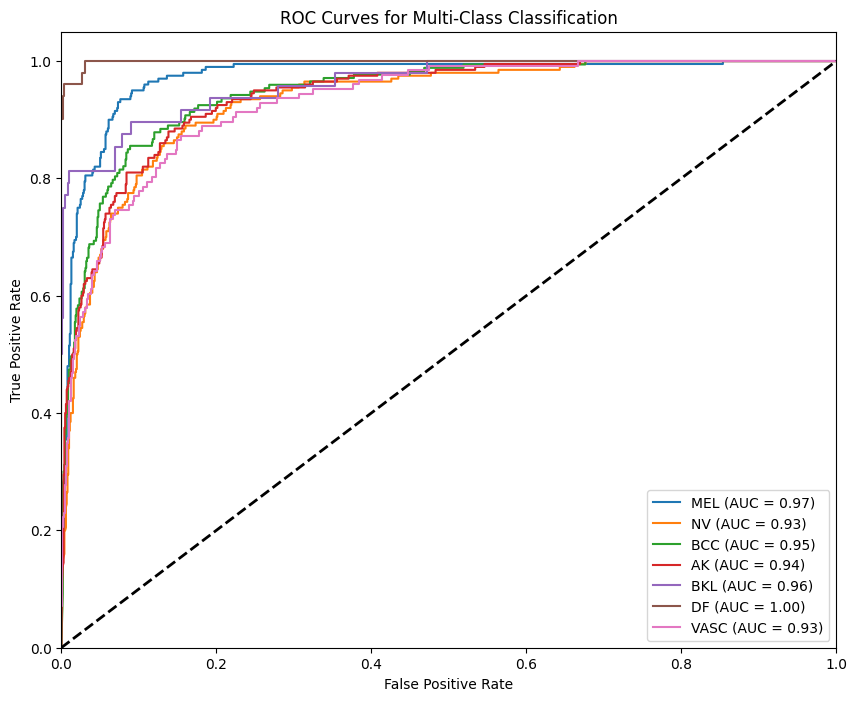

In [ ]:
predicted_probs = np.array(res_pred).reshape(len(res_pred),8)
org_true = np.array(res_true)

true_labels = res_true
labell = {1:'MEL',2:'NV',3:'BCC',4:'AK',5:'BKL',6:'DF',7:'VASC',8:'SCC'}
n_classes = 8  # Replace with the number of classes in your problem

fpr = {}  # False Positive Rate
tpr = {}  # True Positive Rate
roc_auc = {}  # AUC

for i in range(1,n_classes):
    # Create binary labels for the current class (1 if it's the current class, 0 otherwise)
    y_true_ = np.array([1 if y == i else 0 for y in true_labels])

    # Get the predicted probabilities for the current class
    y_score = predicted_probs[:,i]
    # print(y_true_)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))

for i in range(1,n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labell[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc='best')
plt.show()
